In [28]:
import tensorflow as tf
import numpy
import matplotlib
import os 
import re
import numpy as np
from tqdm.notebook import tqdm   

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


# Data

In [150]:
# 한국어를 지원하는 폰트
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"


''' set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다.
    - 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요!
    - 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
'''
cleaned_corpus = []

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    # [[YOUR CODE]]
    corpus_set = set(zip(kor, eng))
    cleaned_corpus = list(corpus_set)
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [3]:
print(cleaned_corpus[0])

('원인을 발견해 내고 차량 문에 낀 대리석을 빼내자 대리석에는“결국 찾아냈군 (욕)”이라는 글이 쓰여 있었다.', 'At last they pulled out the marble and a note: "You finally found it, you f****r." Whatever you do, be careful not to cross the line into illegal behavior.')


In [4]:
kor, eng = zip(*cleaned_corpus)

In [5]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower() #모든 입력을 소문자로 변환합니다.
    sentence = re.sub(r'[^a-zA-Z0-9ㄱ-ㅎㅏ-ㅣ가-힣\s.!?.,;]', '', sentence)#알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
    sentence = re.sub(r'([.!?.,;])', r' \1 ', sentence) #문장부호 양옆에 공백을 추가합니다.
    sentence = sentence.strip() #문장 앞뒤의 불필요한 공백을 제거합니다.

    return sentence

In [6]:
kor_corpus = [preprocess_sentence(sentence) for sentence in kor]
eng_corpus = [preprocess_sentence(sentence) for sentence in eng]

In [7]:
'''한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 
    - 토큰화에는 Sentencepiece를 활용하세요. 
    - 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다.
    - 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요.
    - en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.
    
    - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
    - 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
    - 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
    <PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3

'''
import sentencepiece as spm

def generate_tokenizer(corpus,
                        vocab_size=20000,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    """
    SentencePiece를 사용하여 토크나이저를 생성하고 학습하는 함수

    Args:
        corpus (list): 학습할 텍스트 말뭉치.
        vocab_size (int): 생성할 단어 사전 크기 (기본값 20,000).
        lang (str): 언어 종류 (기본값 'ko').
        pad_id, bos_id, eos_id, unk_id (int): 특수 토큰 ID.

    Returns:
        tokenizer (SentencePieceProcessor): 학습된 SentencePiece tokenizer.
    """
    corpus_file = f'{lang}_corpus.txt'
    with open(corpus_file, 'w', encoding='utf-8') as f:
        for sentence in corpus:
            f.write(sentence + '\n')
    
    spm.SentencePieceTrainer.train(
        input=corpus_file,  # 학습할 텍스트 파일
        model_prefix=f'{lang}_tokenizer',  # 모델 파일 이름 (prefix)
        vocab_size=vocab_size,  # 단어 사전 크기
        character_coverage=1.0,  # 모든 문자 포함
        model_type='bpe',  # BPE 방식
        pad_id=pad_id,  # <PAD> 토큰 ID
        bos_id=bos_id,  # <BOS> 토큰 ID
        eos_id=eos_id,  # <EOS> 토큰 ID
        unk_id=unk_id  # <UNK> 토큰 ID
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f'{lang}_tokenizer.model')

    return tokenizer


In [8]:
cleaned_corpus[0][1]

'At last they pulled out the marble and a note: "You finally found it, you f****r." Whatever you do, be careful not to cross the line into illegal behavior.'

In [9]:
len(cleaned_corpus)

78968

In [10]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

In [12]:
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [13]:
kor_sequences = [ko_tokenizer.encode(sentence) for sentence in kor_corpus]
eng_sequences = [en_tokenizer.encode(sentence) for sentence in eng_corpus]

In [17]:
src_corpus = []
tgt_corpus = []

# 토큰의 길이가 50 이하인 데이터를 선별
for idx in tqdm(range(len(kor_corpus))):
    # [[YOUR CODE]]
    kor_tokens = kor_sequences[idx] 
    eng_tokens = eng_sequences[idx]  

    if len(kor_tokens) <= 50 and len(eng_tokens) <= 50:
        src_corpus.append(kor_tokens)
        tgt_corpus.append(eng_tokens)


enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [18]:
print(enc_train.shape, dec_train.shape)

(75124, 50) (75124, 50)


# Model

### Positional Encoding
$$PE_{(pos,2i)} = sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$$
$$PE_{(pos,2i+1)} = cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$$

In [497]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in 
                range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [498]:
pos_enc = positional_encoding(5, 4)
print(pos_enc)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.99500417  0.00999983  0.9999995 ]
 [ 0.90929743  0.98006658  0.01999867  0.999998  ]
 [ 0.14112001  0.95533649  0.0299955   0.9999955 ]
 [-0.7568025   0.92106099  0.03998933  0.999992  ]]


#### Scaled Dot-Product Attention

$$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

#### Multi-head Attention

$$MultiHead(Q,K,V) = Concat(head_1,head_2, ... head_h)W^O$$

In [499]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        # # Dense 레이어는 학습 가능한 가중치 행렬을 이용하여 입력을 변환 
        self.W_q = tf.keras.layers.Dense(d_model) 
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)  # K.shape[-1] : k_dim
        
        QK = tf.matmul(Q, K, transpose_b=True) # Query, Key 유사도 계산
        scaled_qk = QK / tf.math.sqrt(d_k)
        

        # Masking: mask가 주어진 경우, 마스크된 값에 대해 큰 음수 값(-1e9)을 더하여 softmax 계산 시 무시
        if mask is not None: 
            scaled_qk += (mask * -1e9) 

        # Softmax: Attention Weights를 계산하여, 각 값에 대해 중요도
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
#         x: [ batch x length x emb ]
#         return: [ batch x heads x length x self.depth ]
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0,2,1,3])

        return split_x

    def combine_heads(self, x):
#         x: [ batch x heads x length x self.depth ]
#         return: [ batch x length x emb ]
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    

    def call(self, Q, K, V, mask):
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(WQ_split, WK_split, WV_split, mask)
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

In [500]:
batch_size = 2      
seq_length = 4      
d_model = 8         

x = tf.random.uniform(shape=(batch_size, seq_length, d_model)) # x: [batch_size, seq_length, d_model]


print("input tensor:")
print(x.numpy().shape)

num_heads = 2
depth = d_model // num_heads

split_x = tf.reshape(x, (batch_size, -1, num_heads, depth))
print("reshape x:")
print(split_x.shape)
split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
print("transpose x:")
print(split_x.shape) # [ batch x heads x length x self.depth ]


input tensor:
(2, 4, 8)
reshape x:
(2, 4, 2, 4)
transpose x:
(2, 2, 4, 4)


#### FFN
각 단어에 대해 독립적으로 적용 (같은 가중치, 다른 입력) 

$$y_i = W_2*ReLU(W_1x_i + b_1)+b_2$$

In [501]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [502]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [503]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        
        self.dec_self_attn = MultiHeadAttention(d_model, n_heads) #num_heads
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

In [504]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [505]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [506]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len=50,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        #TODO : 
        self.shared = shared
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
            

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
            
        out += self.pos_encoding[np.newaxis, ...][:,:seq_len, :]
        out = self.dropout(out)
        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_mask, dec_enc_mask):

        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        enc_output, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_output, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_output, dec_mask, dec_enc_mask)
        
        logits = self.fc(dec_output)    
        
        return logits, enc_attns, dec_attns, dec_enc_attns

##### base lin code had an issue in the mask function

In [514]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
#   dec_mask = generate_causality_mask(tgt) # size인데 tgt가 들어가면 error
    dec_mask = generate_causality_mask(tgt.shape[1])    
    dec_enc_mask = generate_padding_mask(src)
    return enc_mask, dec_mask, dec_enc_mask

In [536]:
src = tf.constant([[1, 2, 3, 0, 0]])
tgt = tf.constant([[1, 2, 3, 4, 0]]) 
print(src)

tf.Tensor([[1 2 3 0 0]], shape=(1, 5), dtype=int32)


In [537]:
tgt.shape[1]

5

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)
tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)
tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


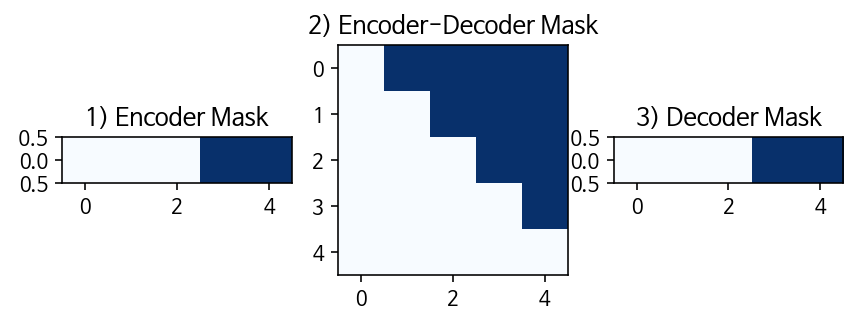

In [538]:
enc_mask, dec_mask, dec_enc_mask = generate_masks(src, tgt)

print(enc_mask)
print(dec_mask)
print(dec_enc_mask)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

# (1, 1, 1, seq_len) > (seq_len,)로 변환 필요
ax1.imshow(enc_mask[0, 0].numpy(), cmap='Blues')
ax2.imshow(dec_mask.numpy(), cmap='Blues')
ax3.imshow(dec_enc_mask[0, 0].numpy(), cmap='Blues')

# plt.show()

In [539]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)
enc_mask, dec_mask, dec_enc_mask = generate_masks(sample_src, sample_tgt)

print(enc_mask)
print(dec_mask)
print(dec_enc_mask)


tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0.

In [549]:
enc_mask.numpy().shape

(16, 1, 1, 25)

In [550]:
enc_mask[:3, 0].numpy().shape

(3, 1, 25)

In [551]:
enc_mask[:3, 0, 0].numpy().shape

(3, 25)

In [553]:
enc_mask[:1, 0, 0].numpy().shape 

(1, 25)

In [520]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [521]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    # [[YOUR CODE]]
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [522]:
# Attention 시각화 
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [523]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns


# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [524]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [525]:
D_MODEL = 512
transformer = Transformer(
                    n_layers=2,
                    d_model=D_MODEL,
                    n_heads=8,
                    d_ff=256,
                    src_vocab_size= SRC_VOCAB_SIZE,
                    tgt_vocab_size= TGT_VOCAB_SIZE,
                    pos_len = 50,
                    dropout=0.2,
                    shared=True)

learning_rate = LearningRateScheduler(512)
# Hyper Params in the paper
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9, # 1차 모멘텀(과거 기울기의 지수이동평균)을 제어
                                     beta_2=0.98, # 차 모멘텀(기울기의 제곱의 지수이동평균)을 제어
                                     epsilon=1e-9)

  0%|          | 0/1174 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


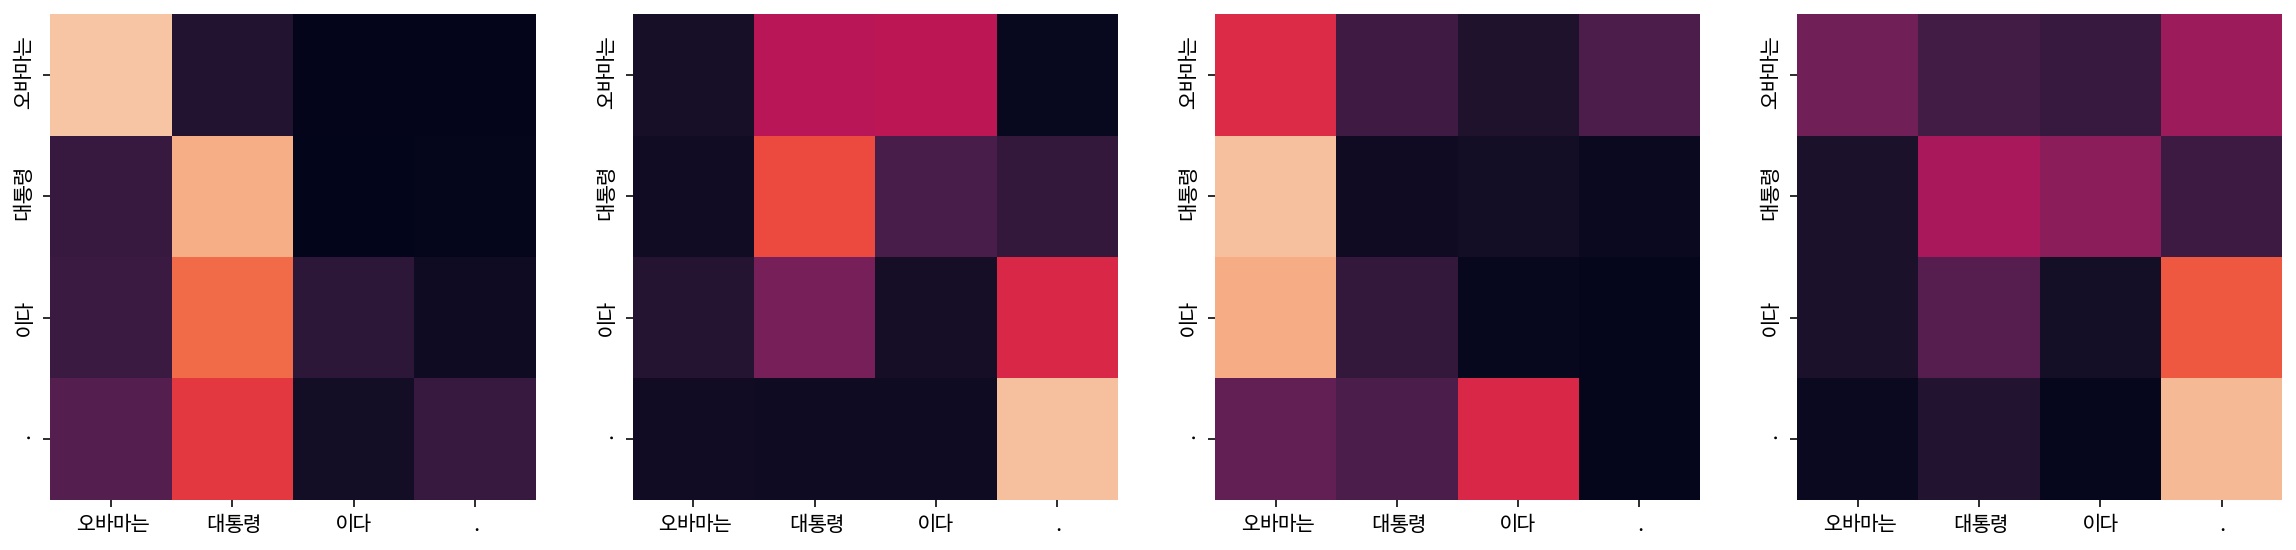

Encoder Layer 2


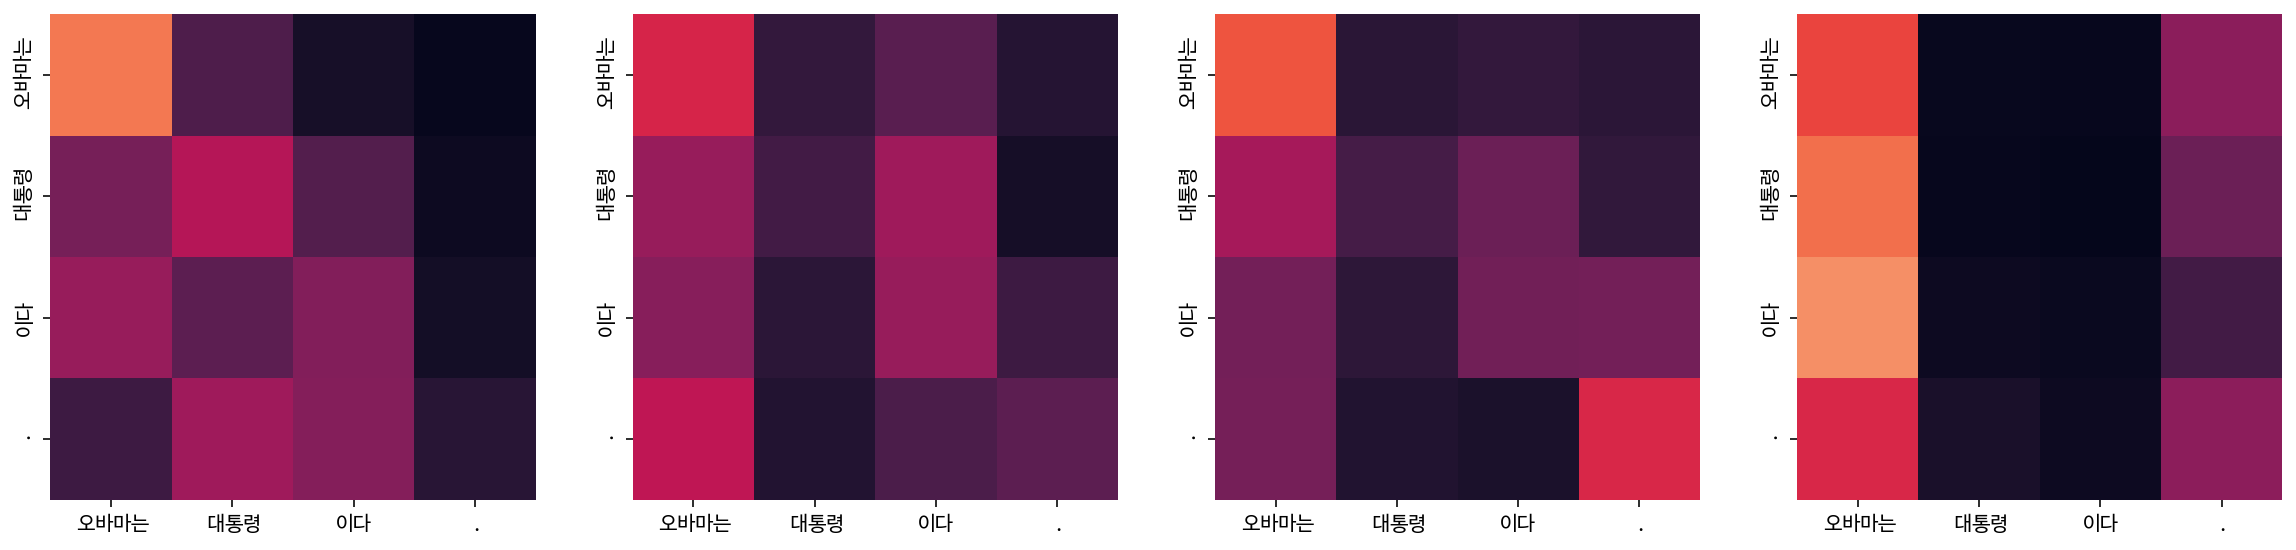

Decoder Self Layer 1


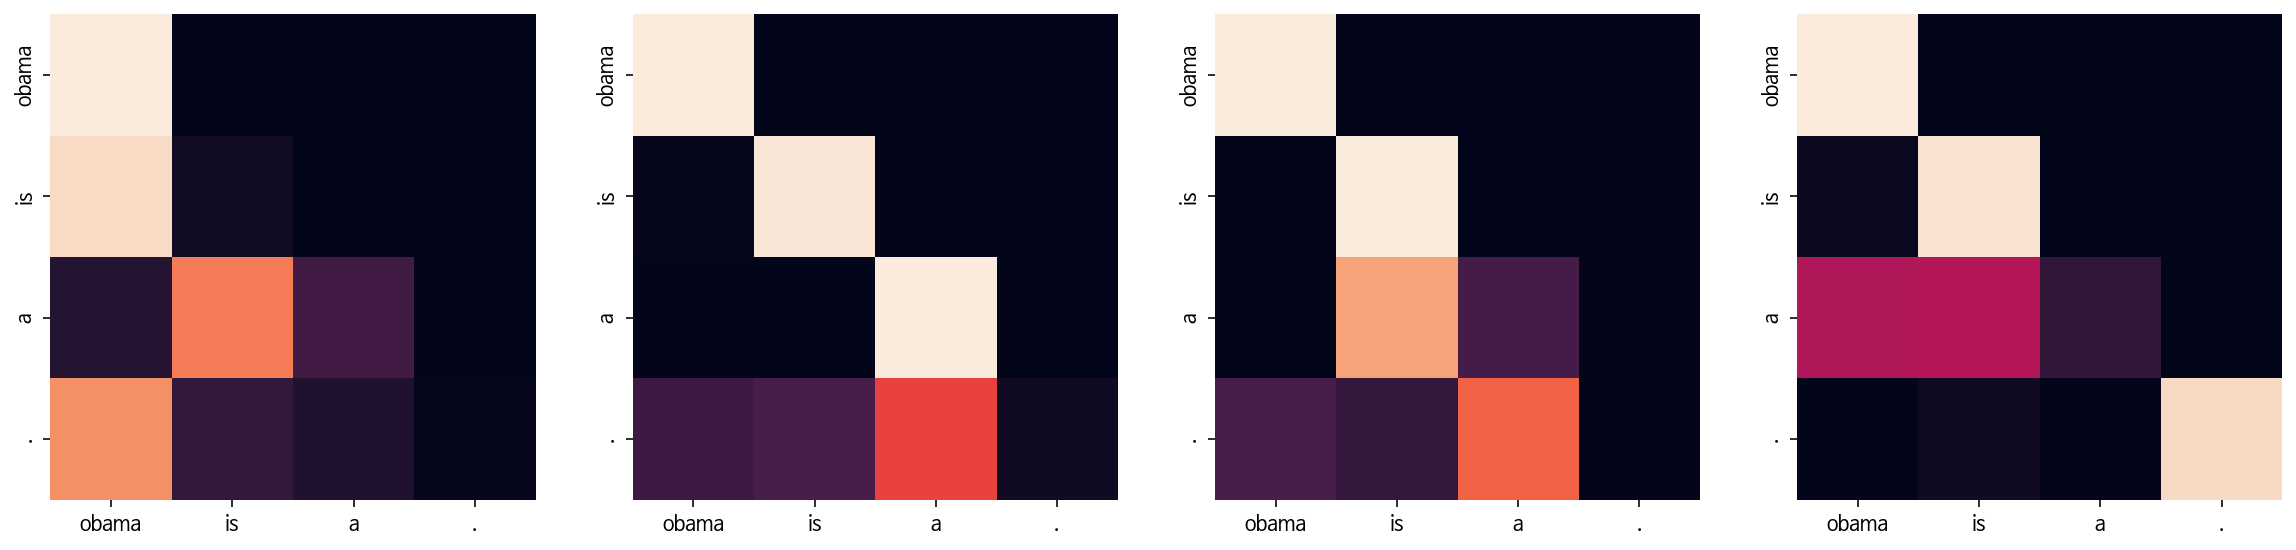

Decoder Src Layer 1


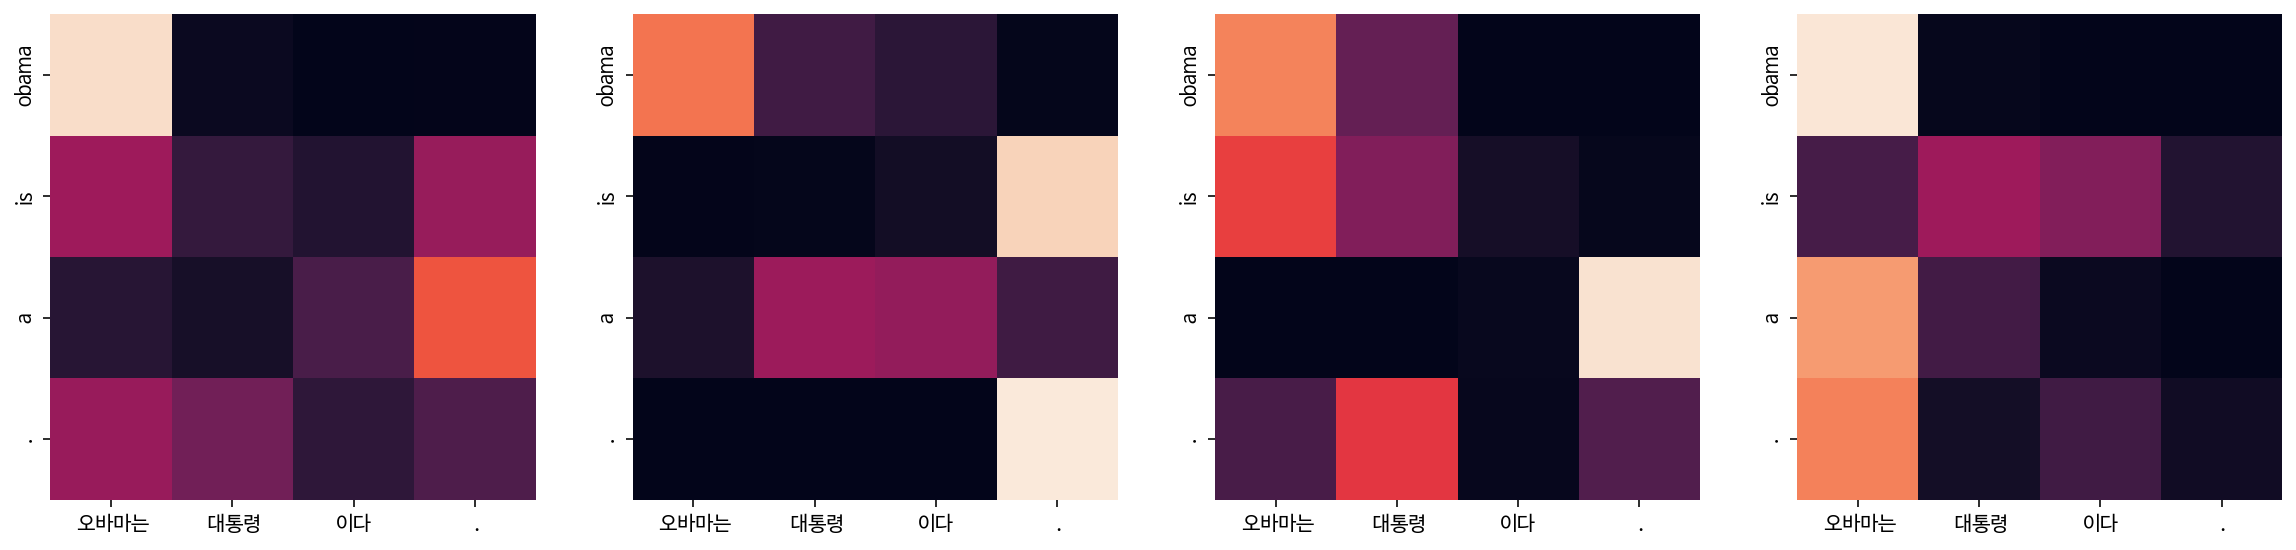

Decoder Self Layer 2


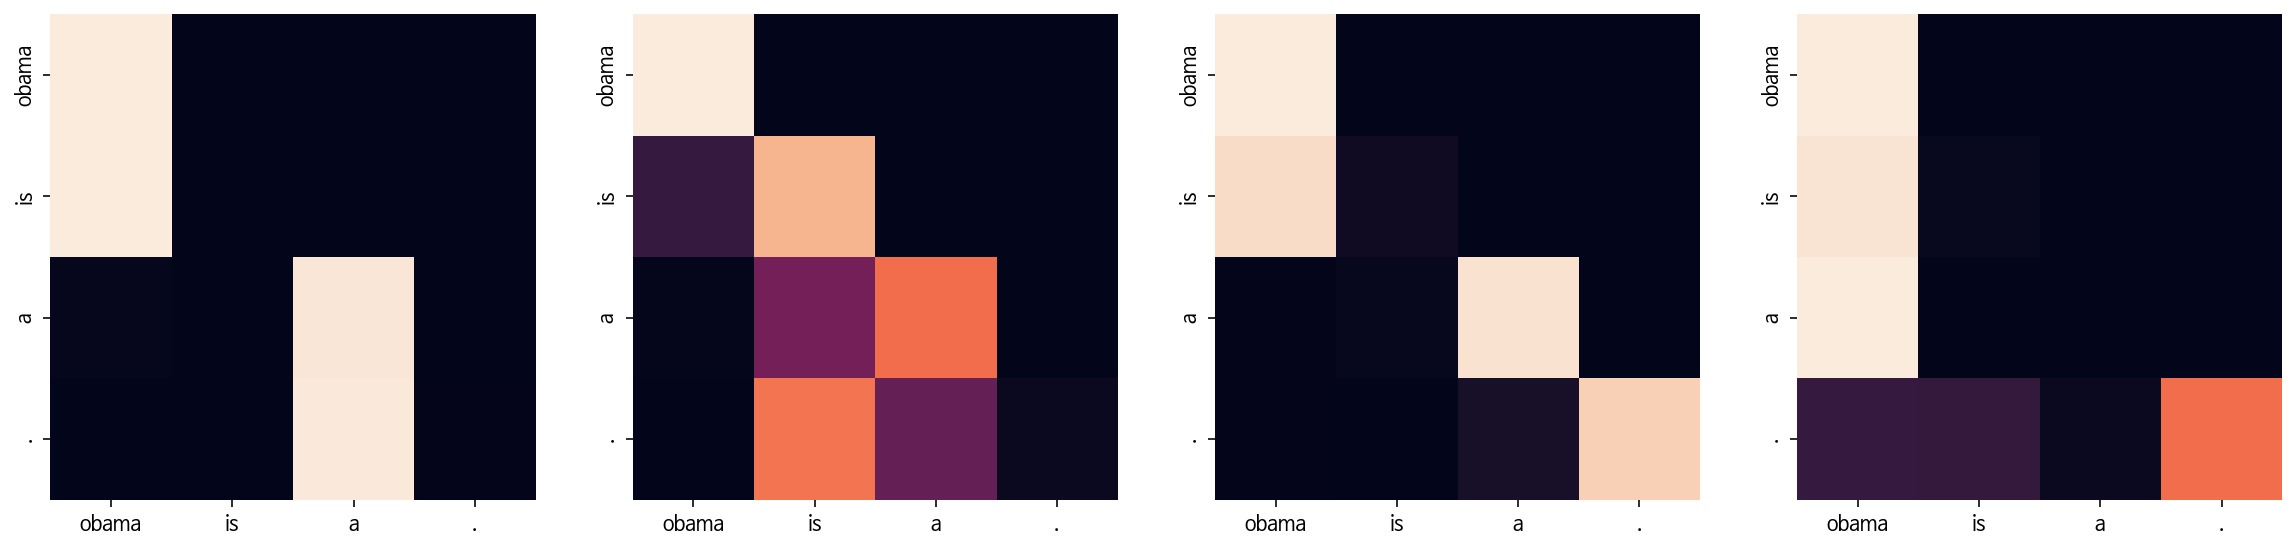

Decoder Src Layer 2


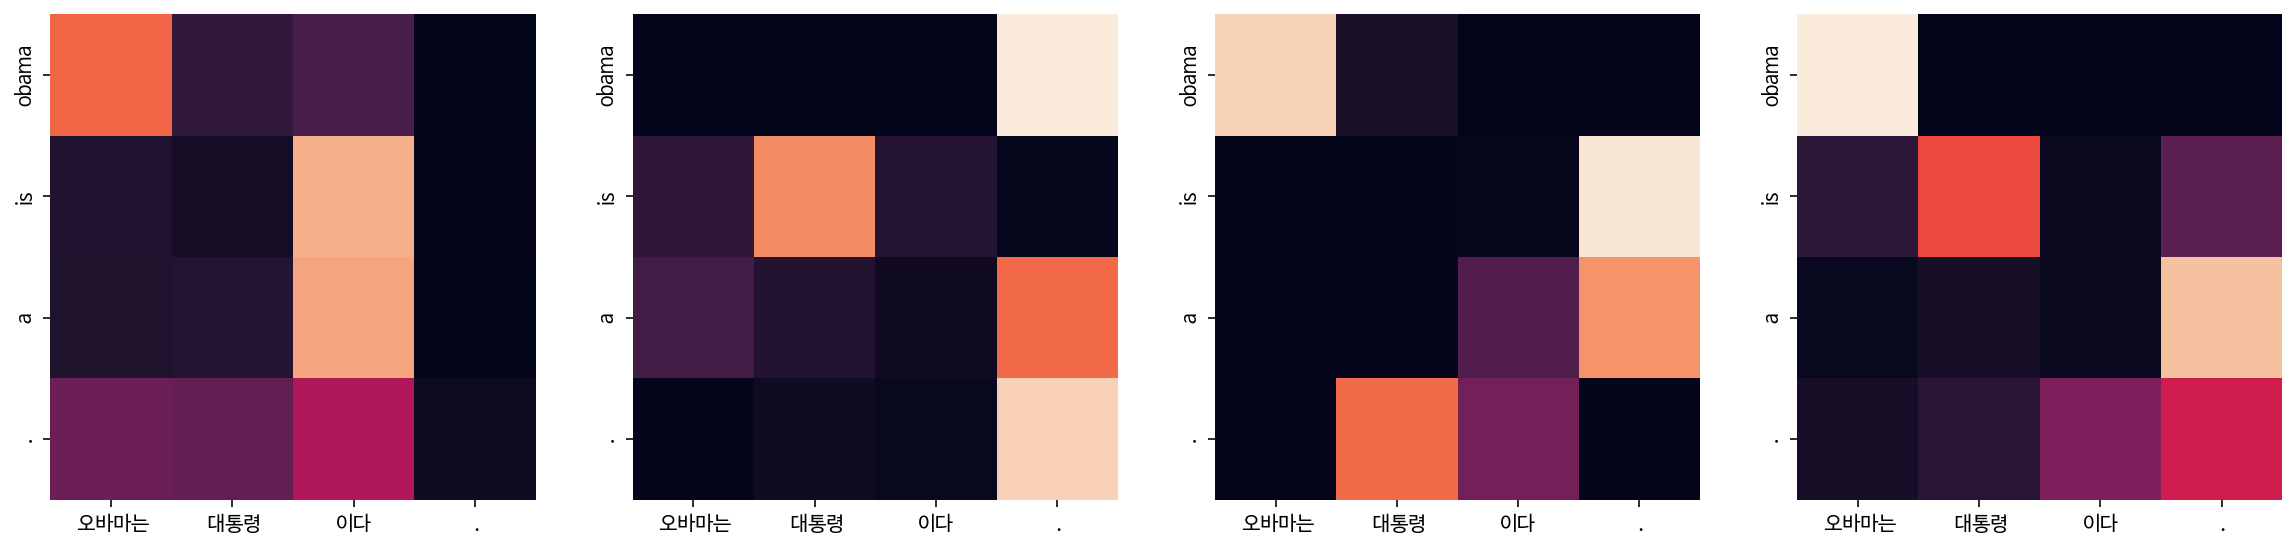

Input: 시민들은 도시 속에 산다.
Predicted translation: the city of red .
Encoder Layer 1


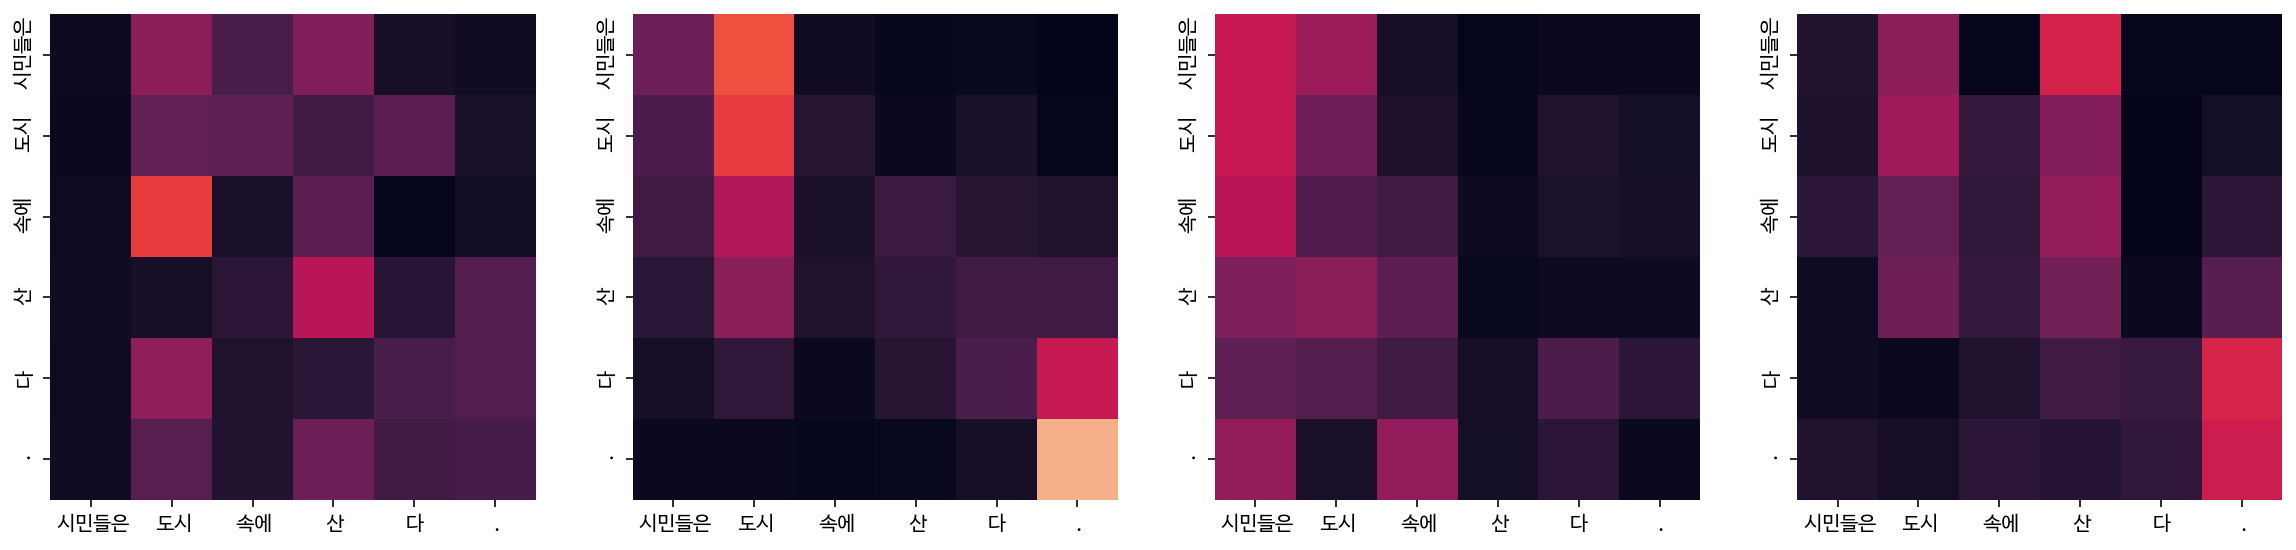

Encoder Layer 2


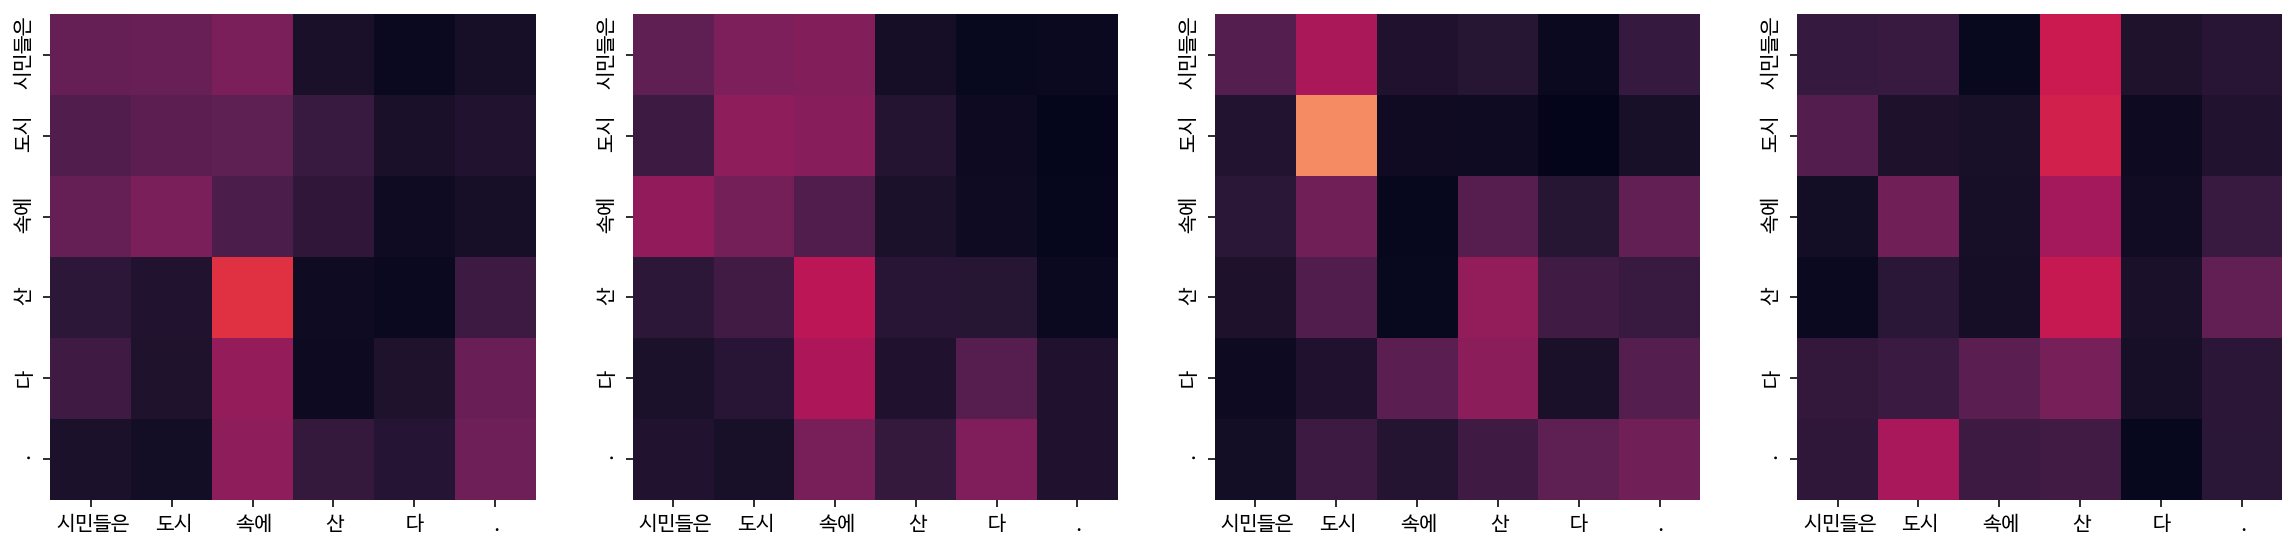

Decoder Self Layer 1


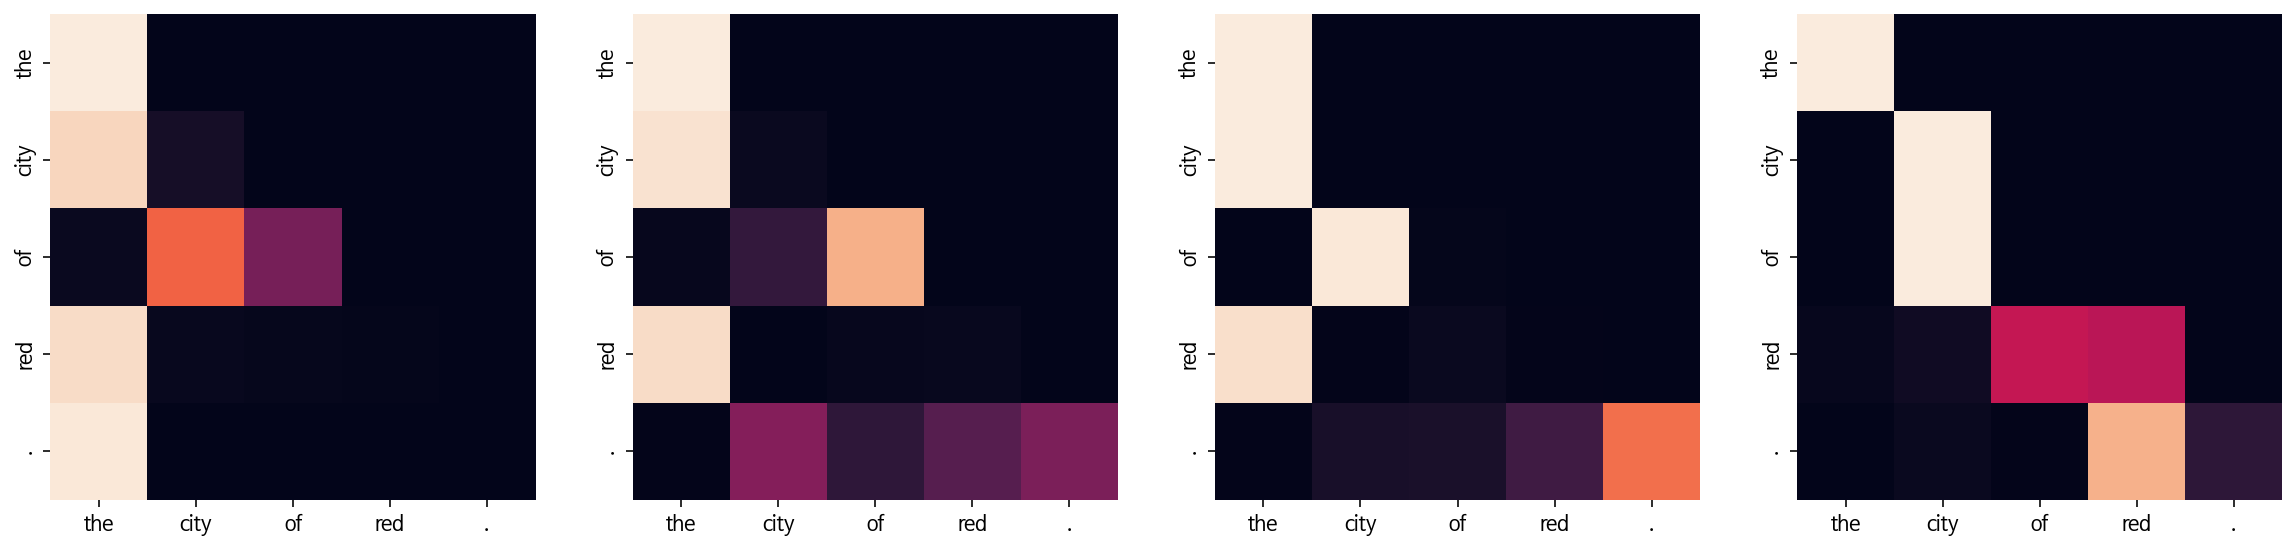

Decoder Src Layer 1


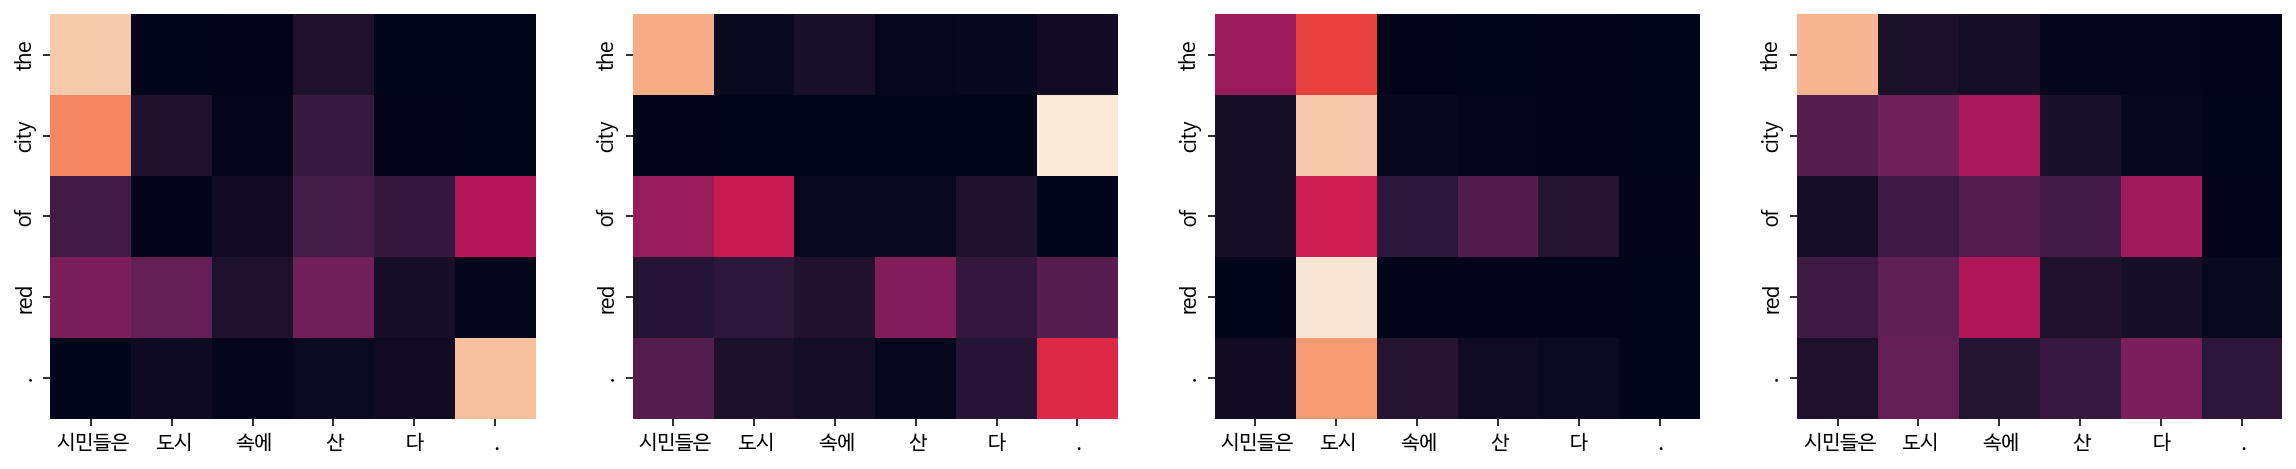

Decoder Self Layer 2


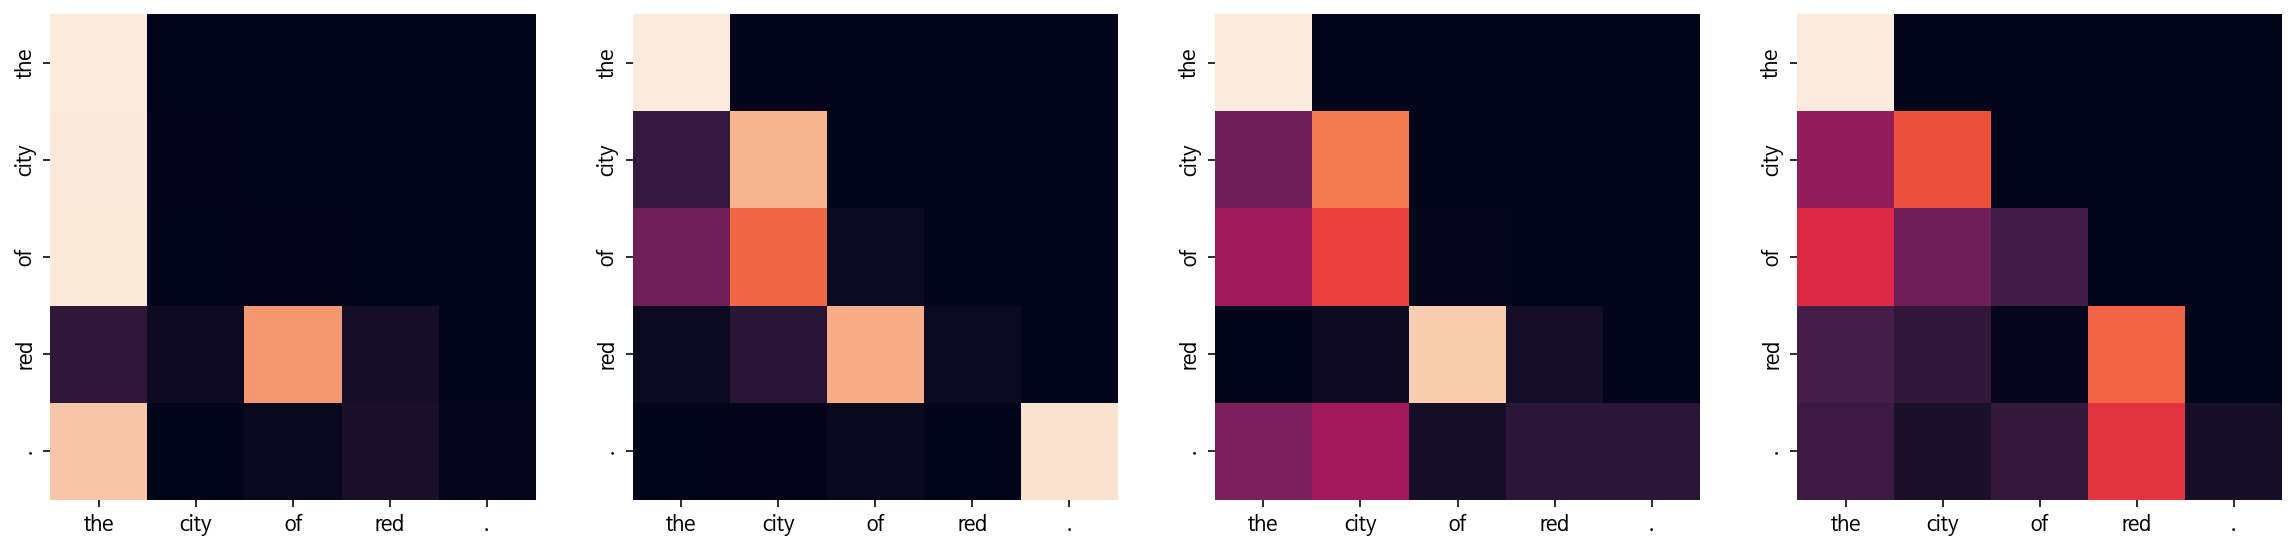

Decoder Src Layer 2


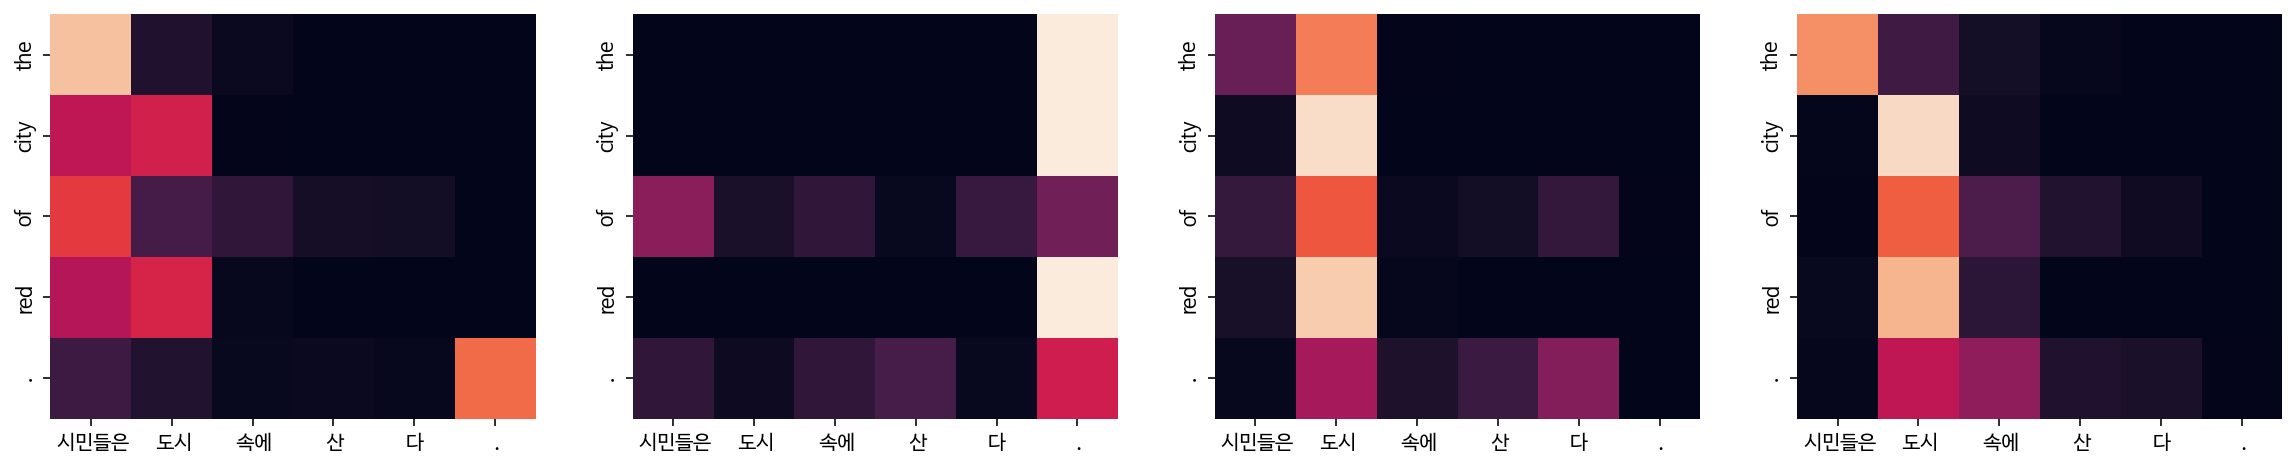

Input: 커피는 필요 없다.
Predicted translation: it is not clear .
Encoder Layer 1


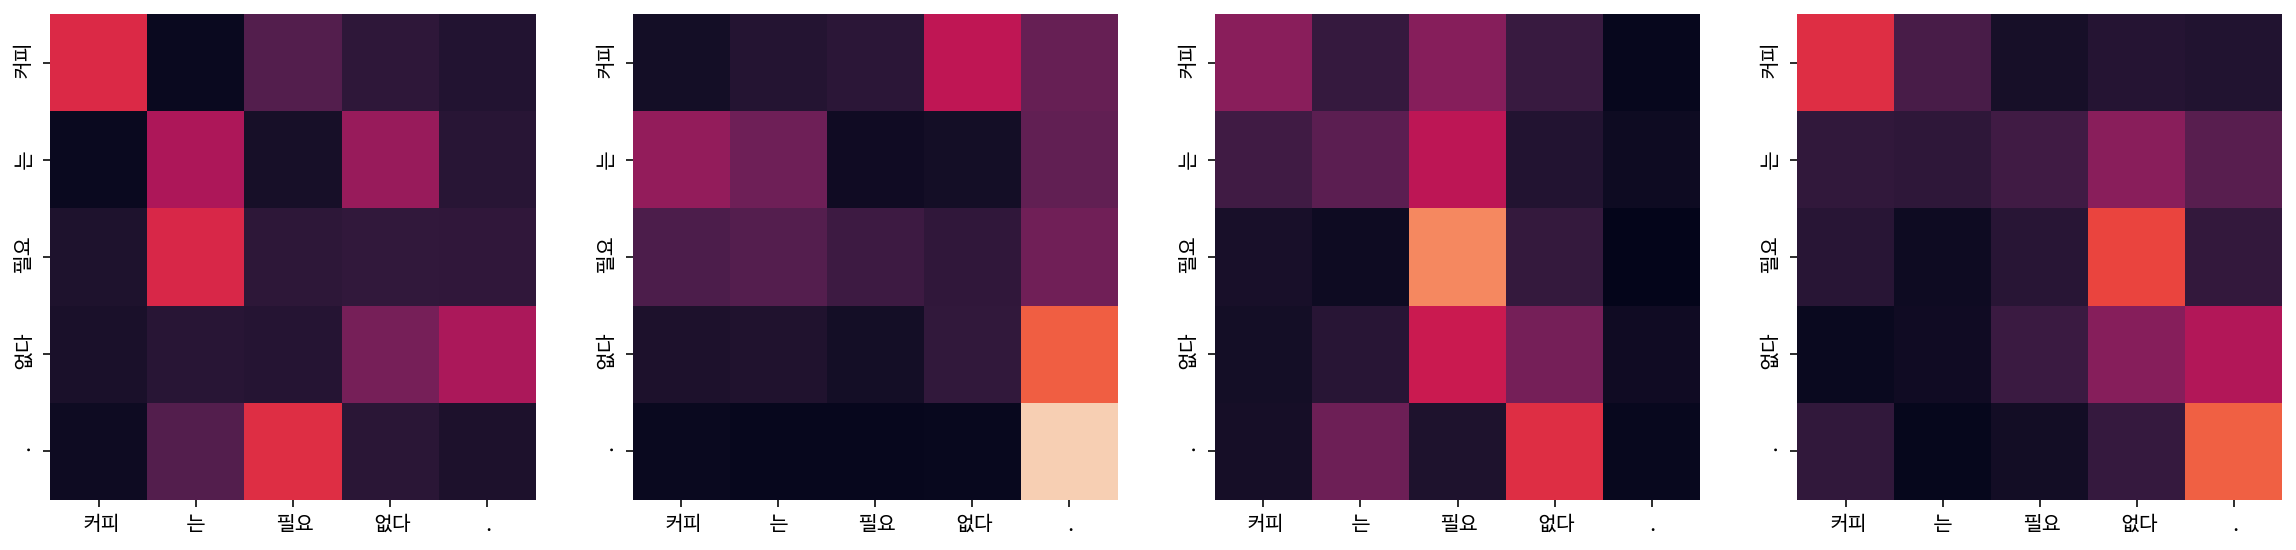

Encoder Layer 2


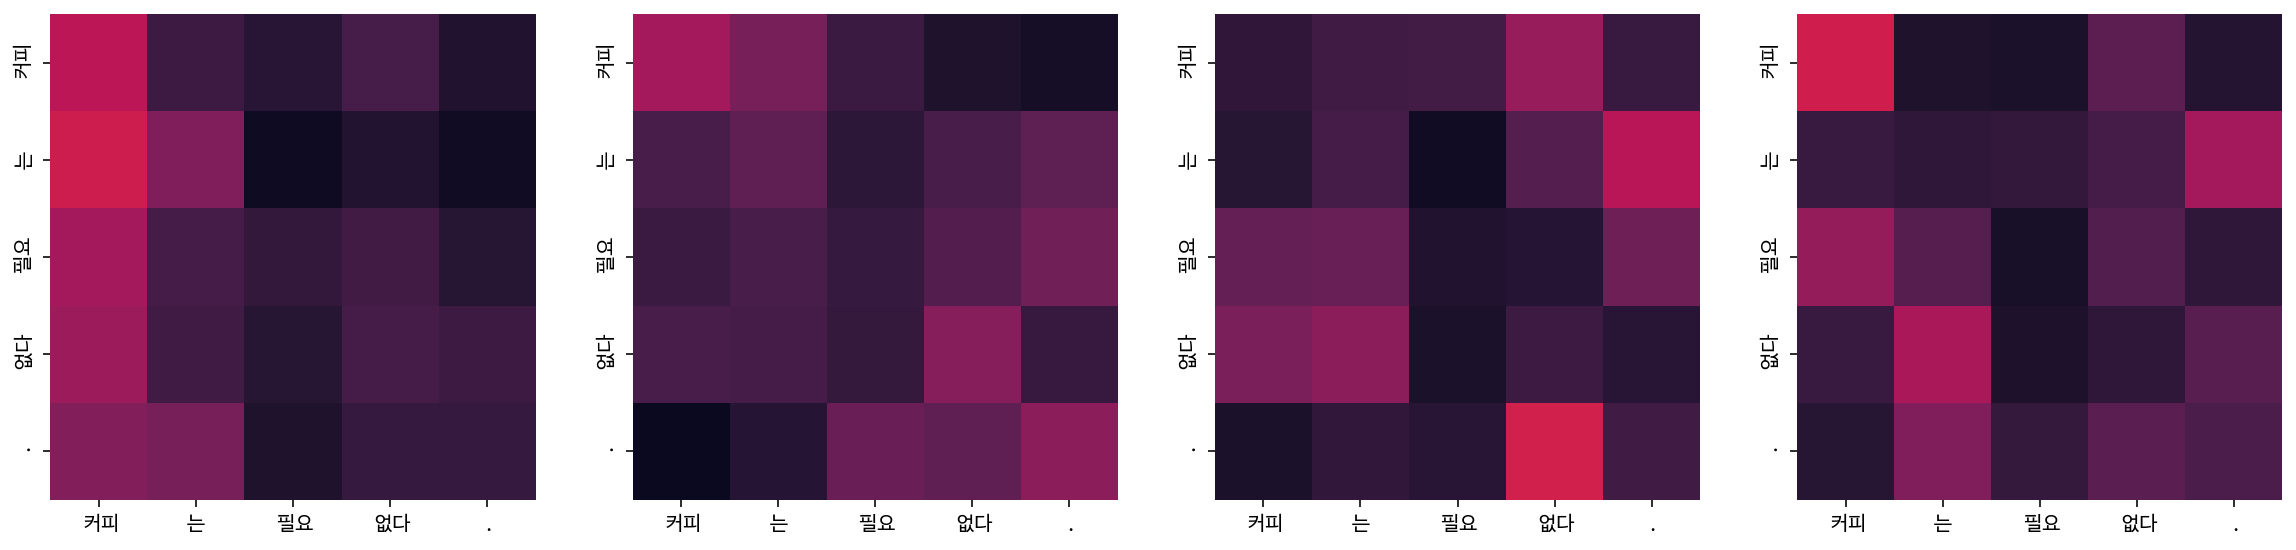

Decoder Self Layer 1


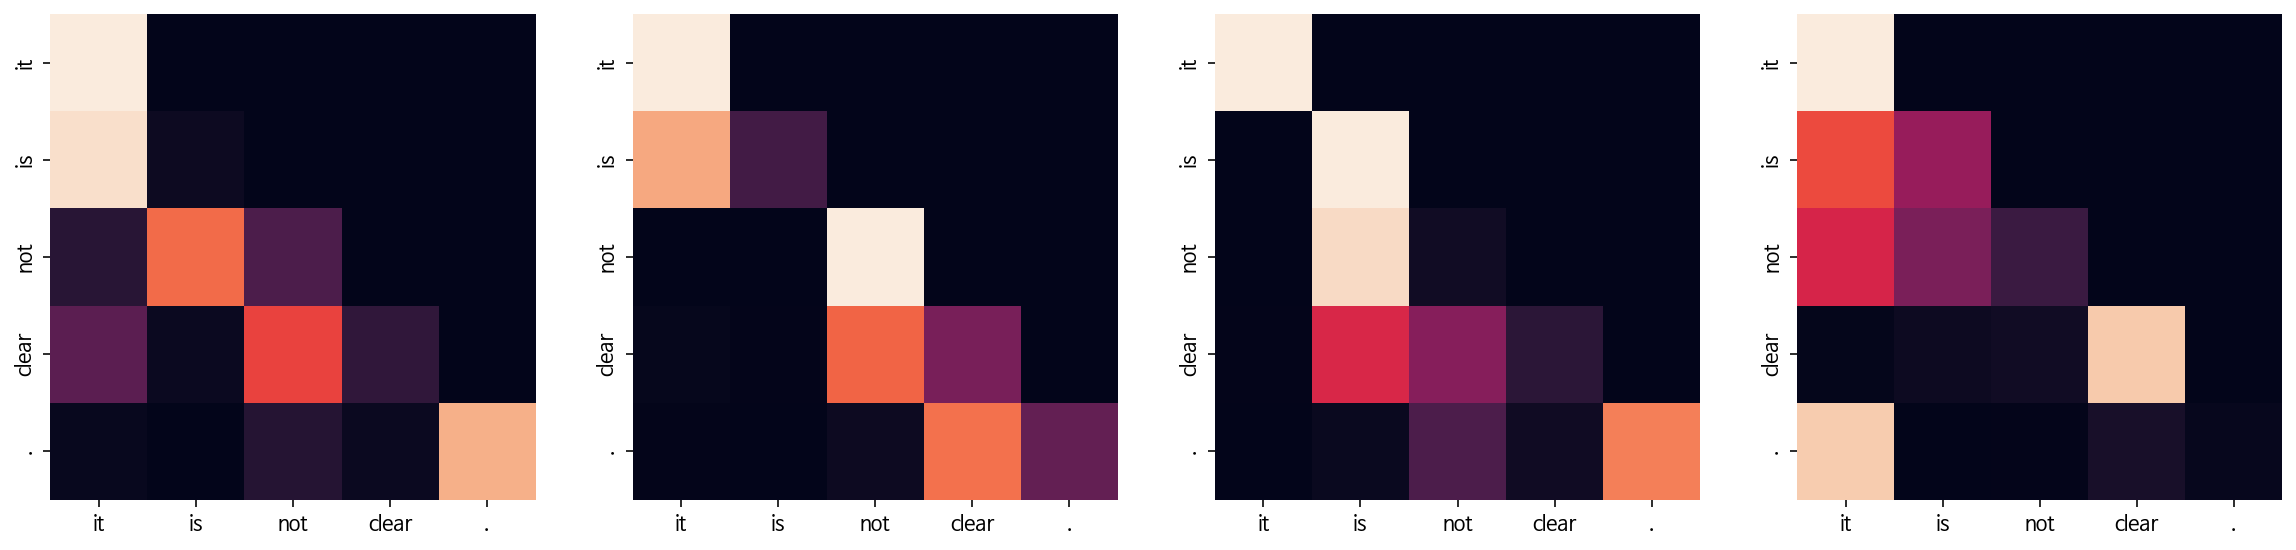

Decoder Src Layer 1


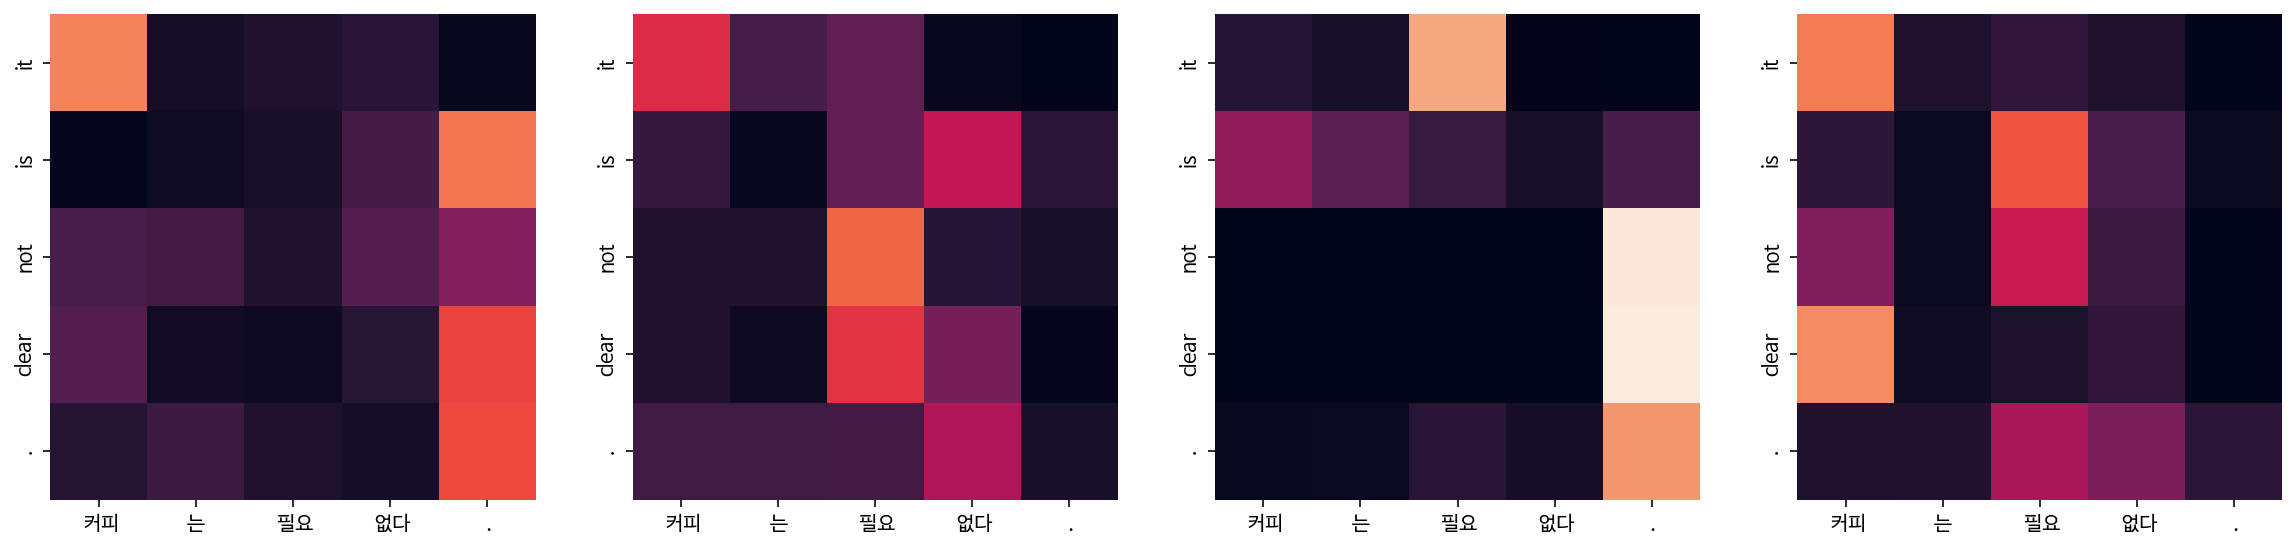

Decoder Self Layer 2


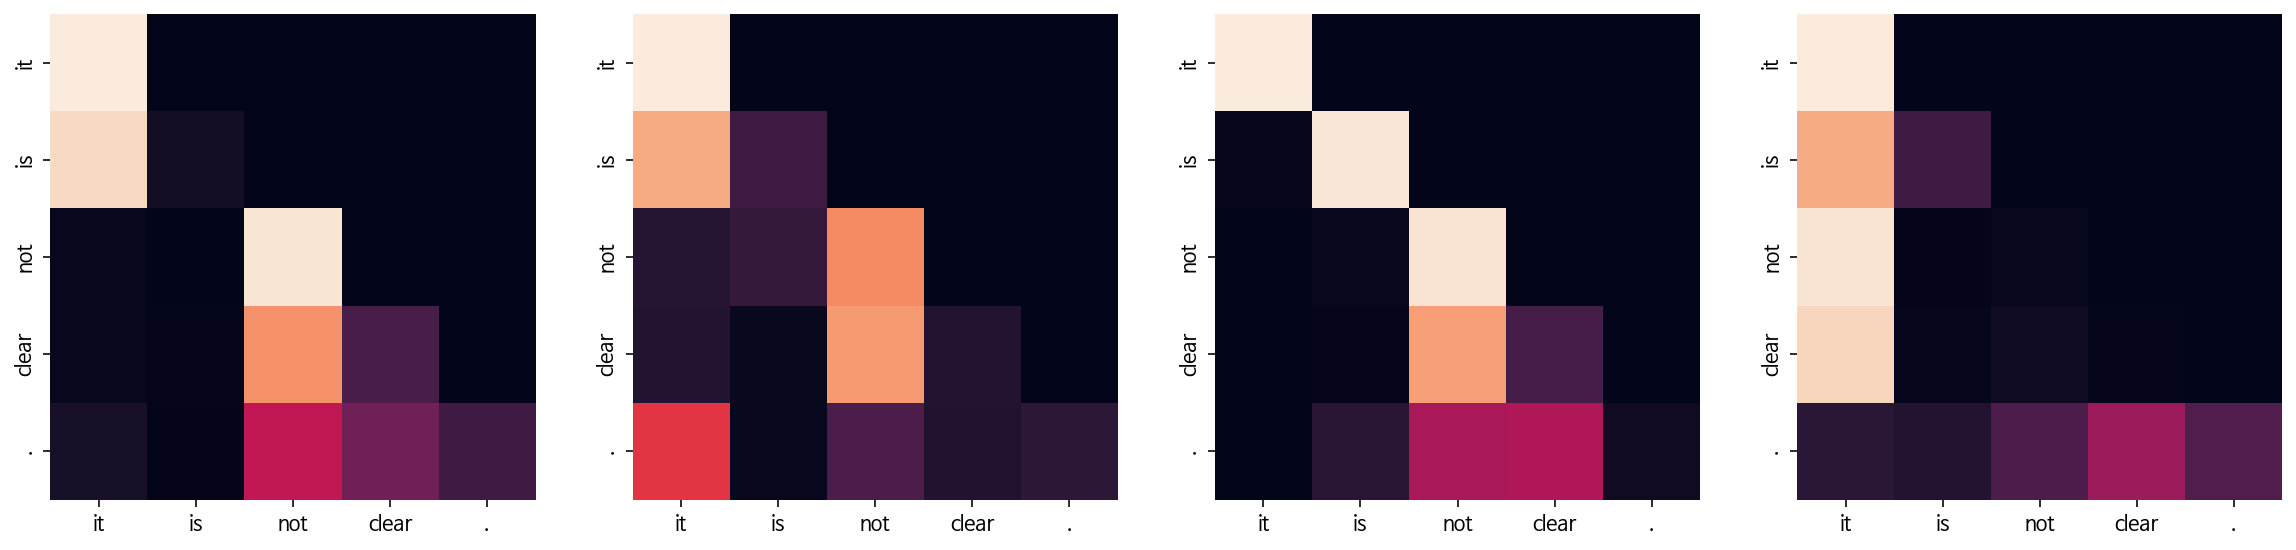

Decoder Src Layer 2


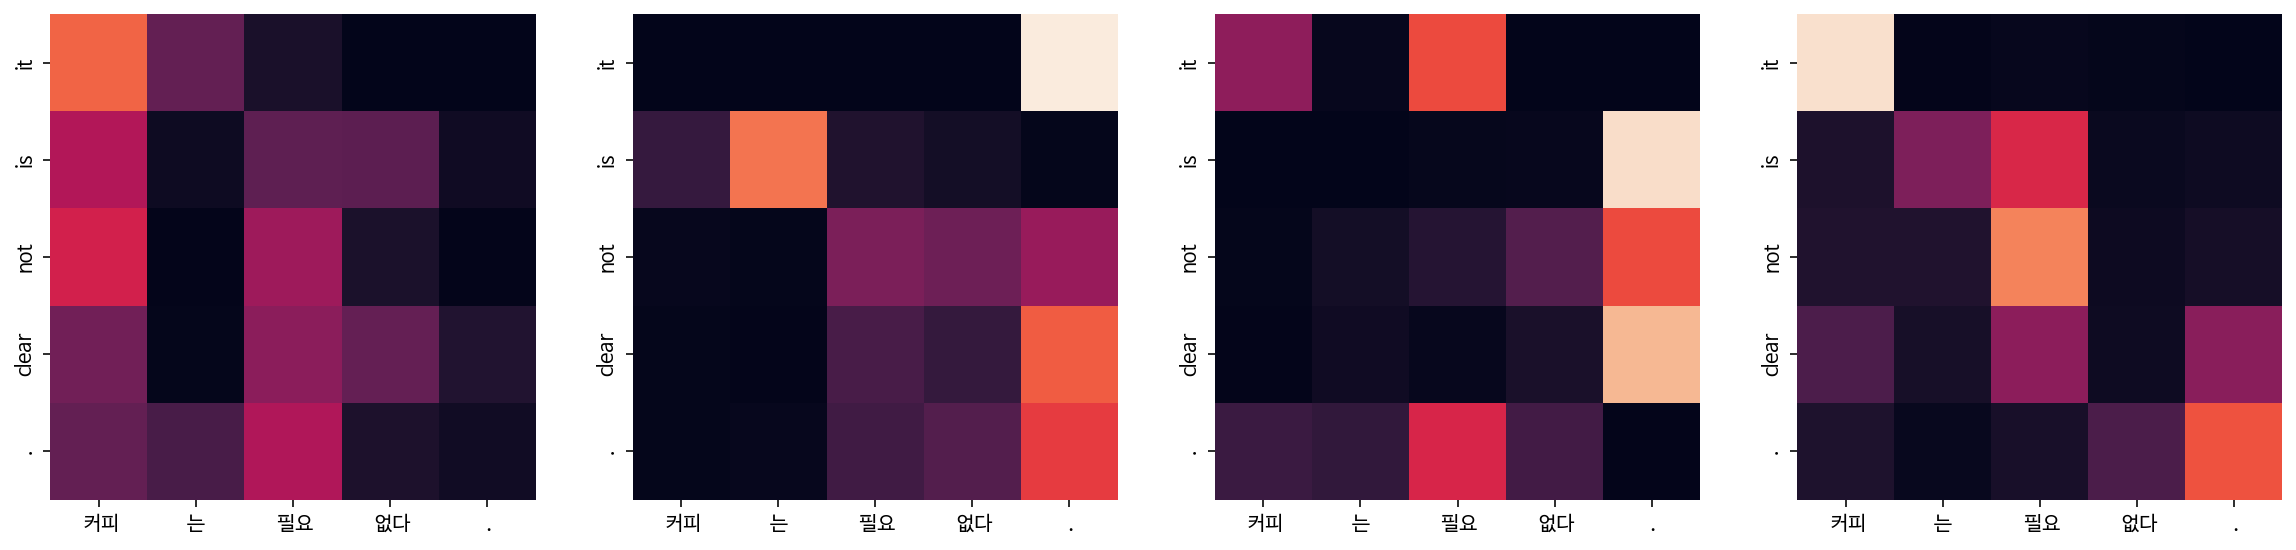

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .
Encoder Layer 1


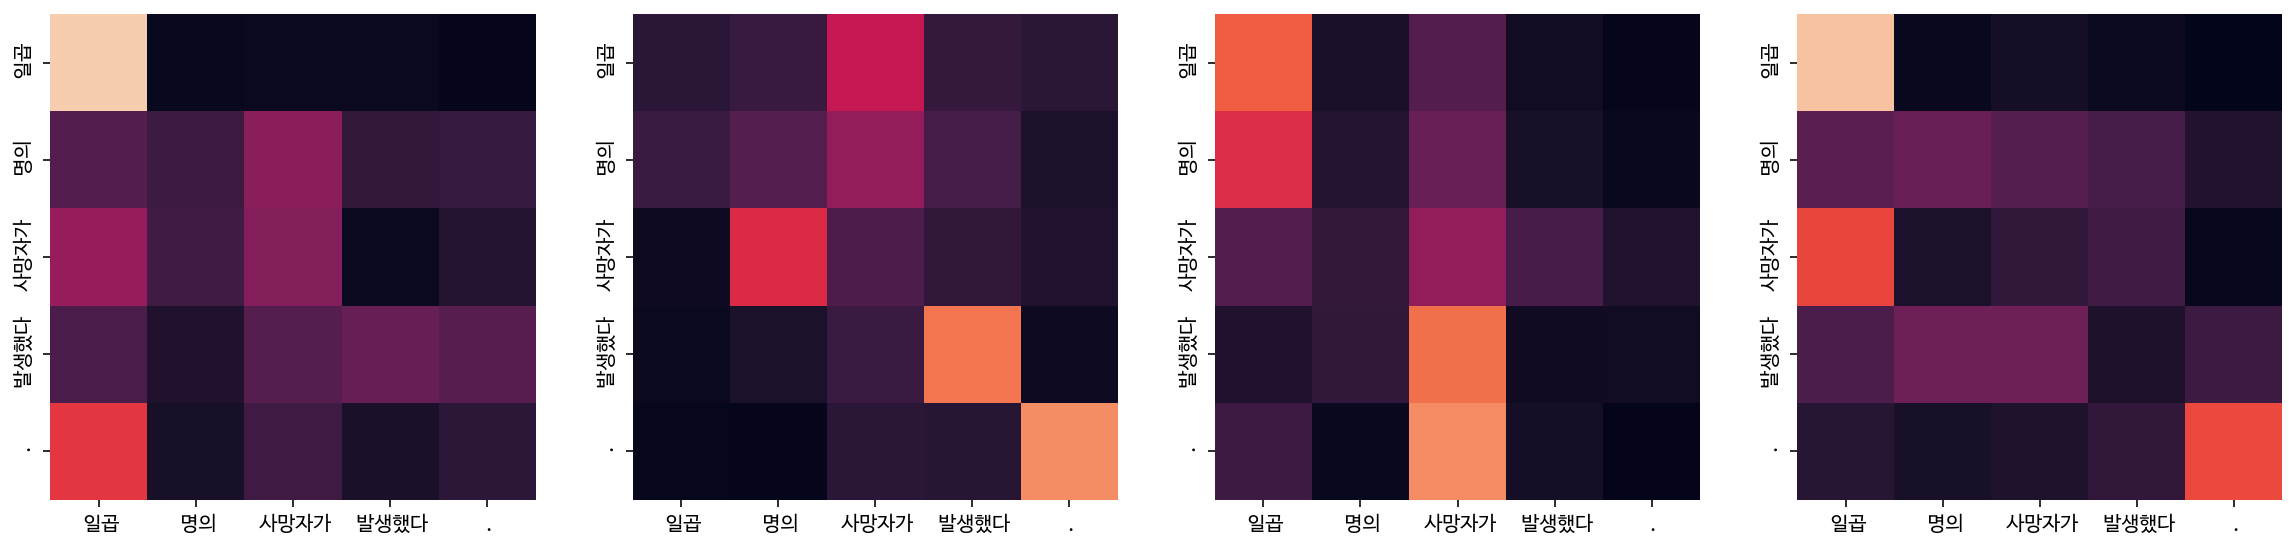

Encoder Layer 2


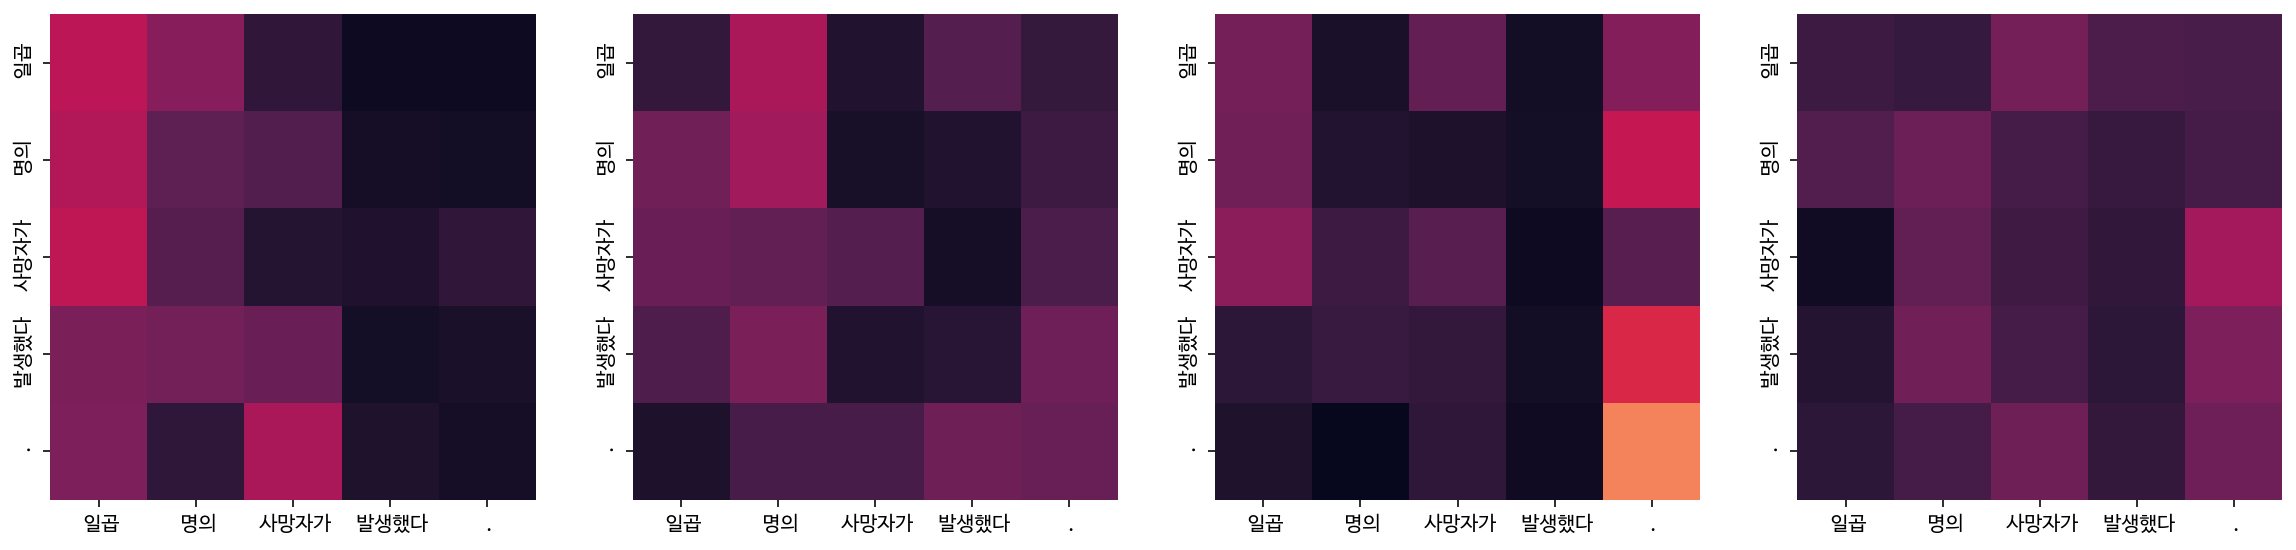

Decoder Self Layer 1


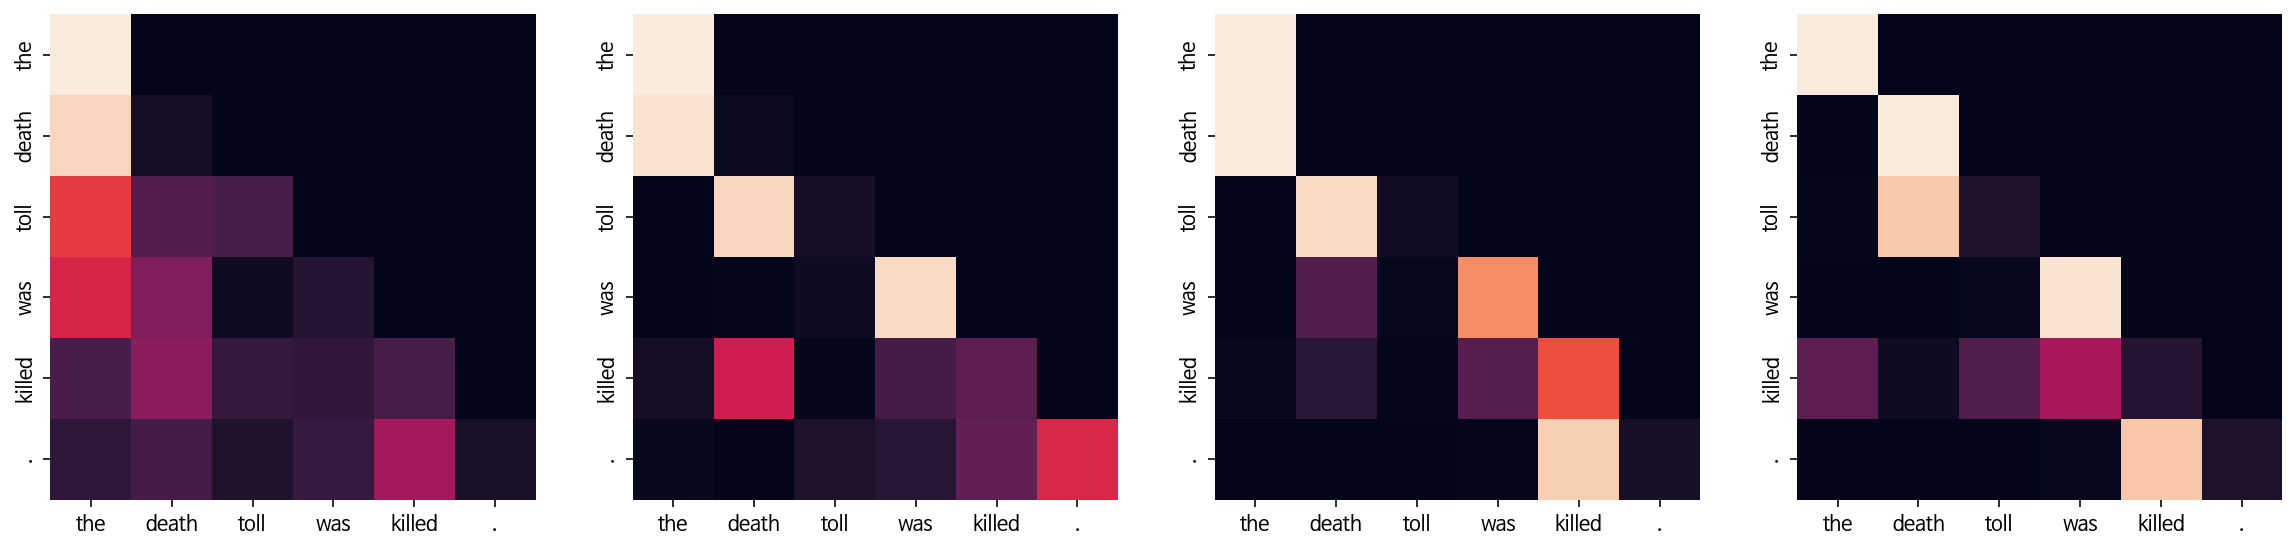

Decoder Src Layer 1


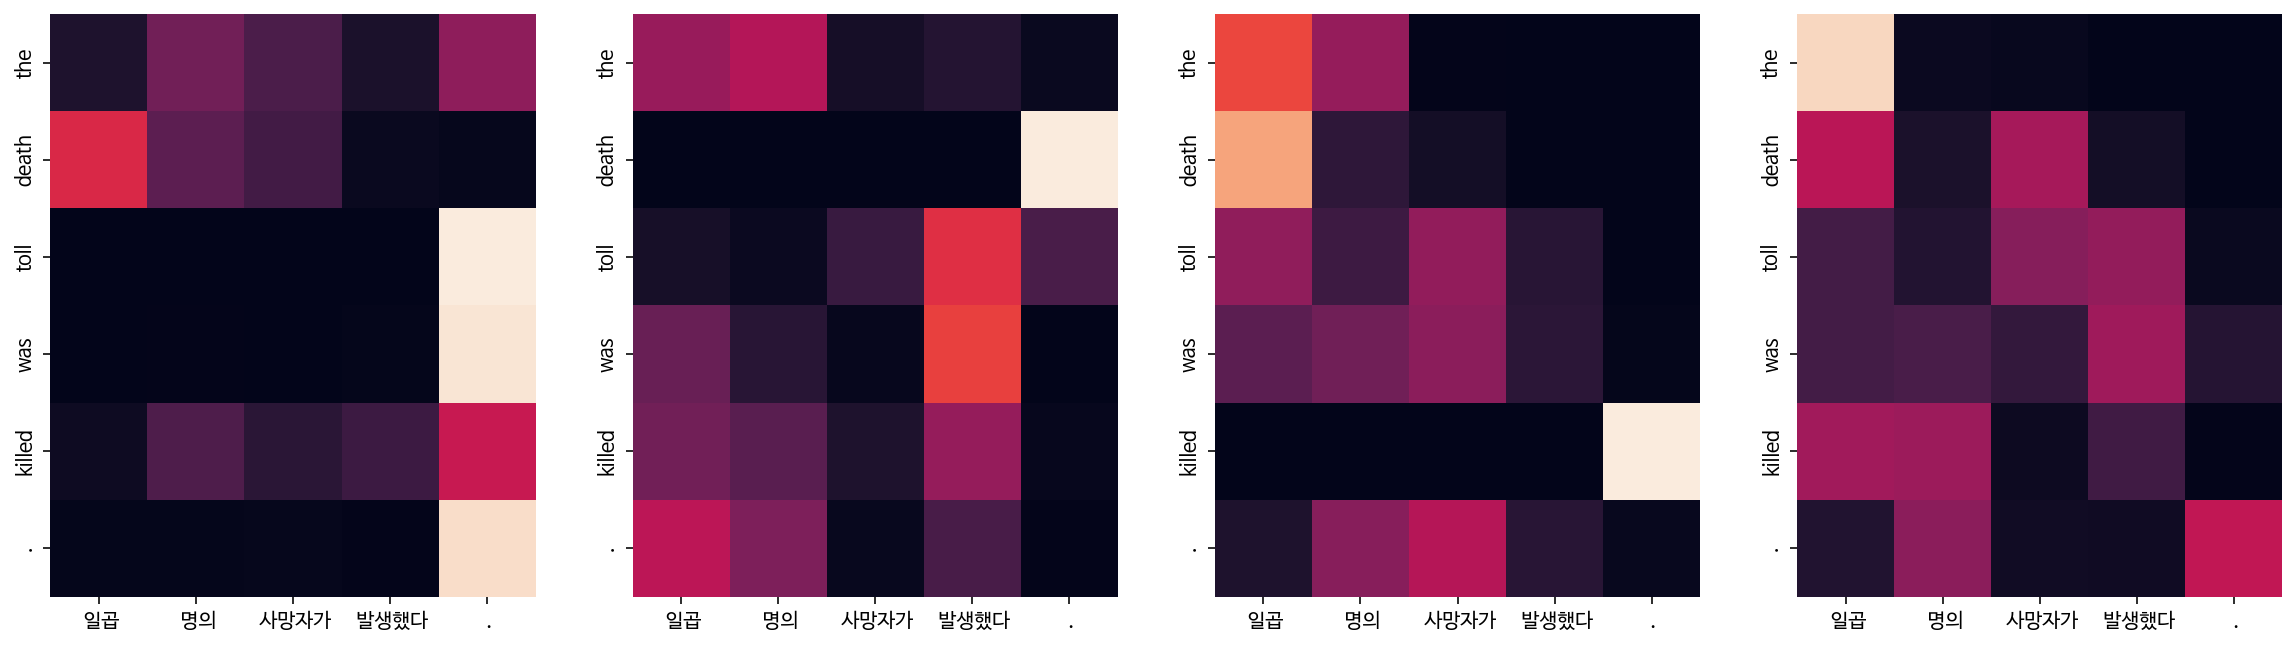

Decoder Self Layer 2


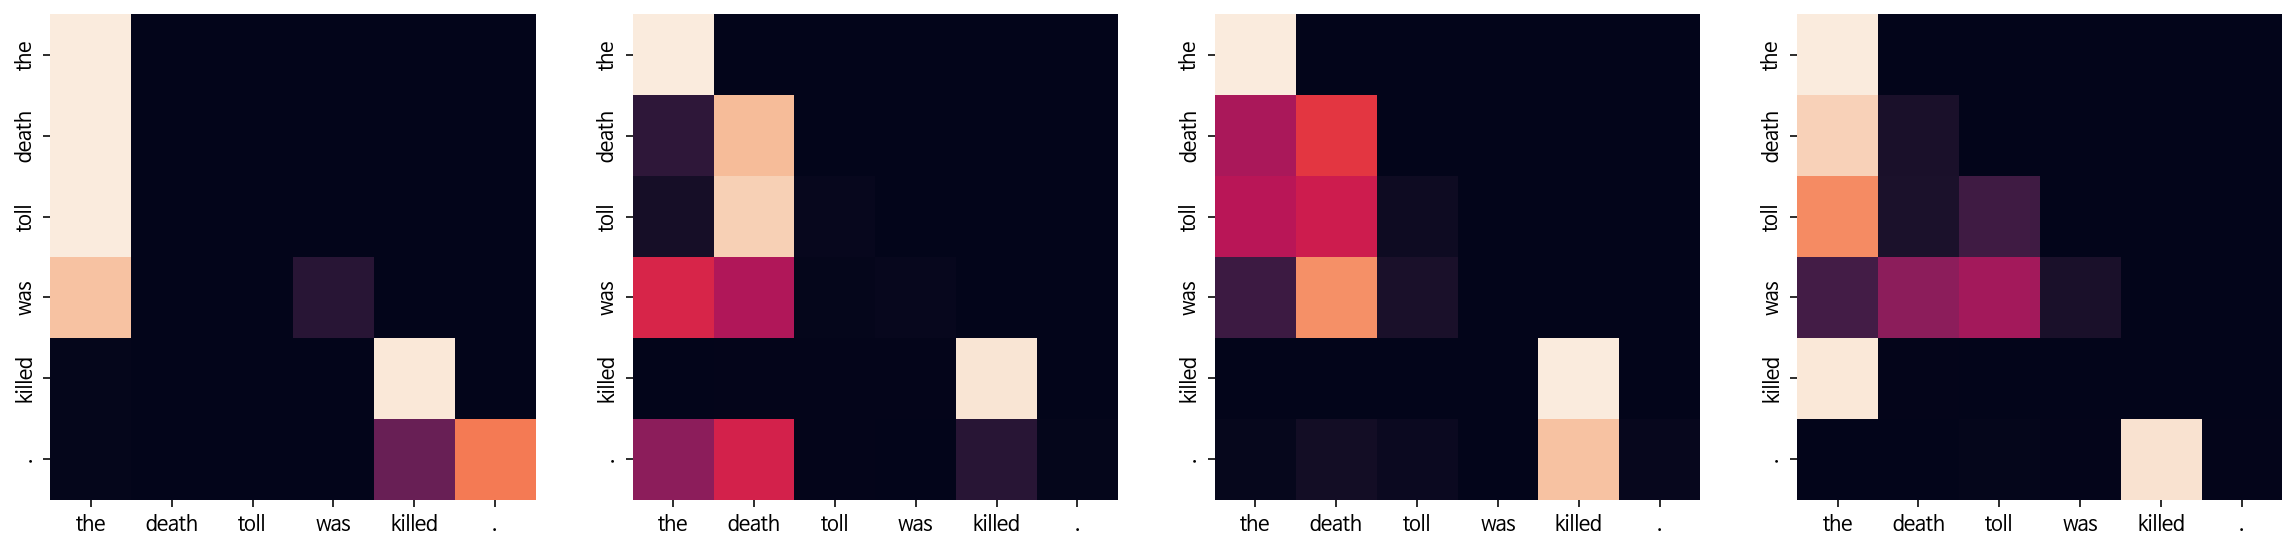

Decoder Src Layer 2


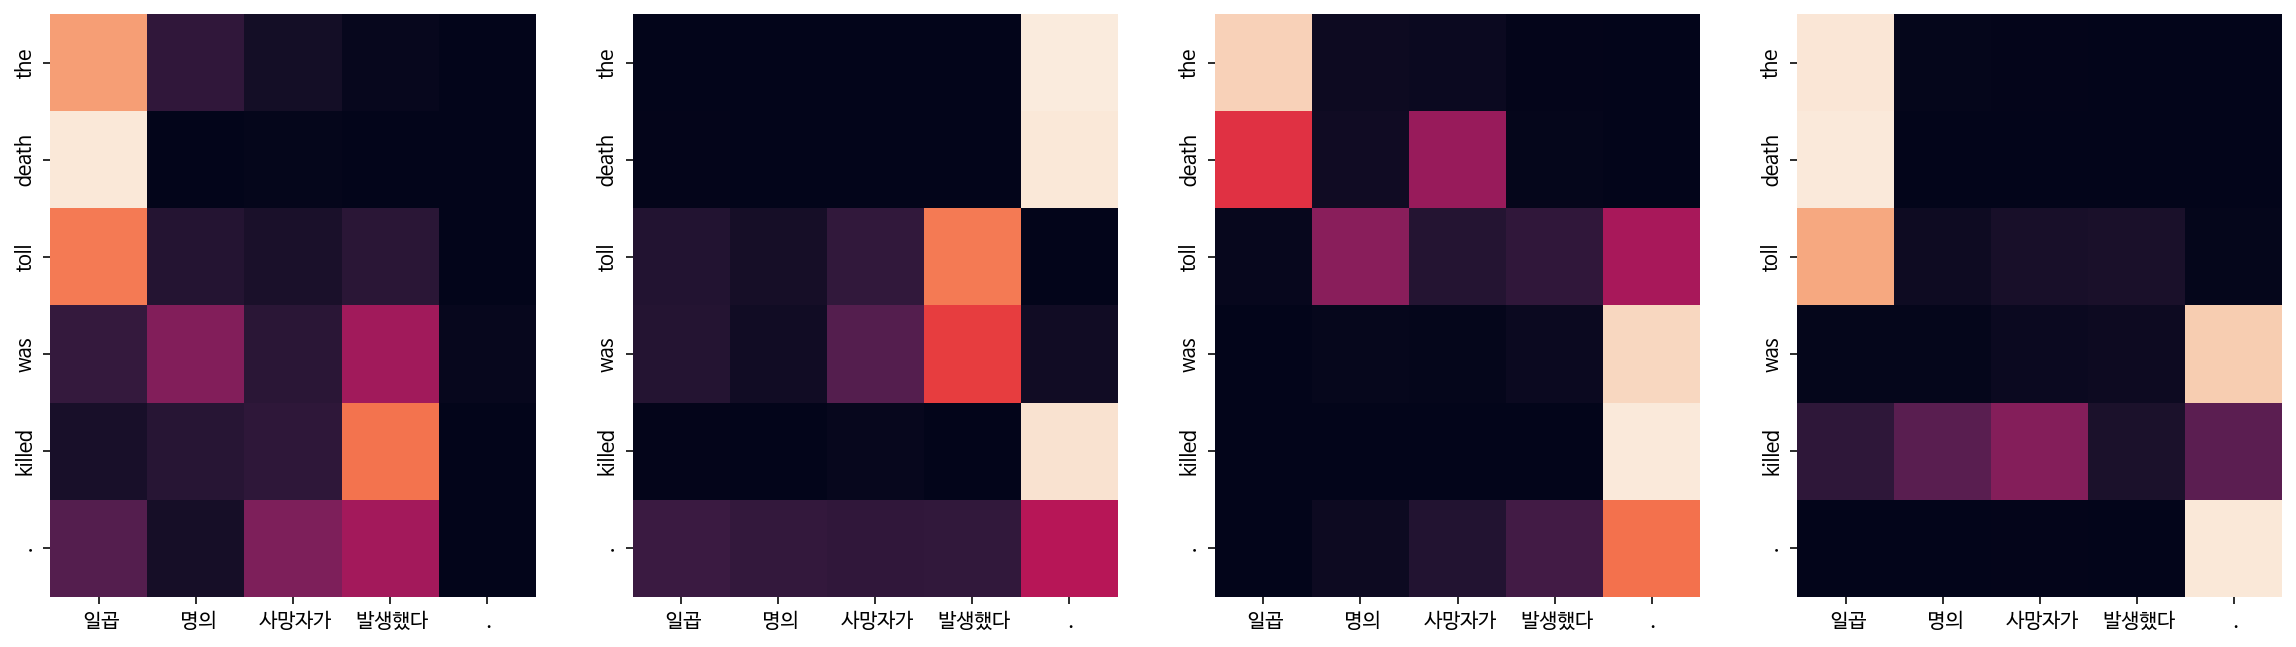

  0%|          | 0/1174 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Encoder Layer 1


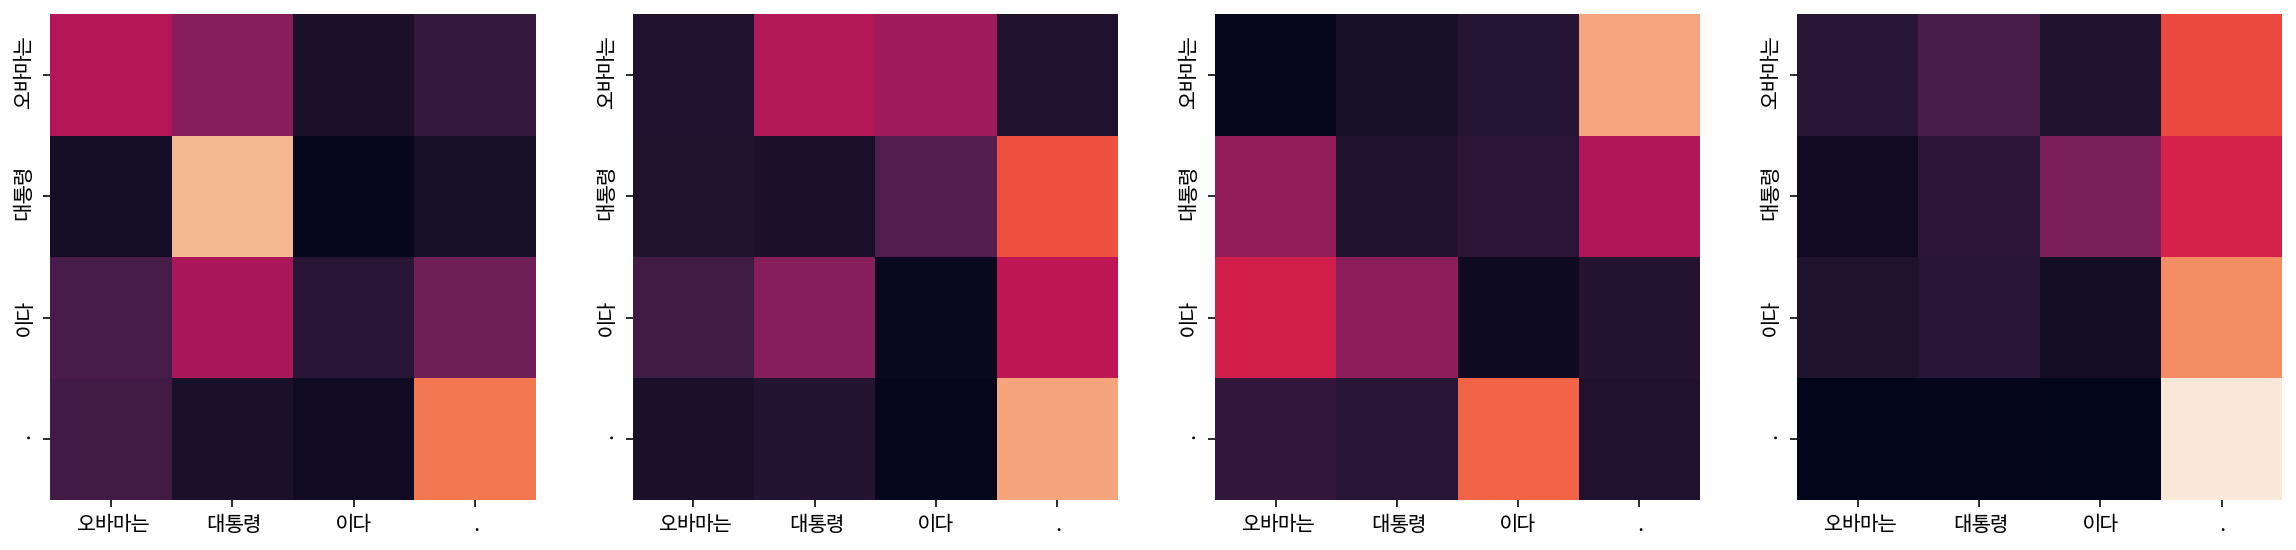

Encoder Layer 2


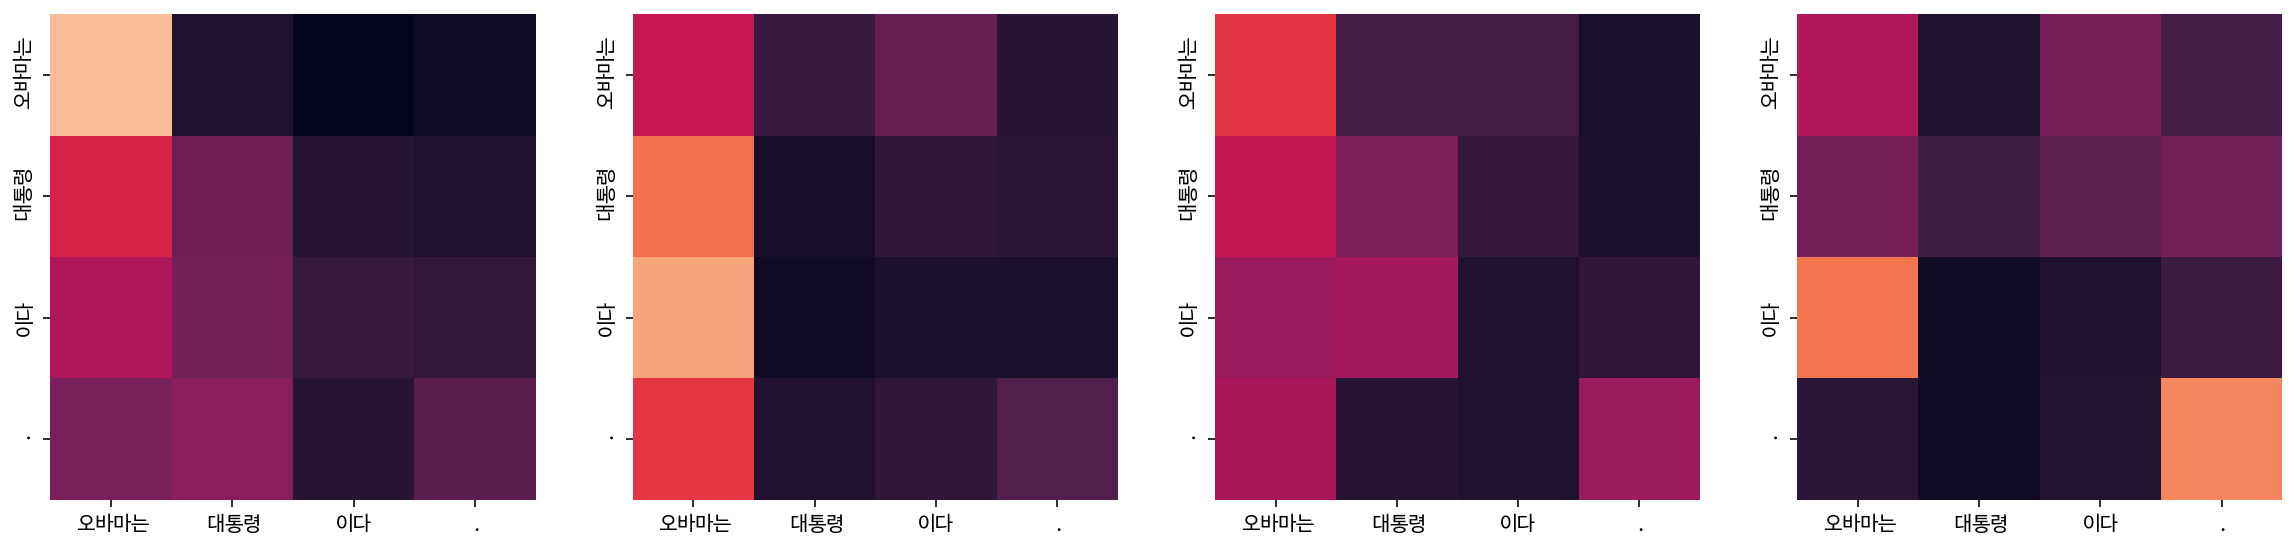

Decoder Self Layer 1


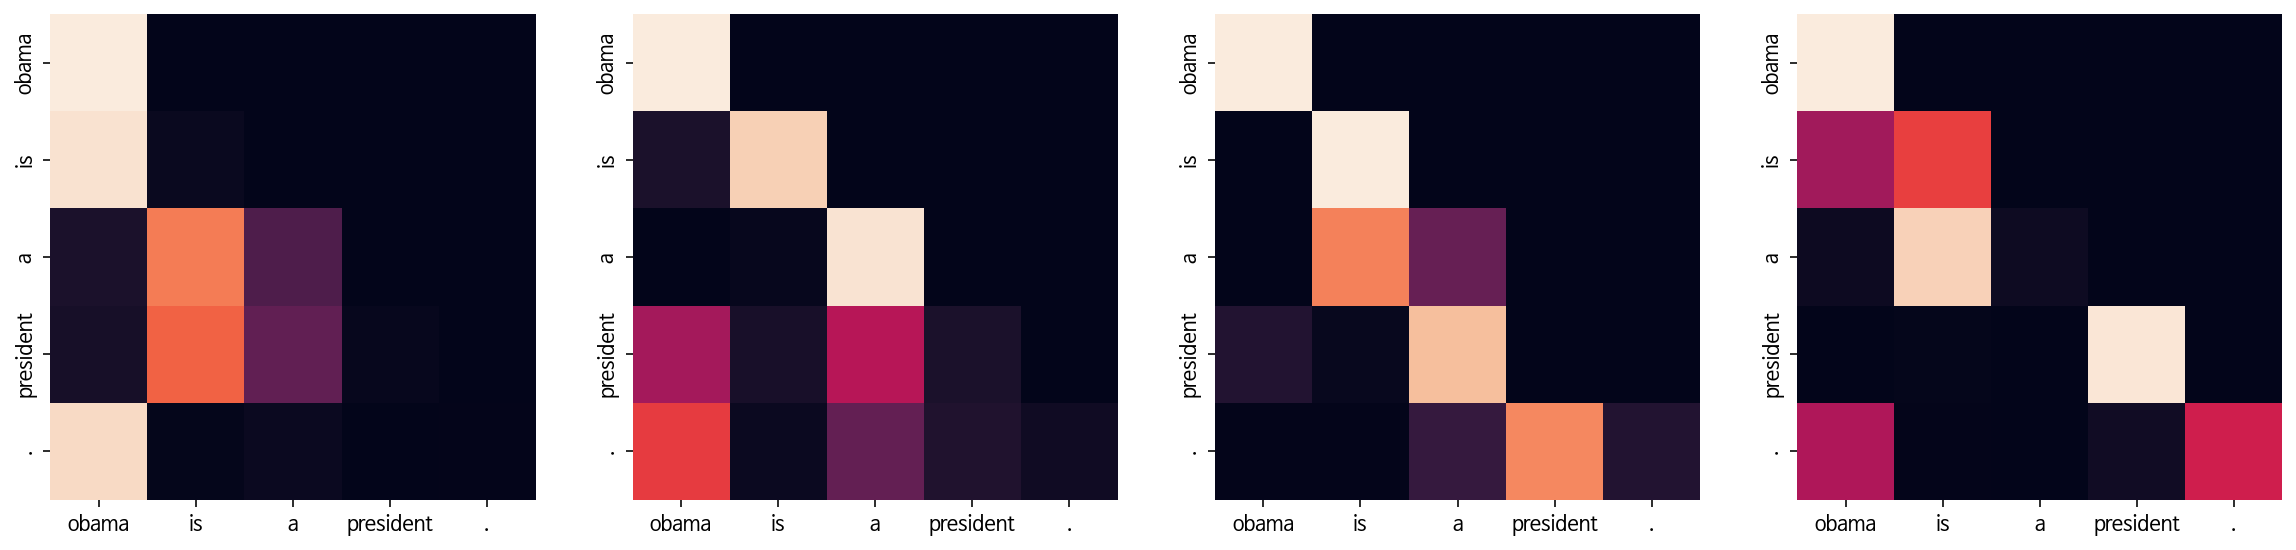

Decoder Src Layer 1


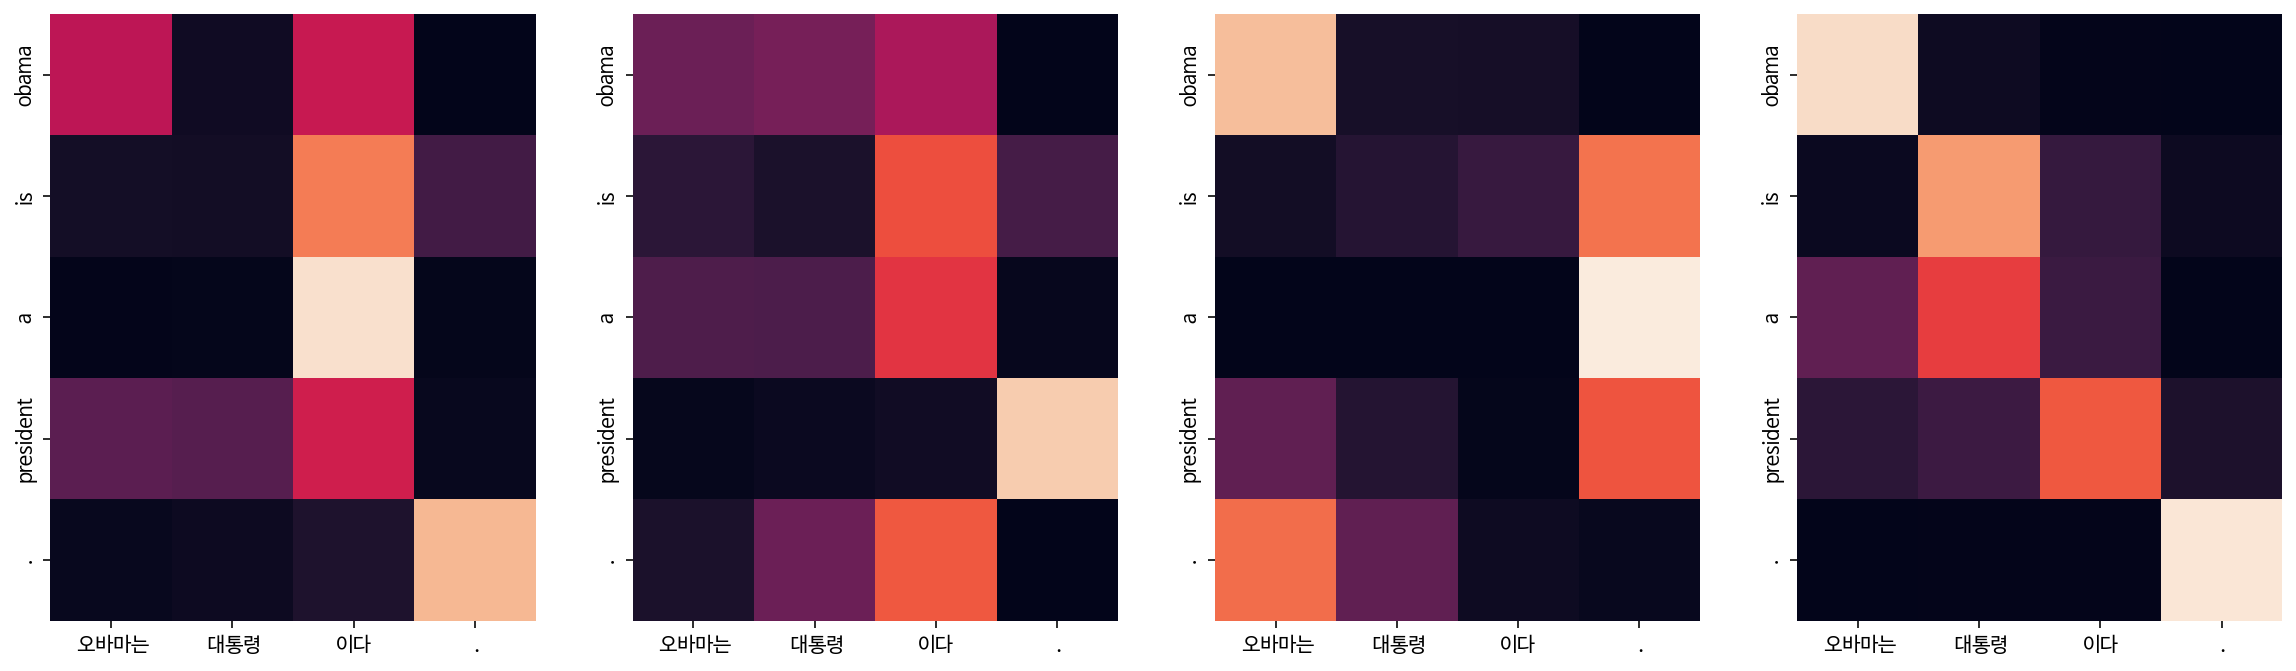

Decoder Self Layer 2


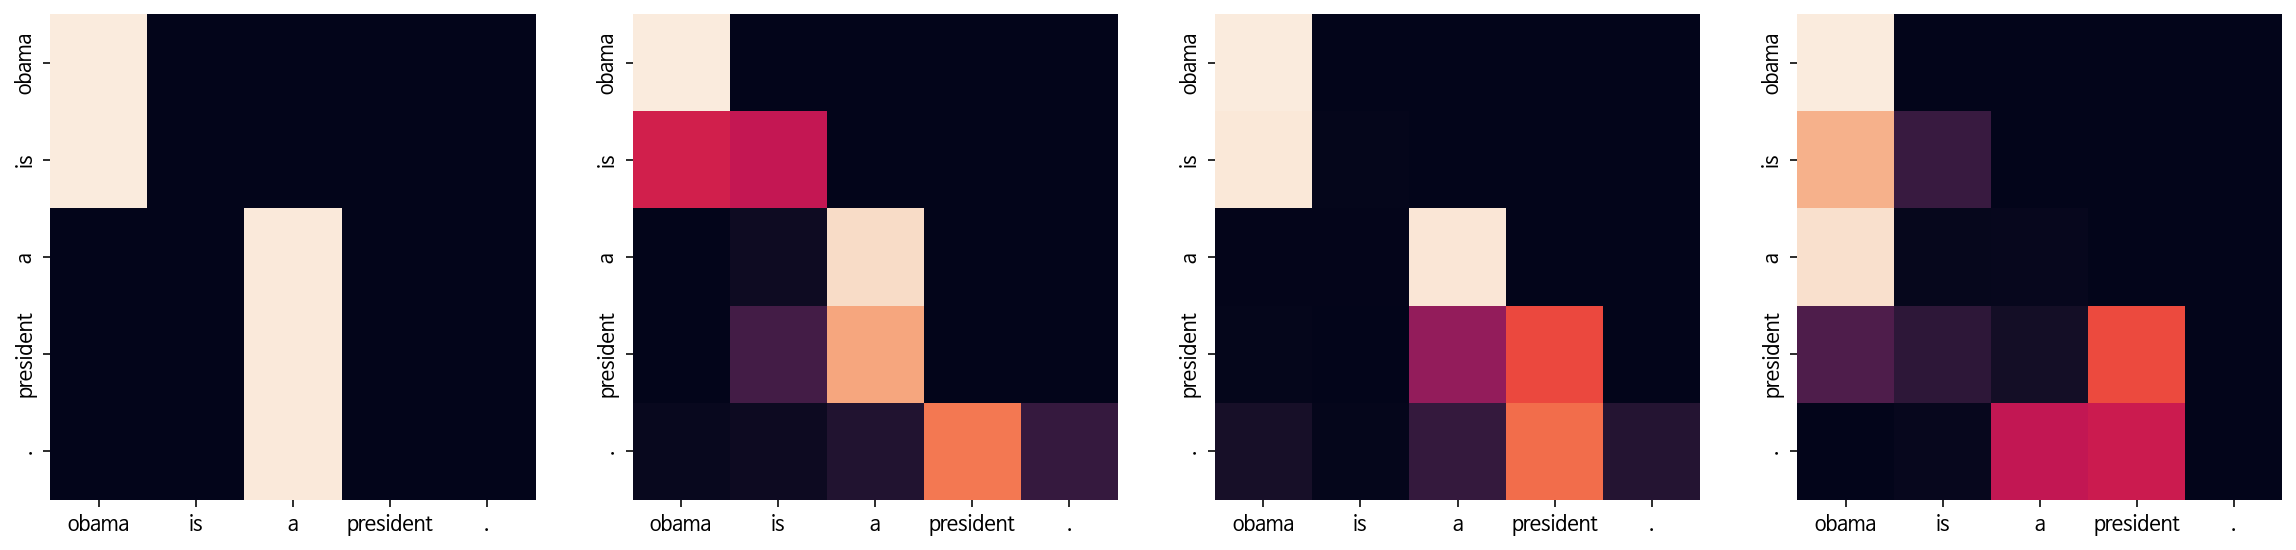

Decoder Src Layer 2


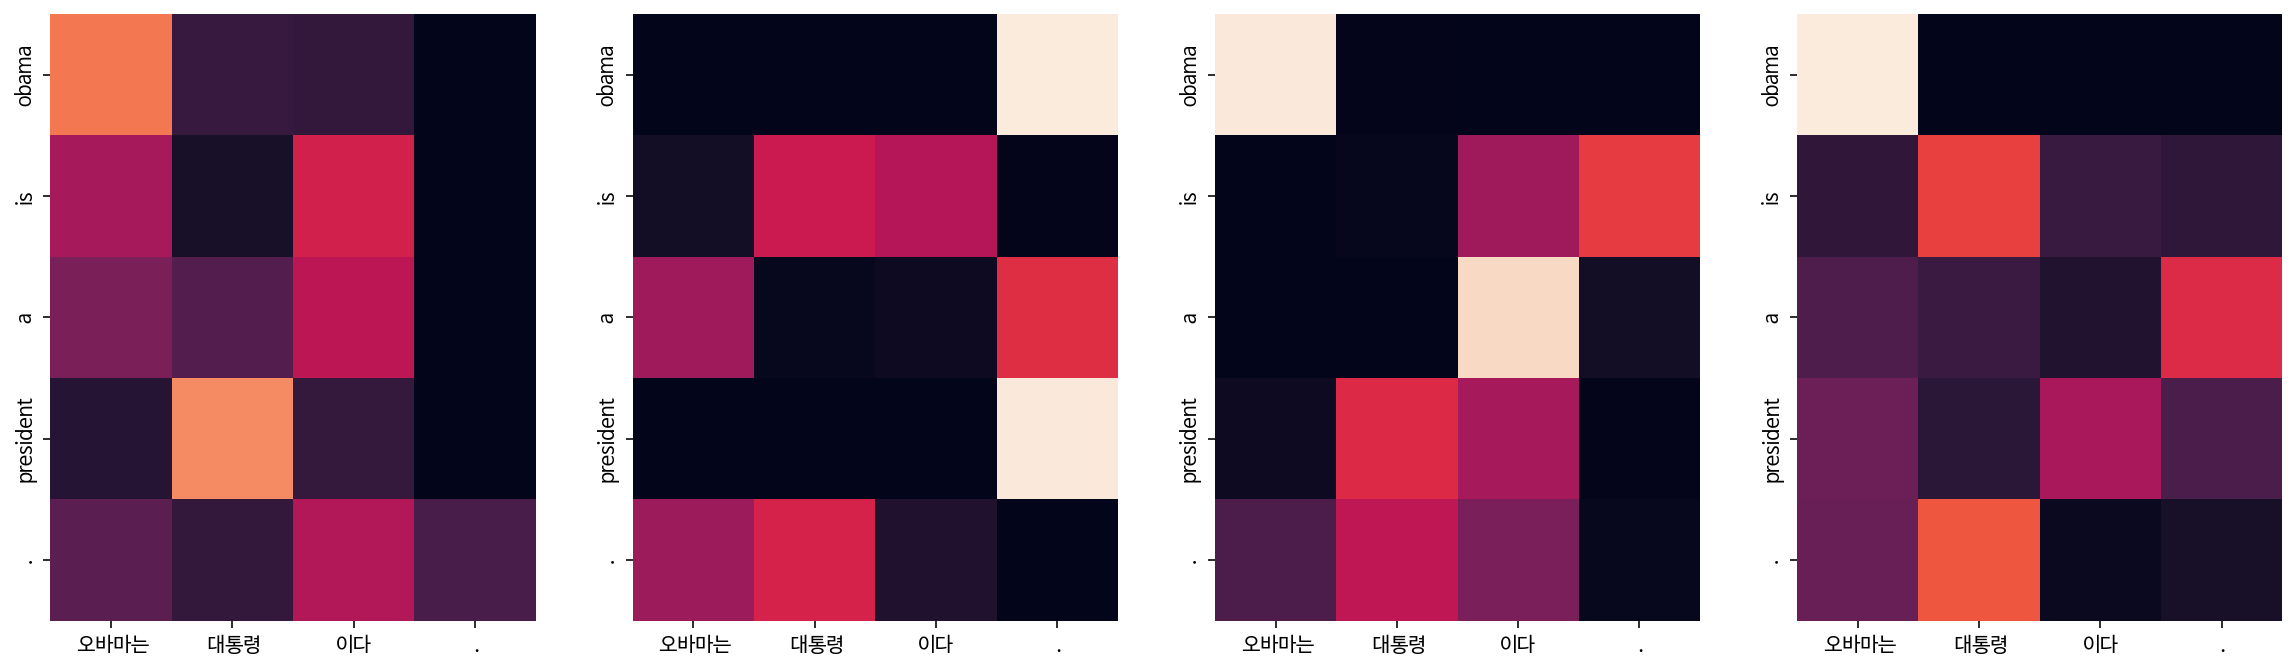

Input: 시민들은 도시 속에 산다.
Predicted translation: the cities of the city of cities are
Encoder Layer 1


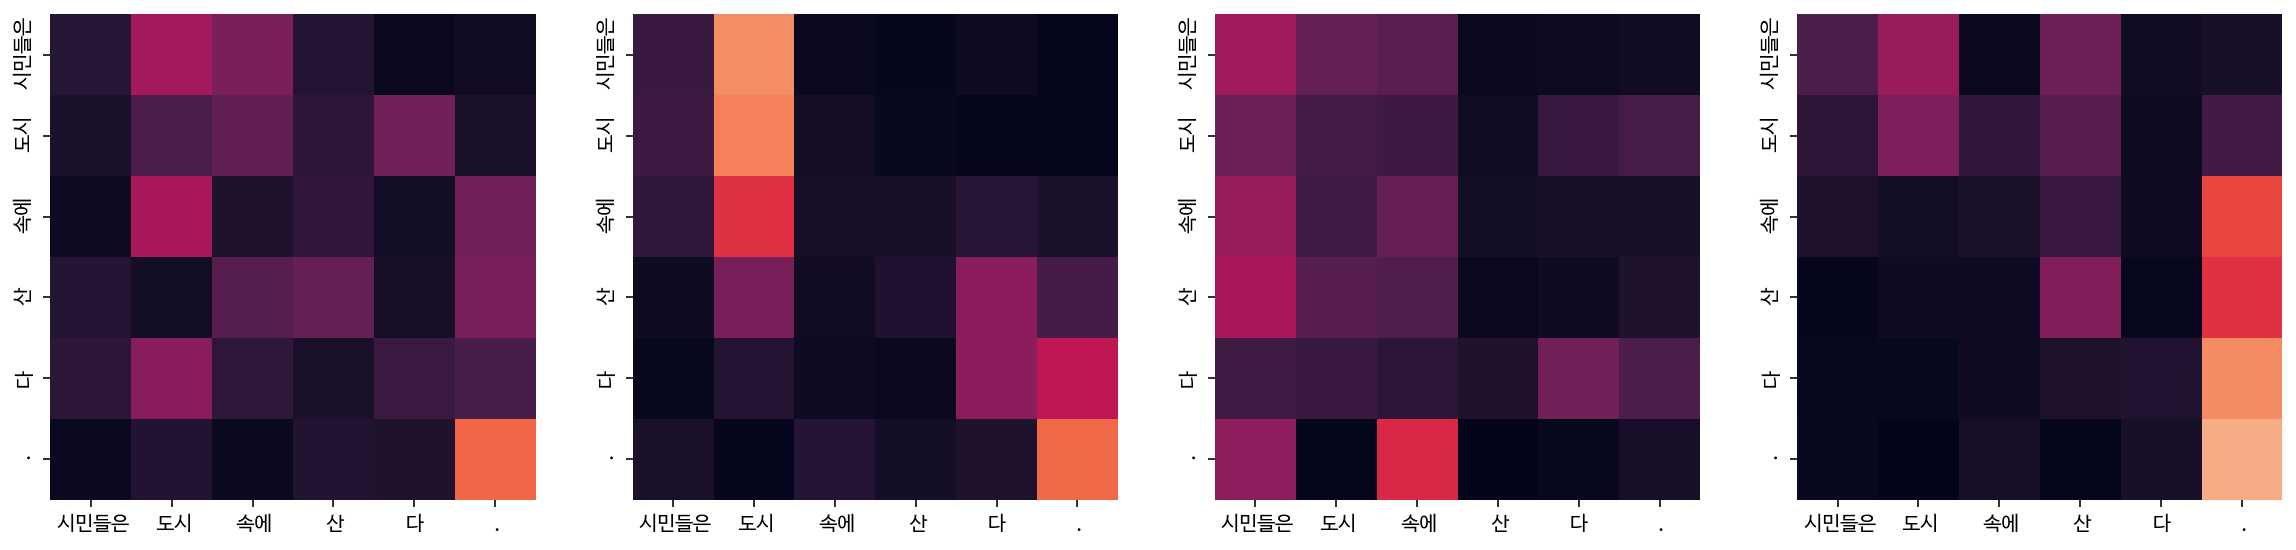

Encoder Layer 2


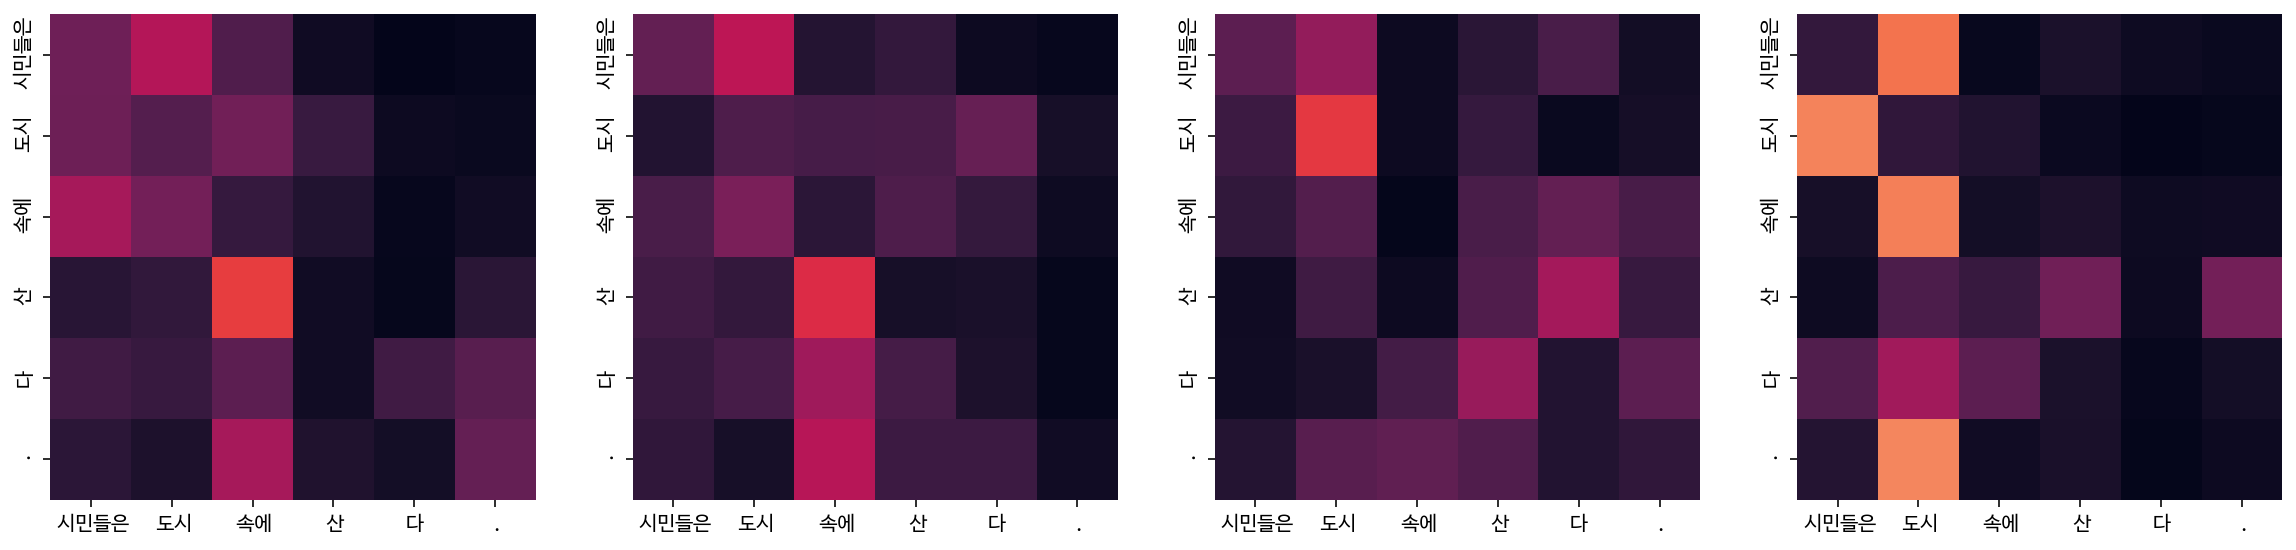

Decoder Self Layer 1


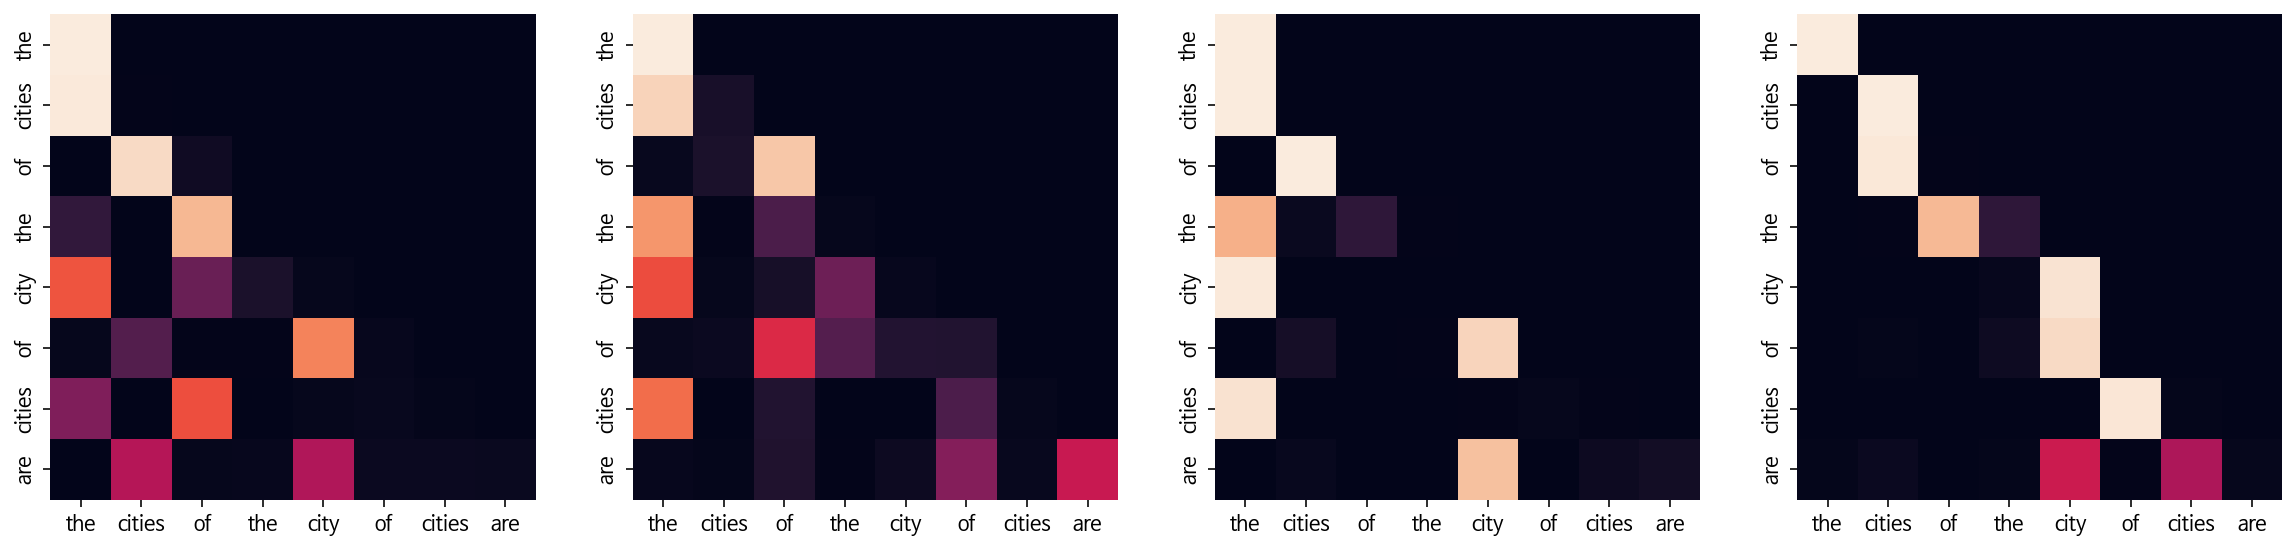

Decoder Src Layer 1


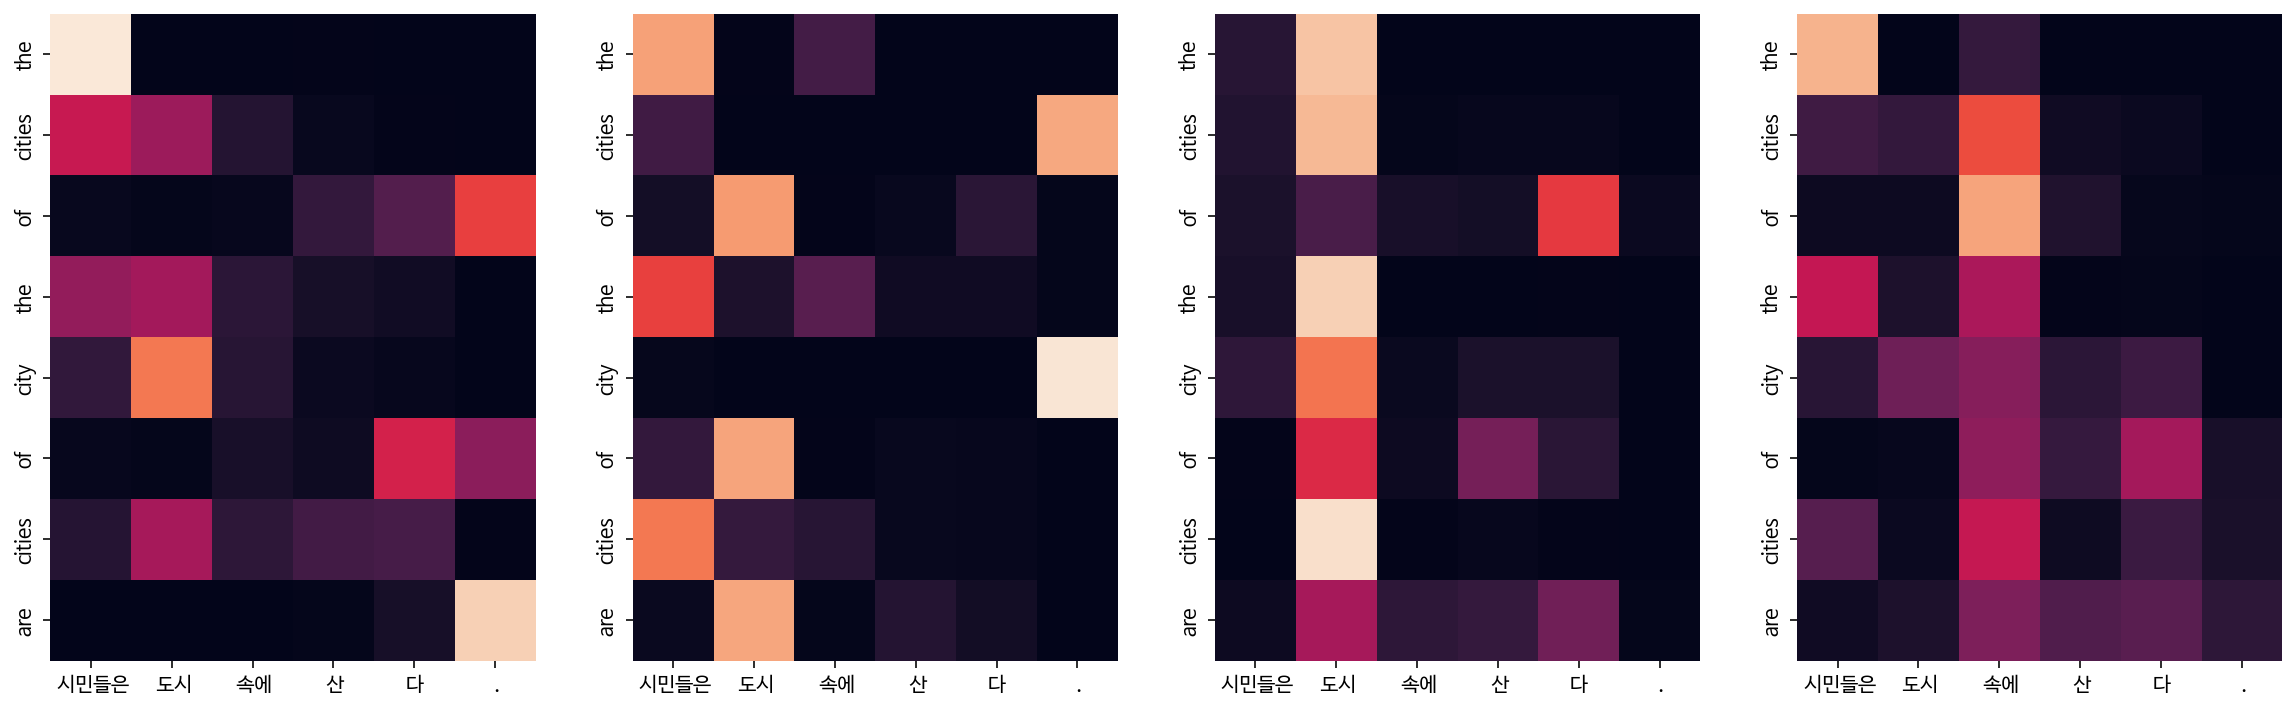

Decoder Self Layer 2


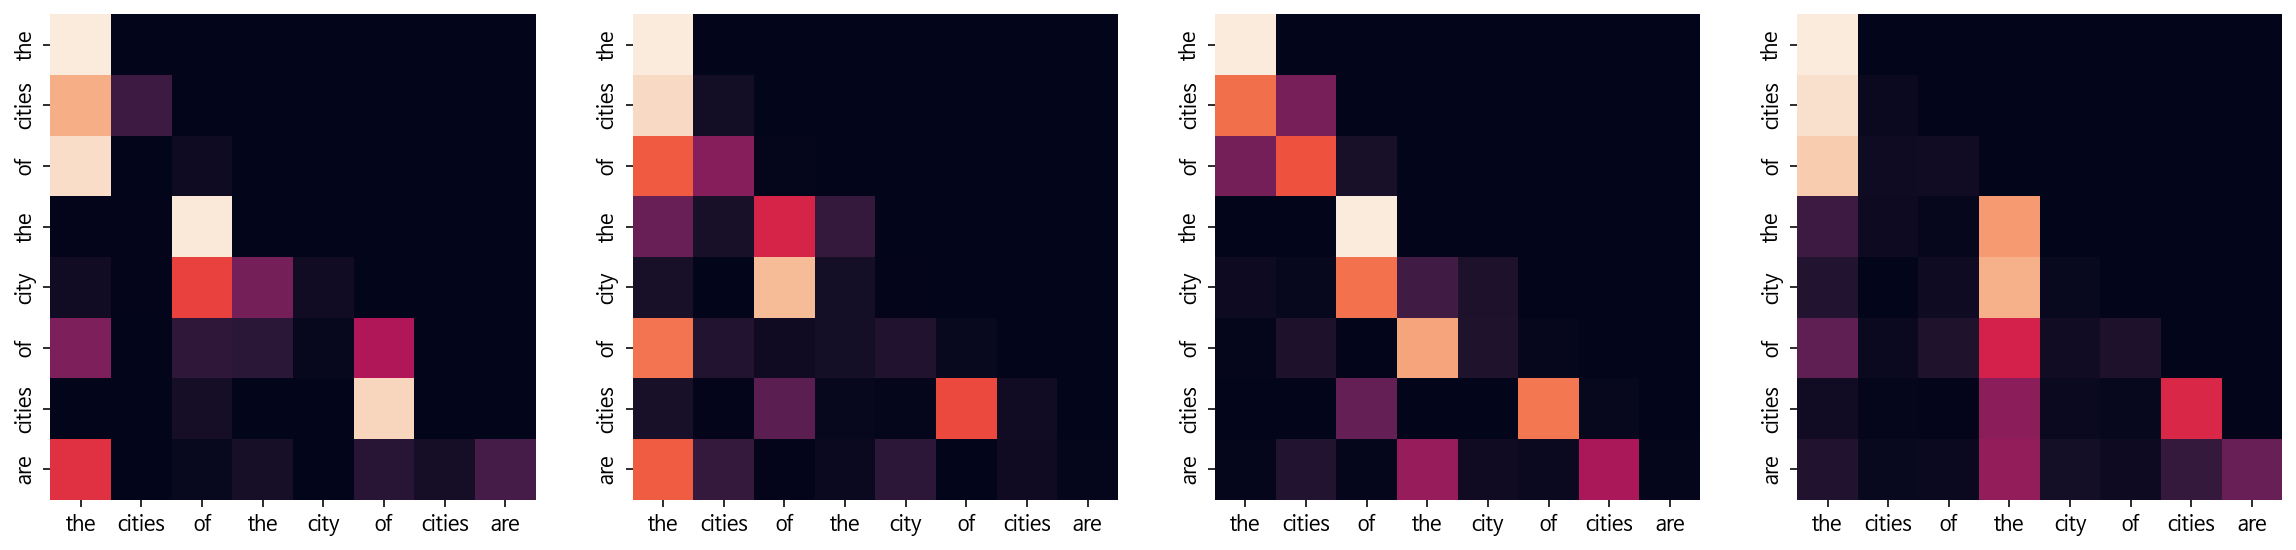

Decoder Src Layer 2


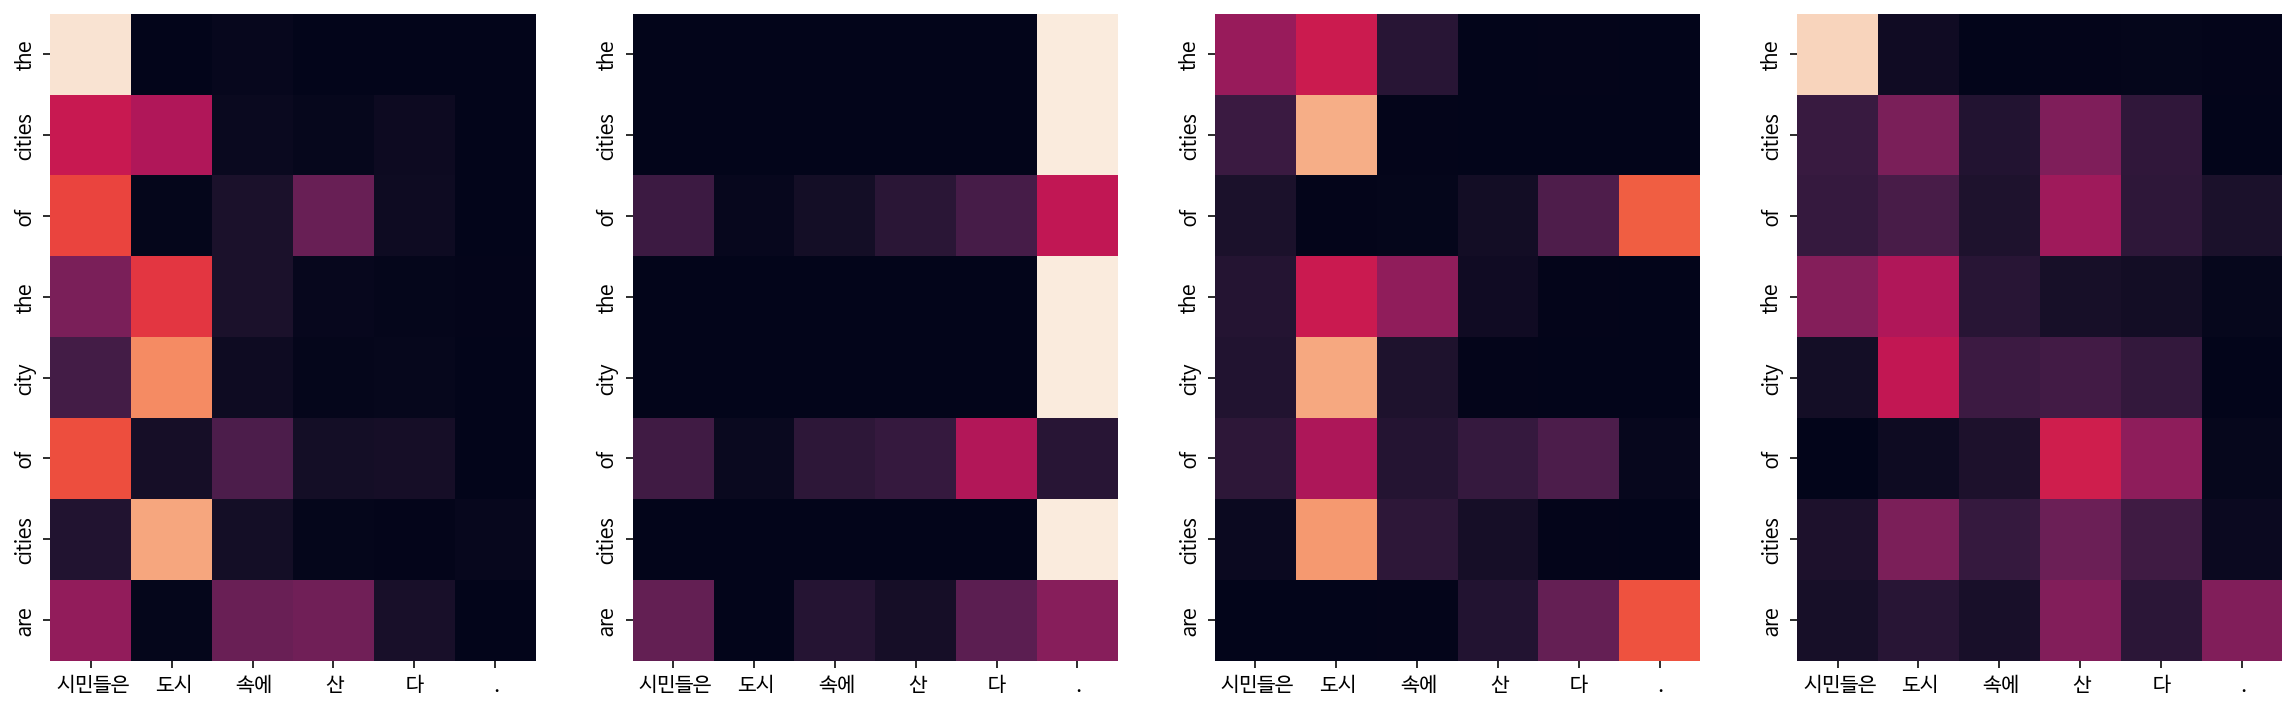

Input: 커피는 필요 없다.
Predicted translation: there are no risk .
Encoder Layer 1


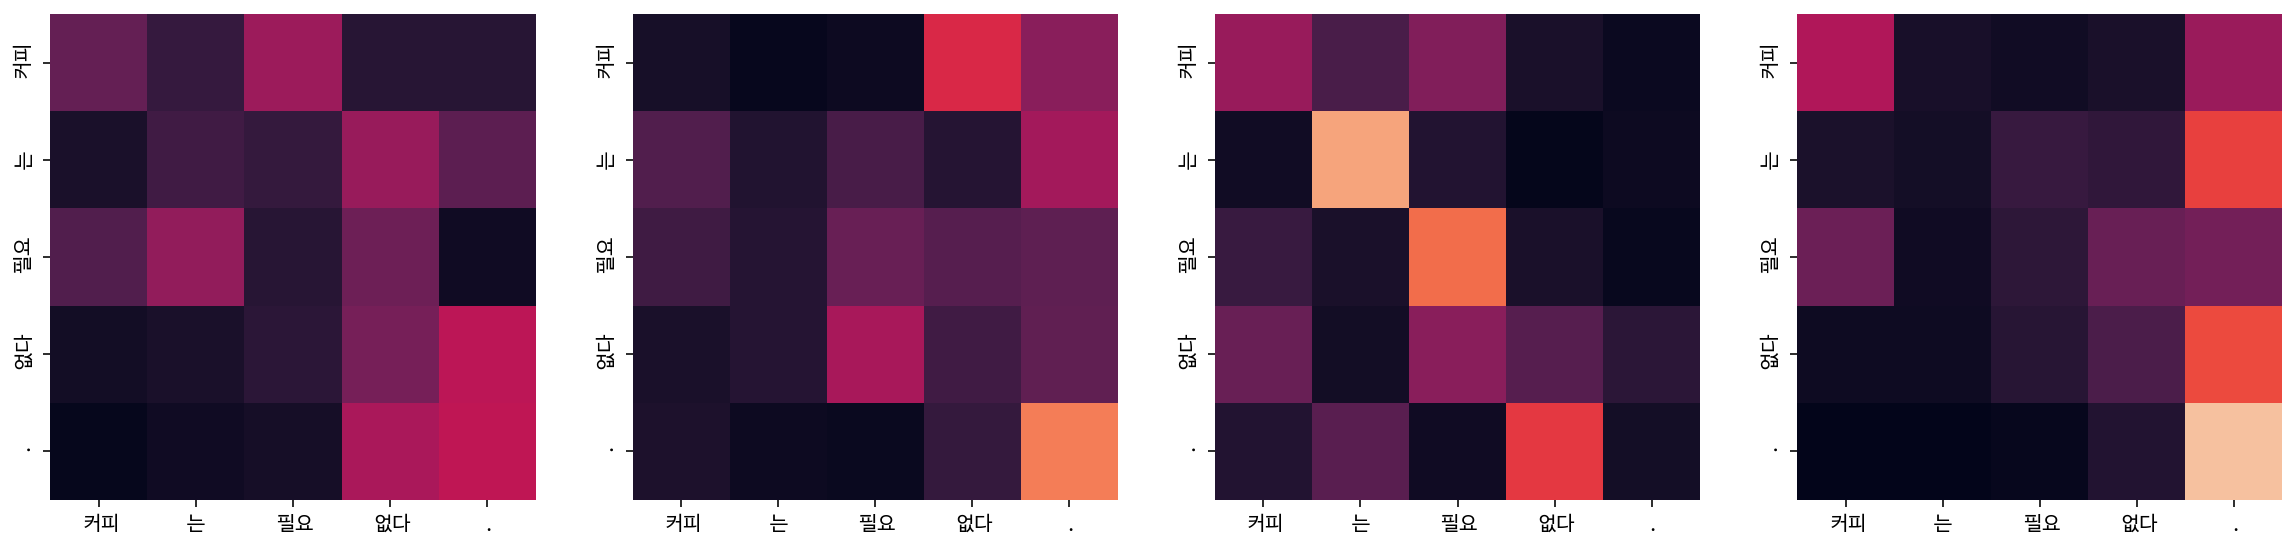

Encoder Layer 2


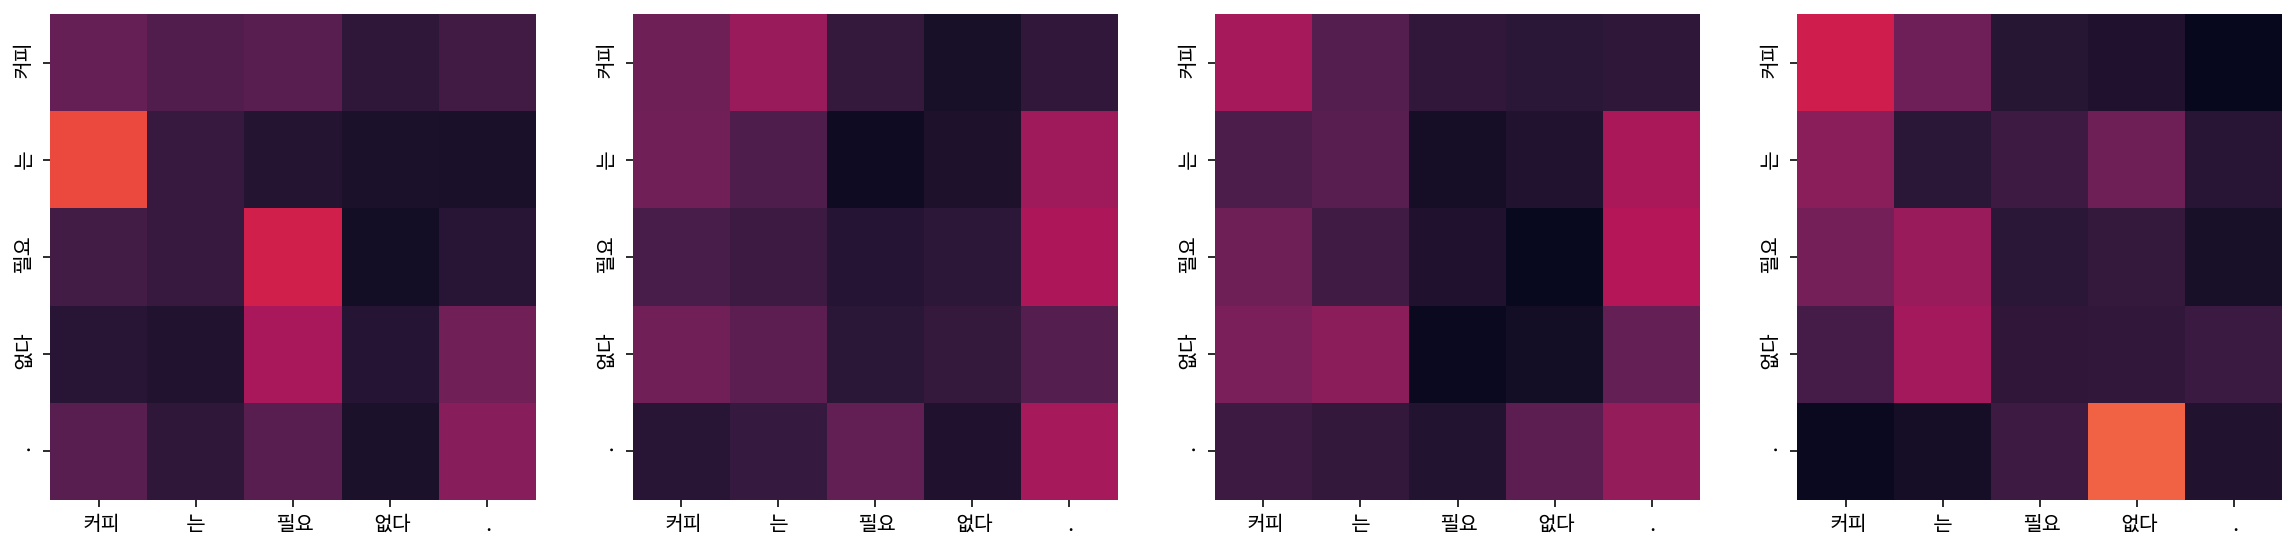

Decoder Self Layer 1


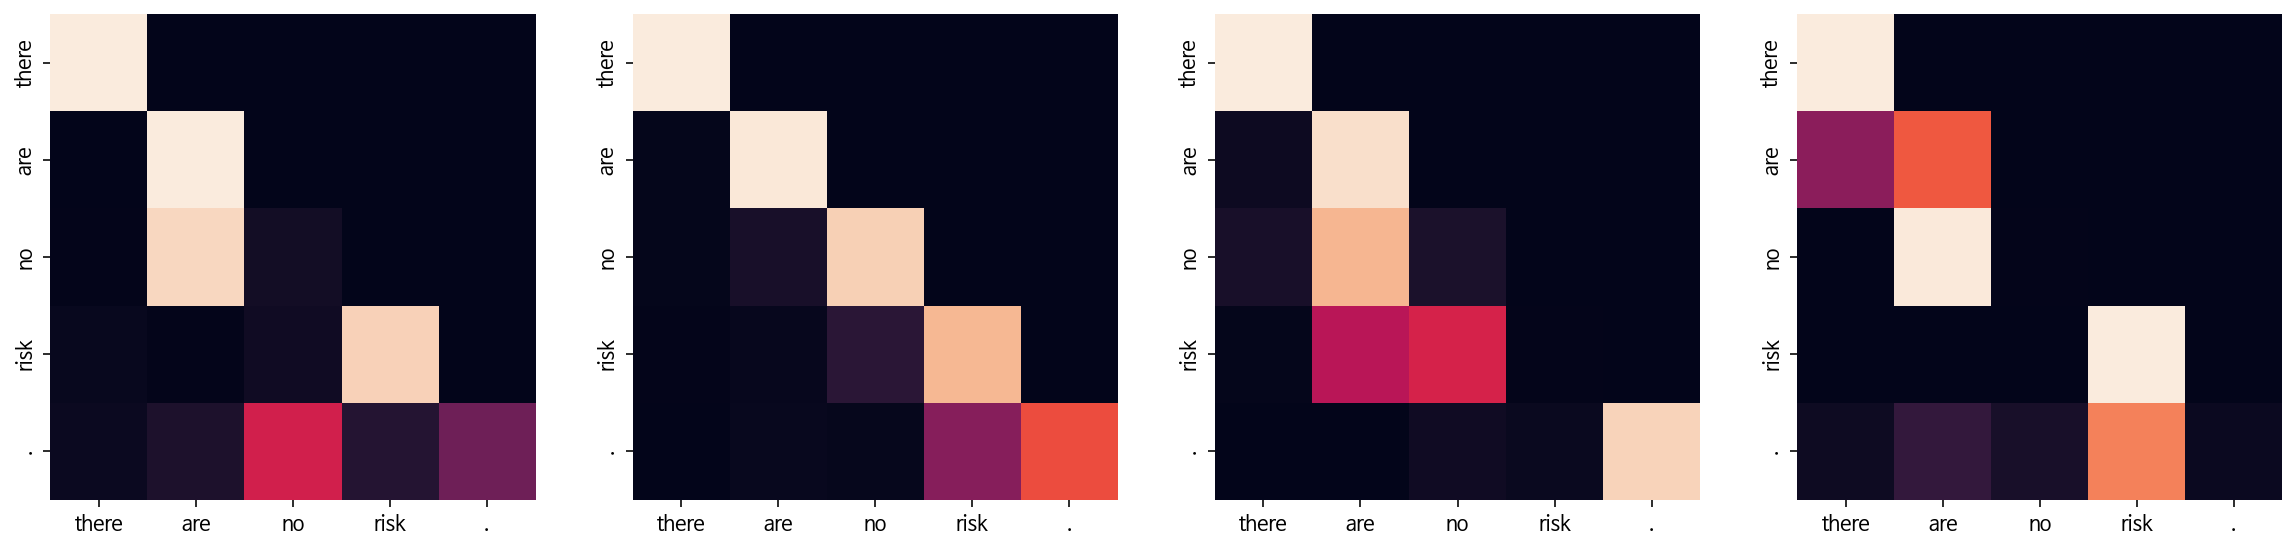

Decoder Src Layer 1


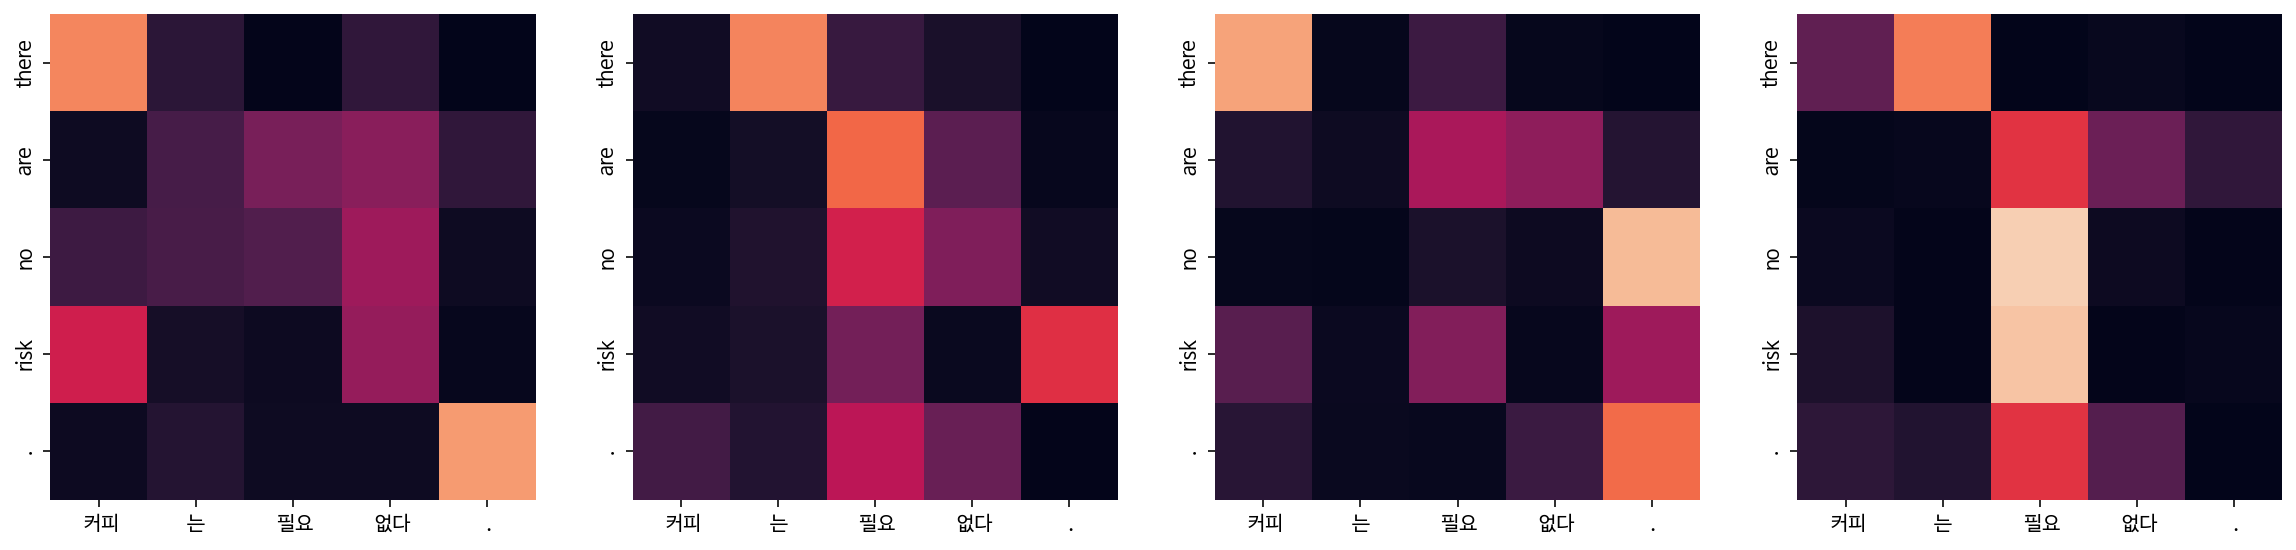

Decoder Self Layer 2


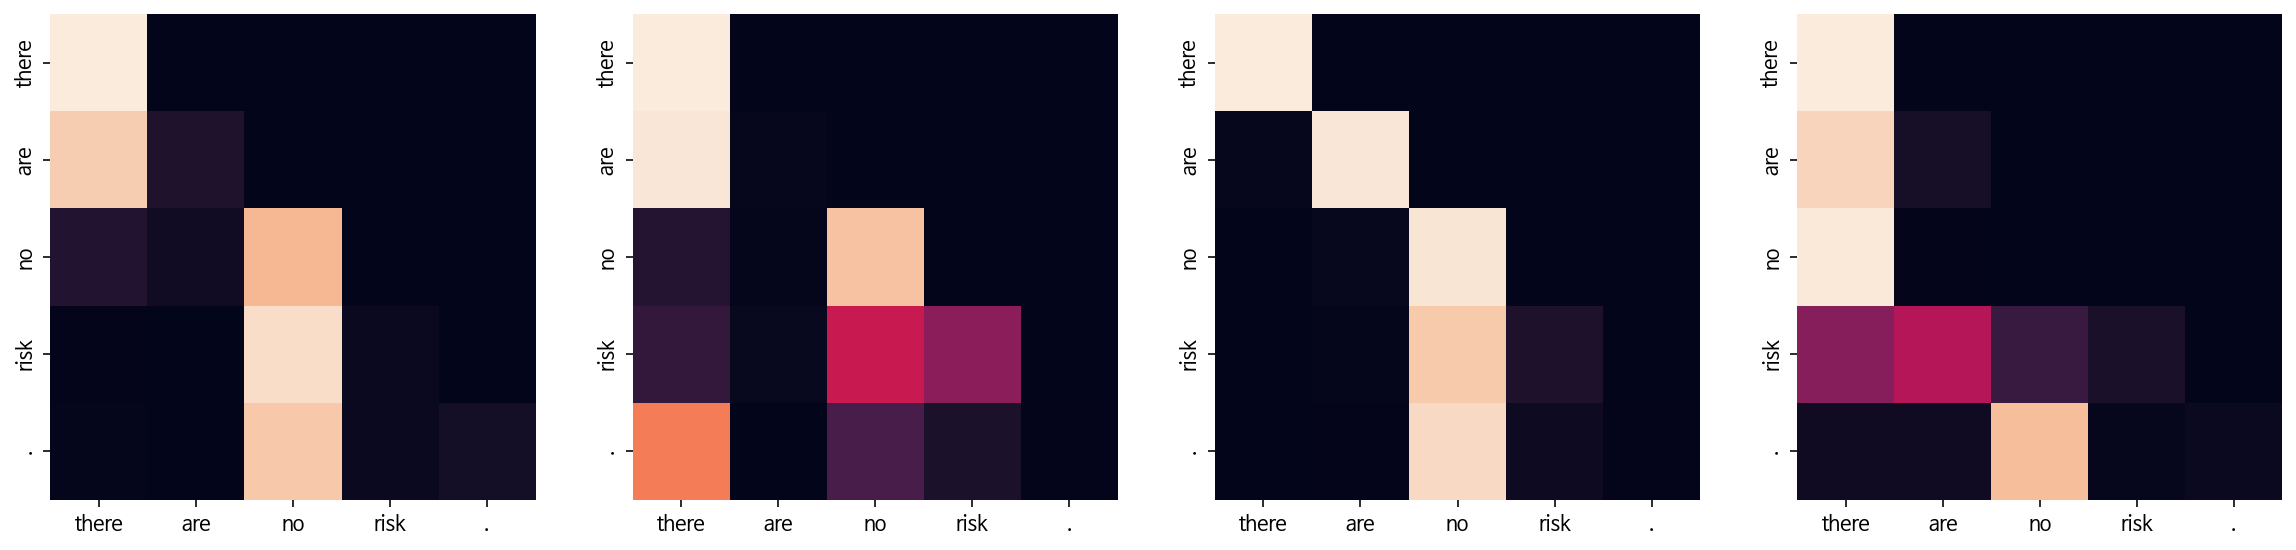

Decoder Src Layer 2


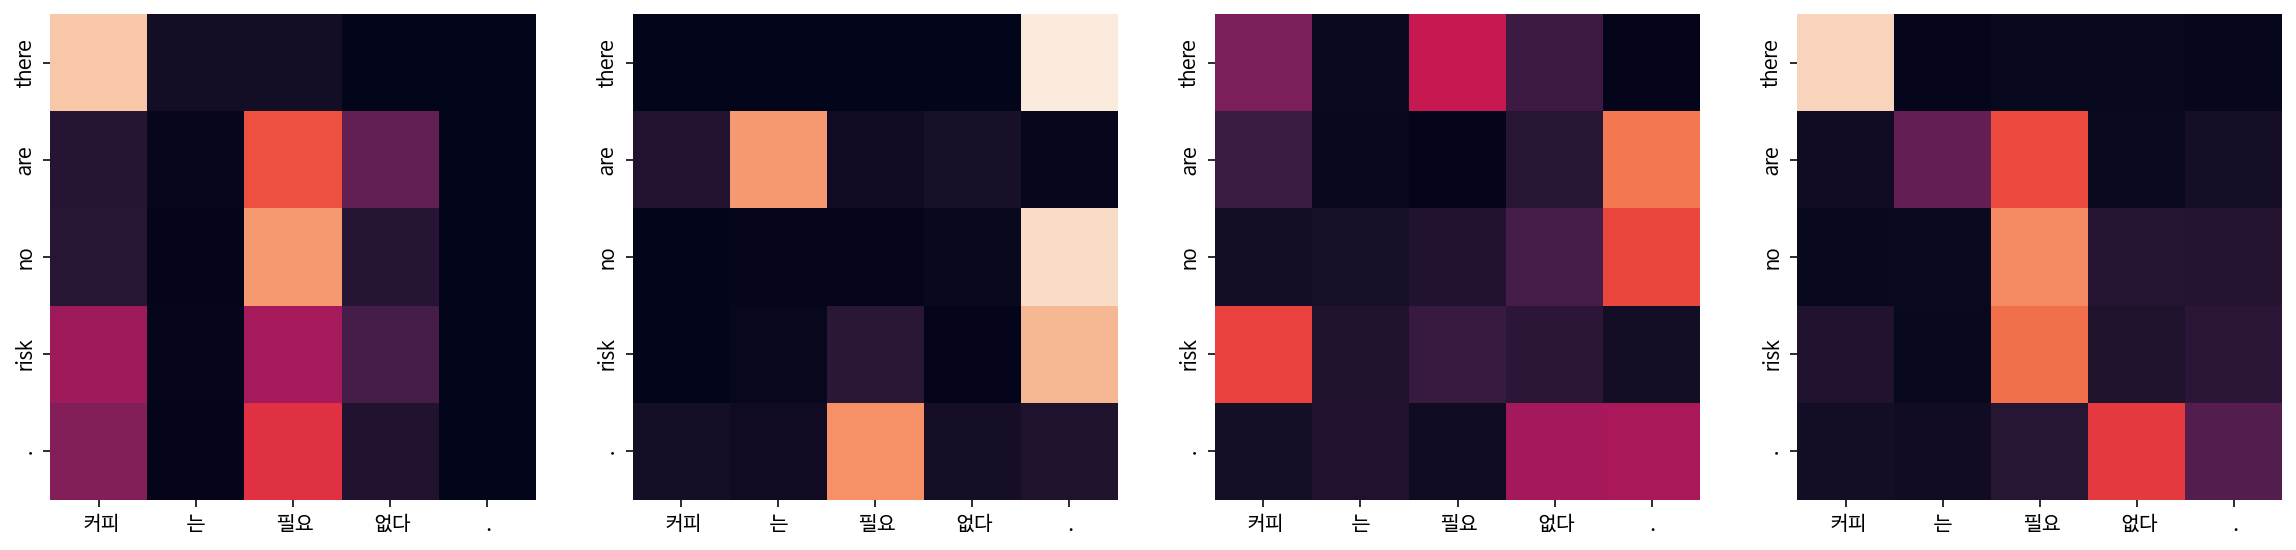

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .
Encoder Layer 1


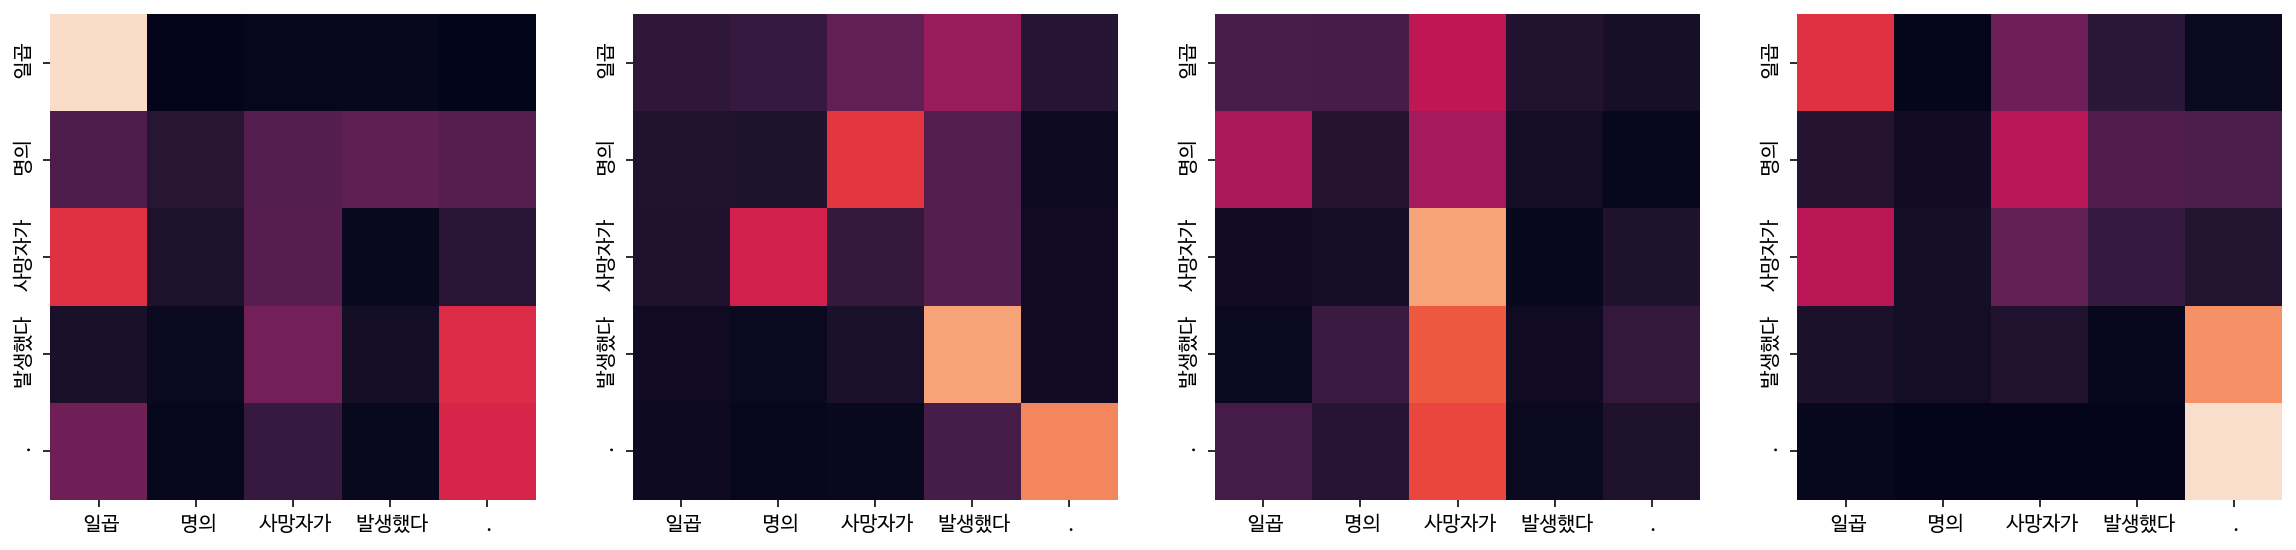

Encoder Layer 2


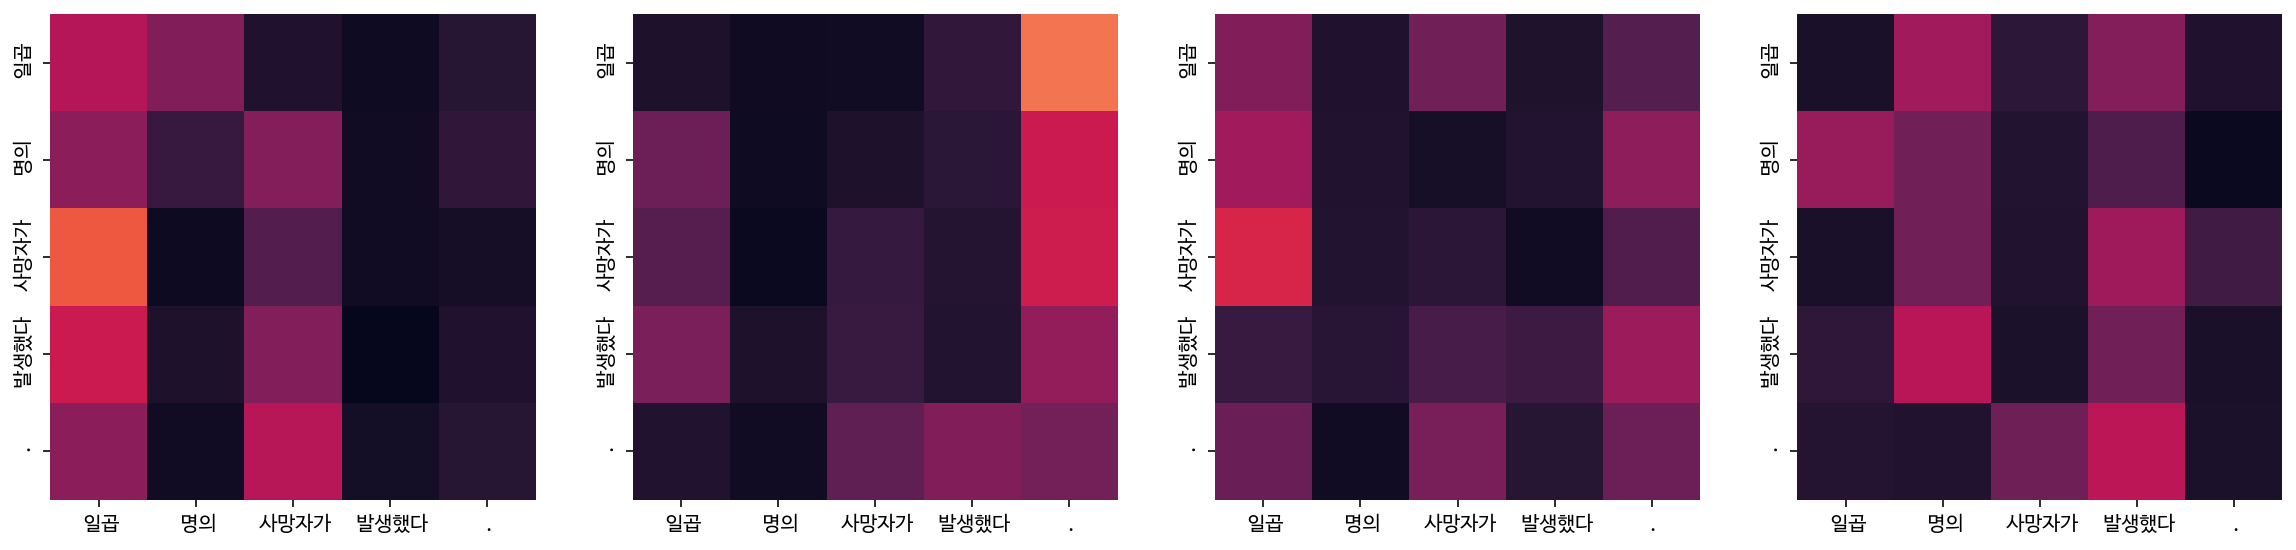

Decoder Self Layer 1


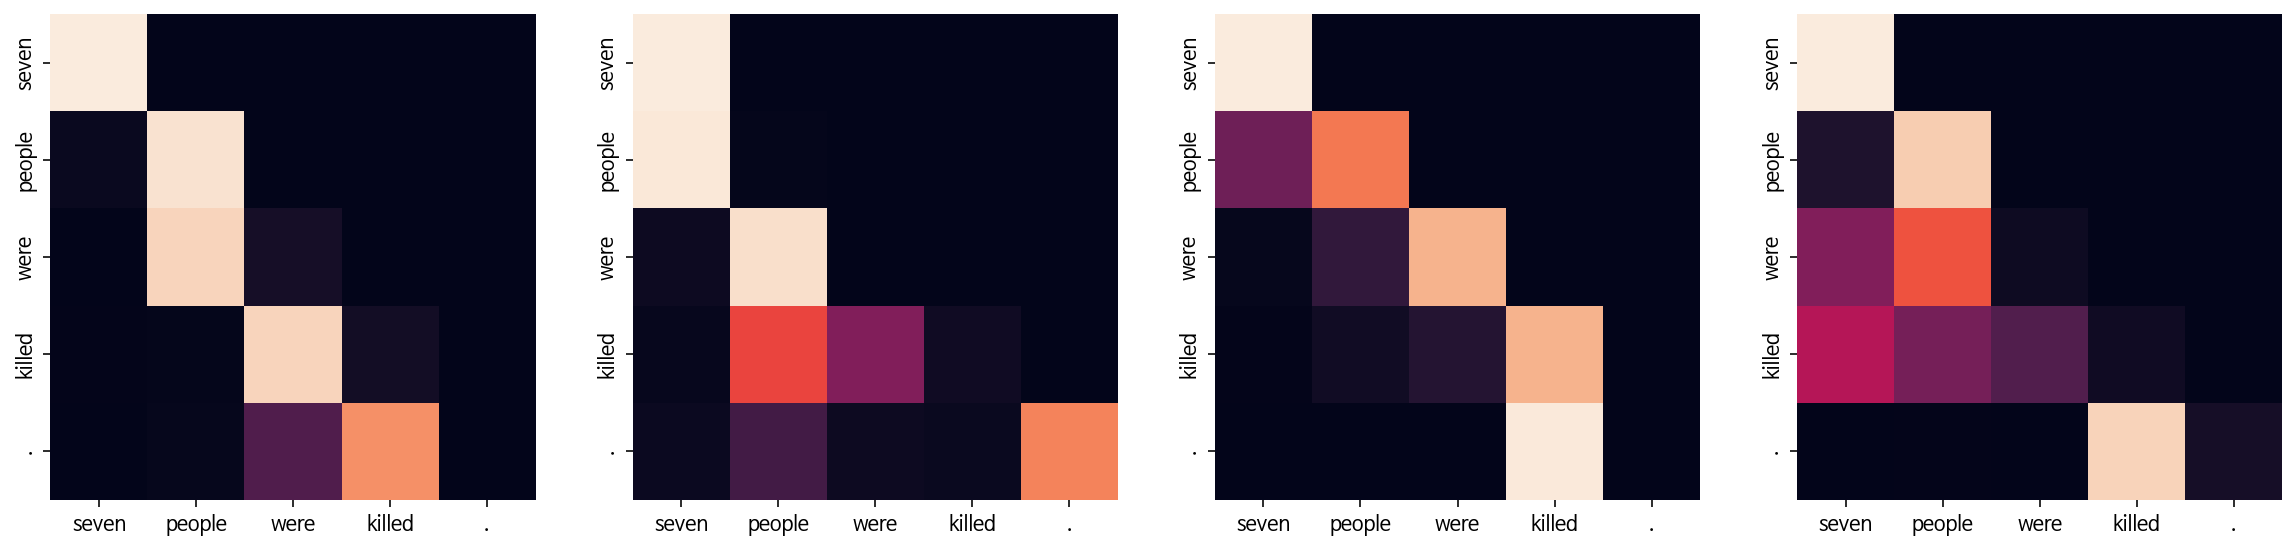

Decoder Src Layer 1


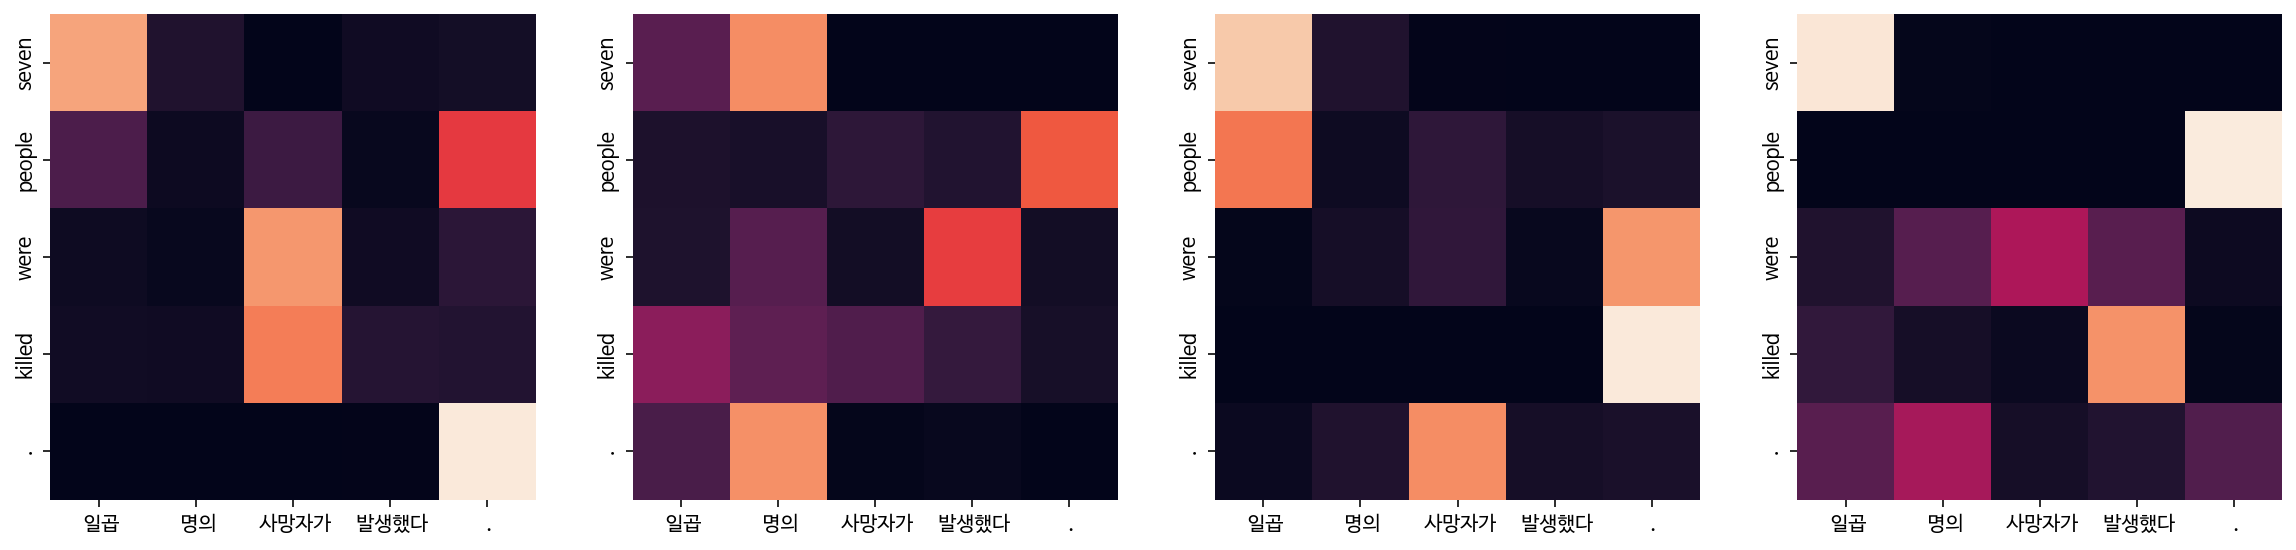

Decoder Self Layer 2


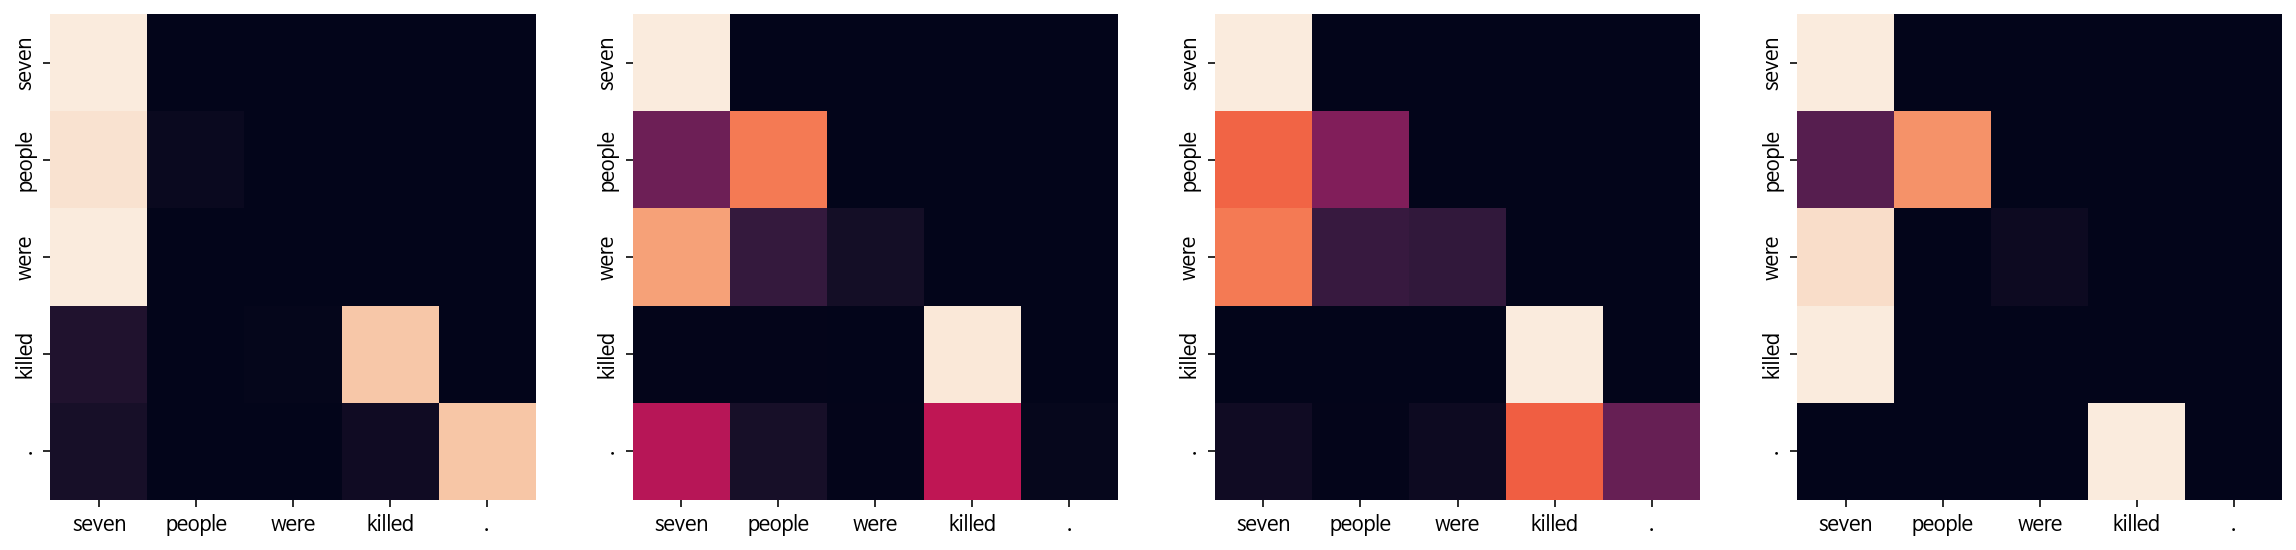

Decoder Src Layer 2


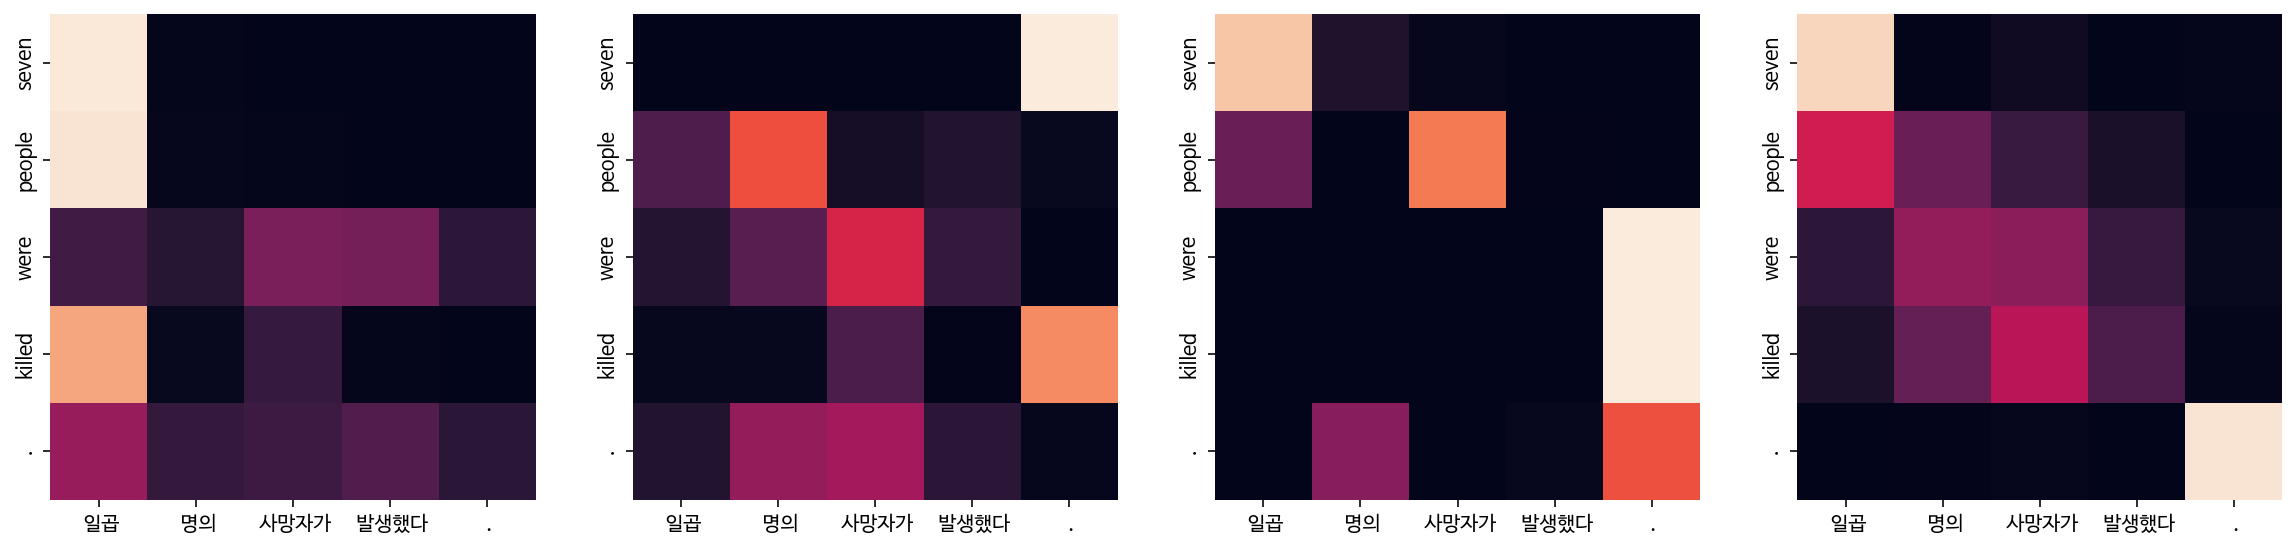

  0%|          | 0/1174 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Encoder Layer 1


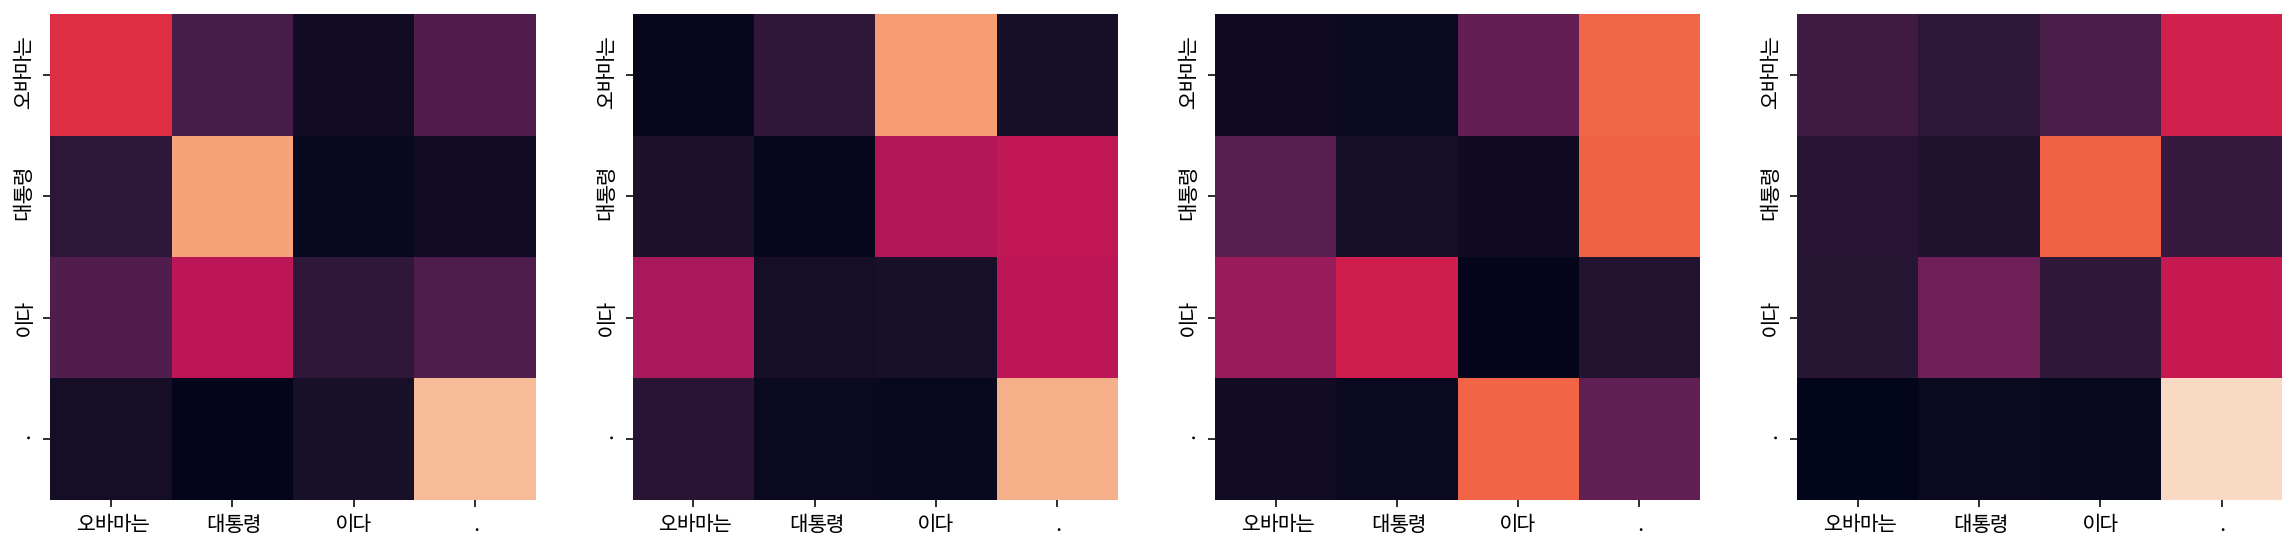

Encoder Layer 2


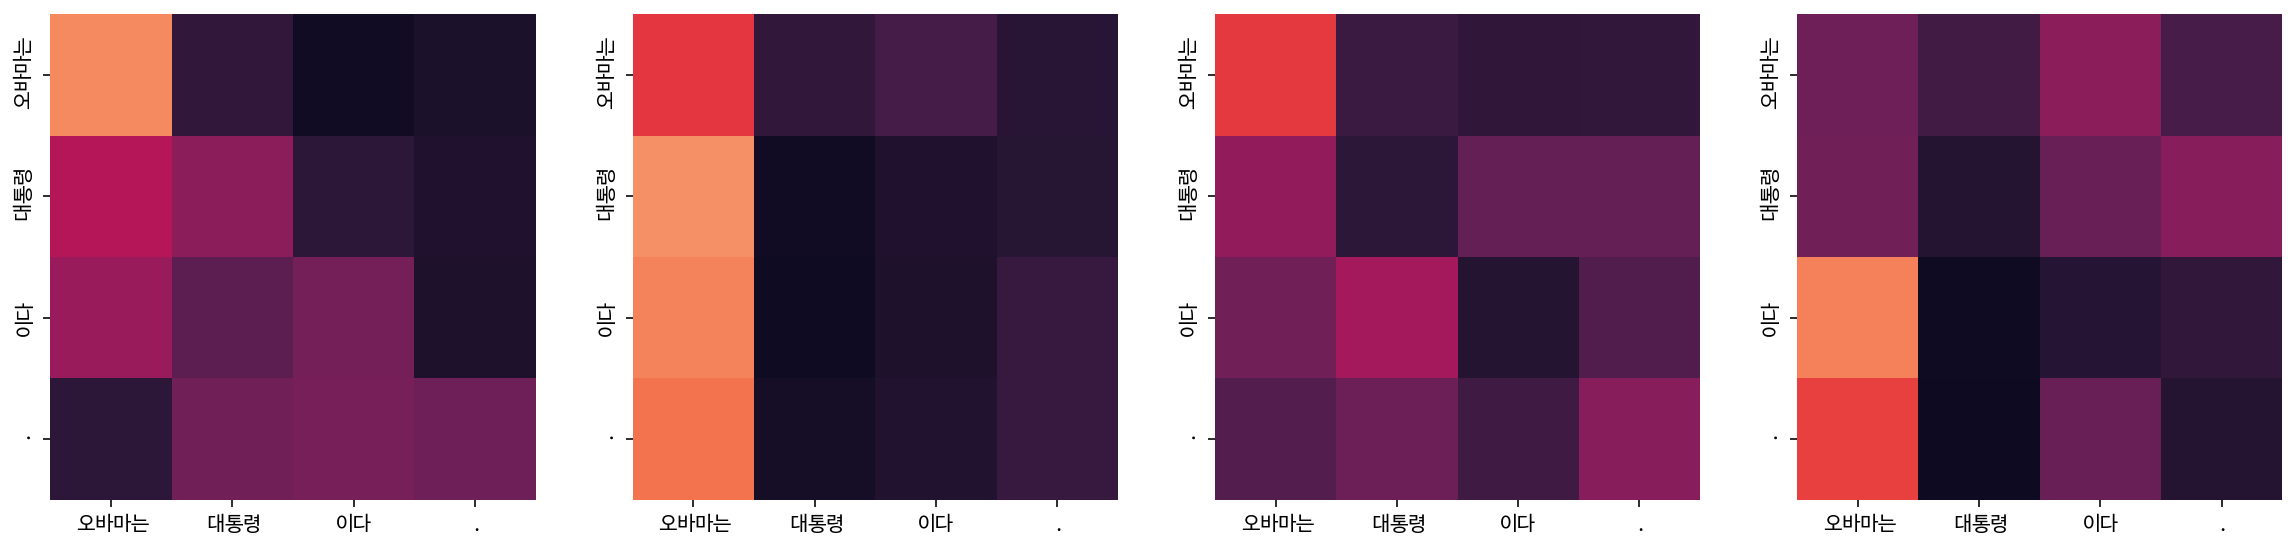

Decoder Self Layer 1


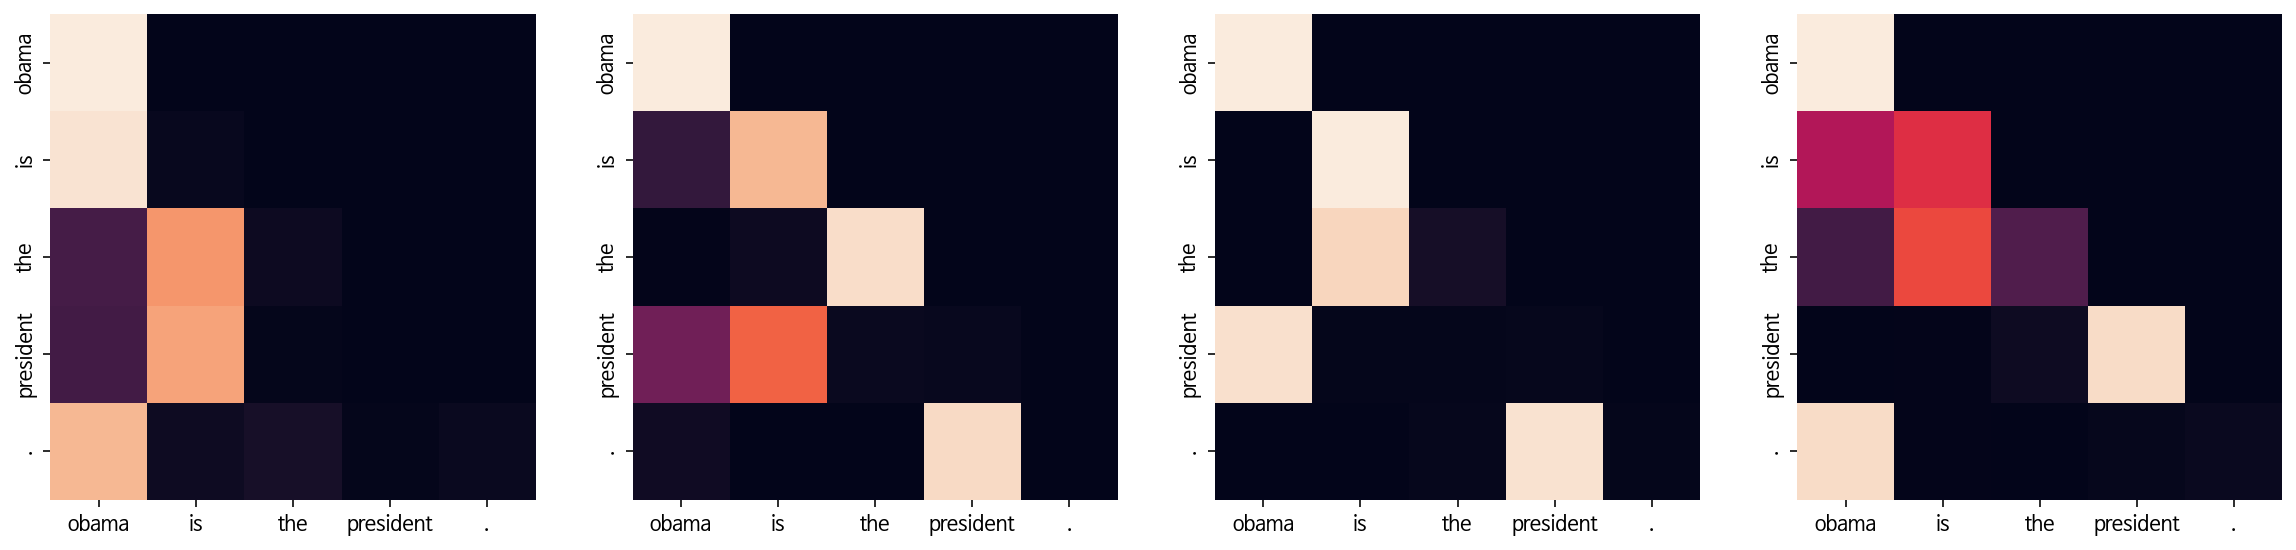

Decoder Src Layer 1


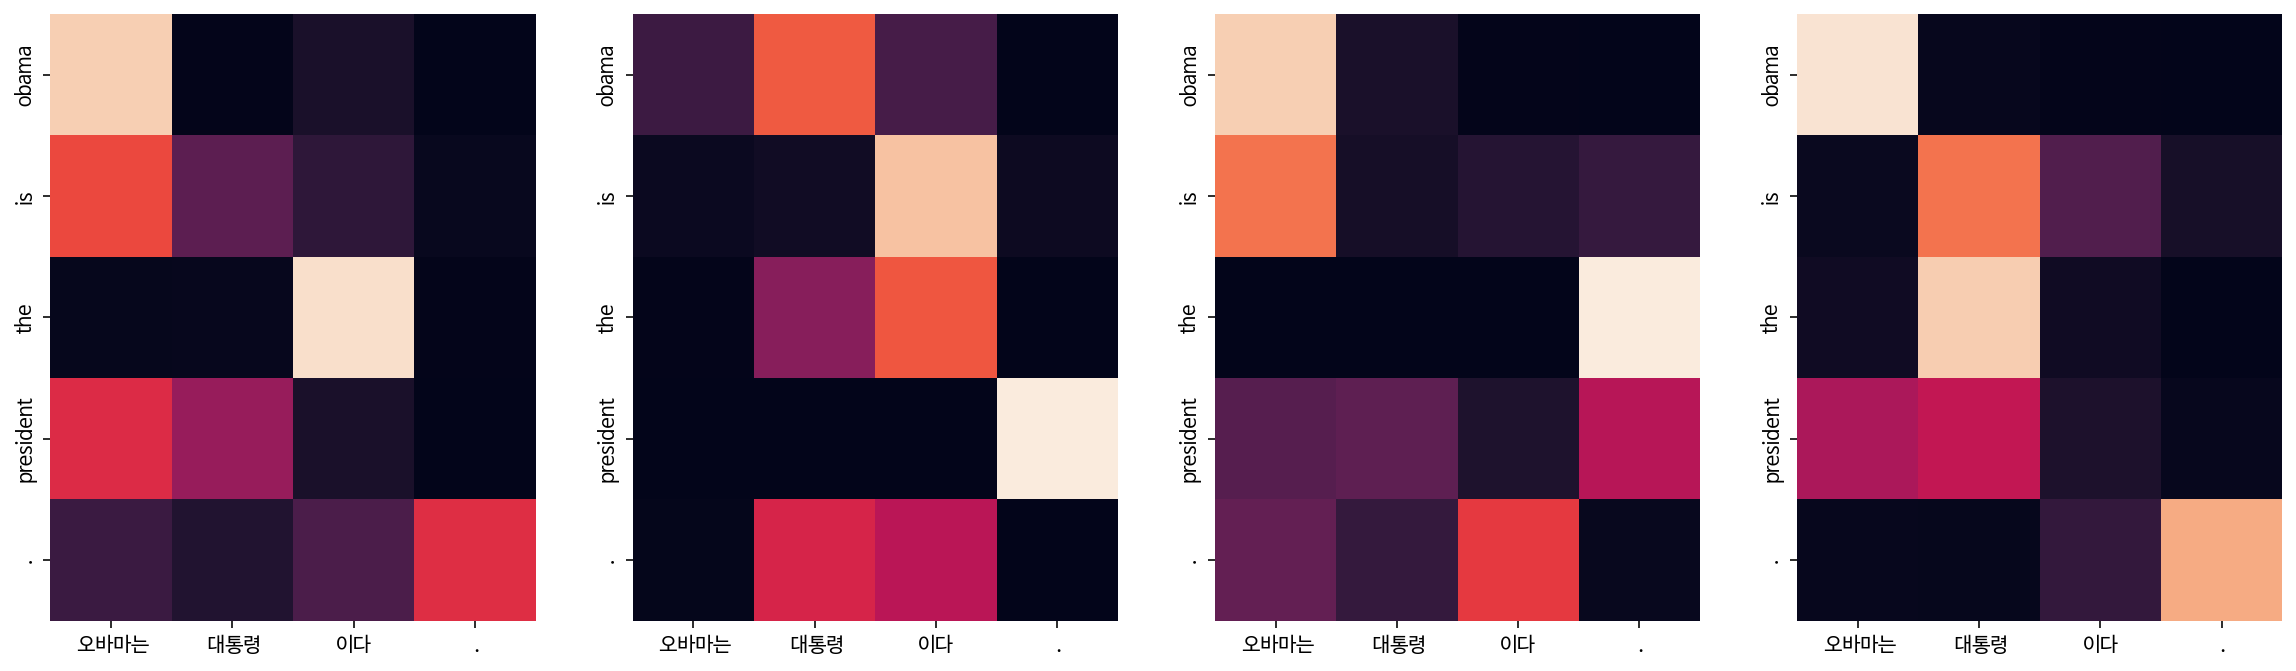

Decoder Self Layer 2


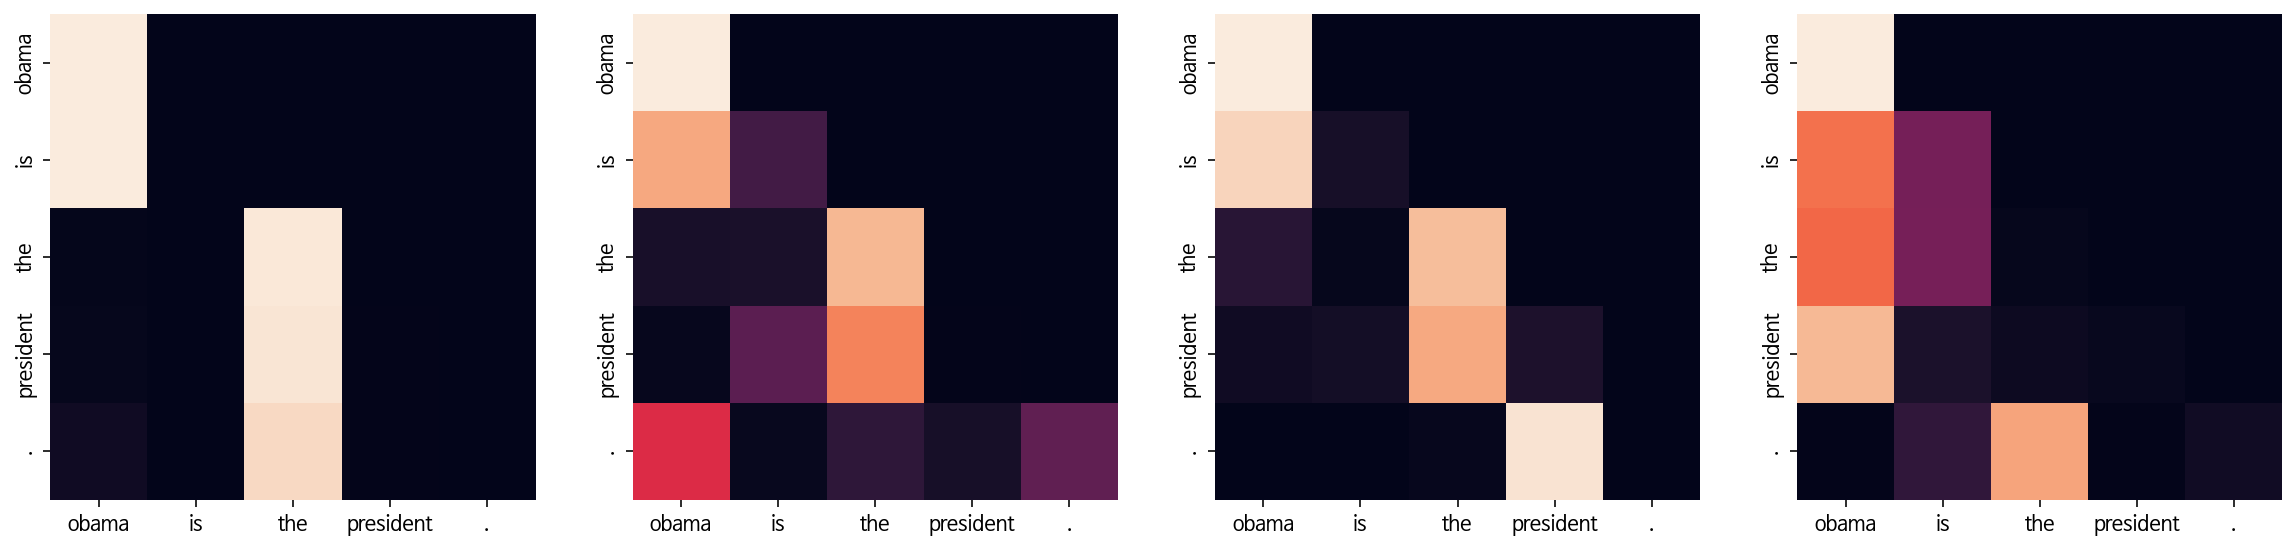

Decoder Src Layer 2


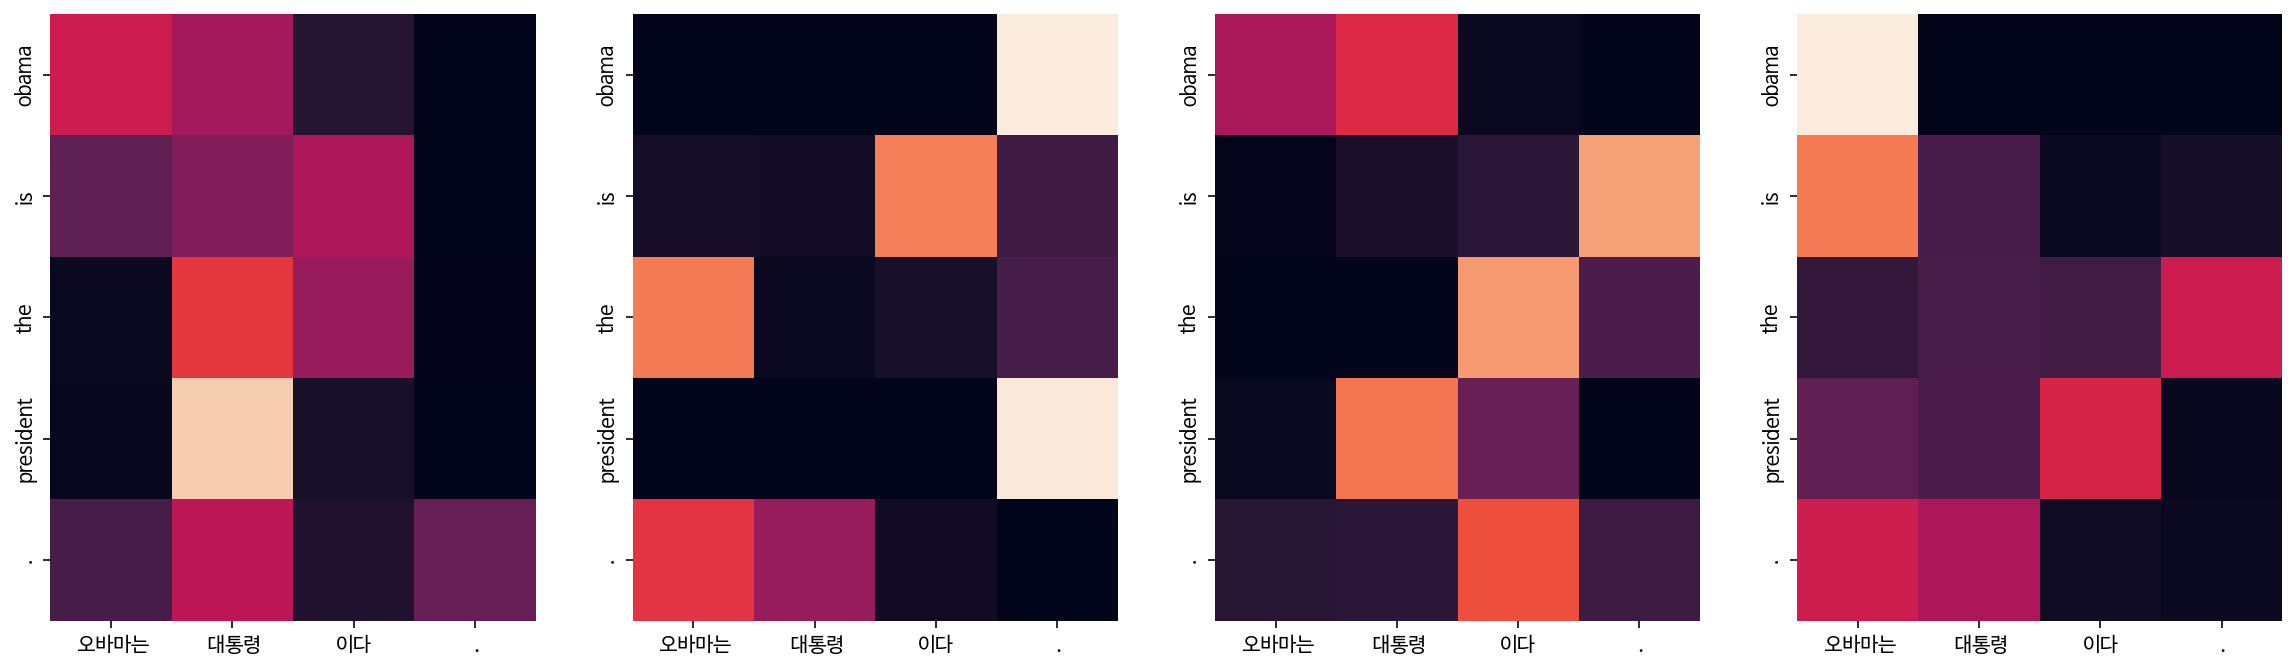

Input: 시민들은 도시 속에 산다.
Predicted translation: the citys mountain is a mountain .
Encoder Layer 1


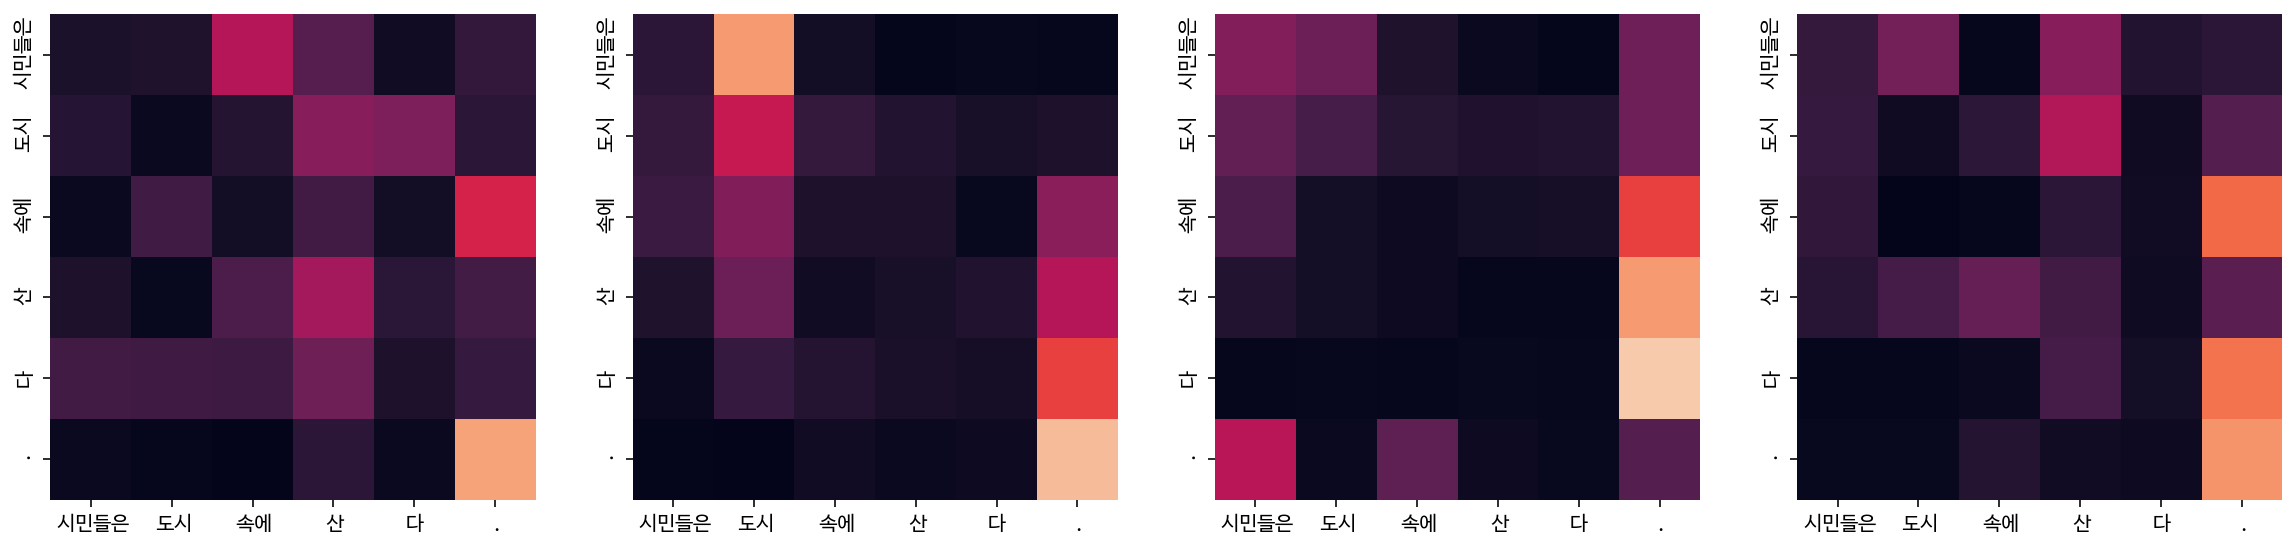

Encoder Layer 2


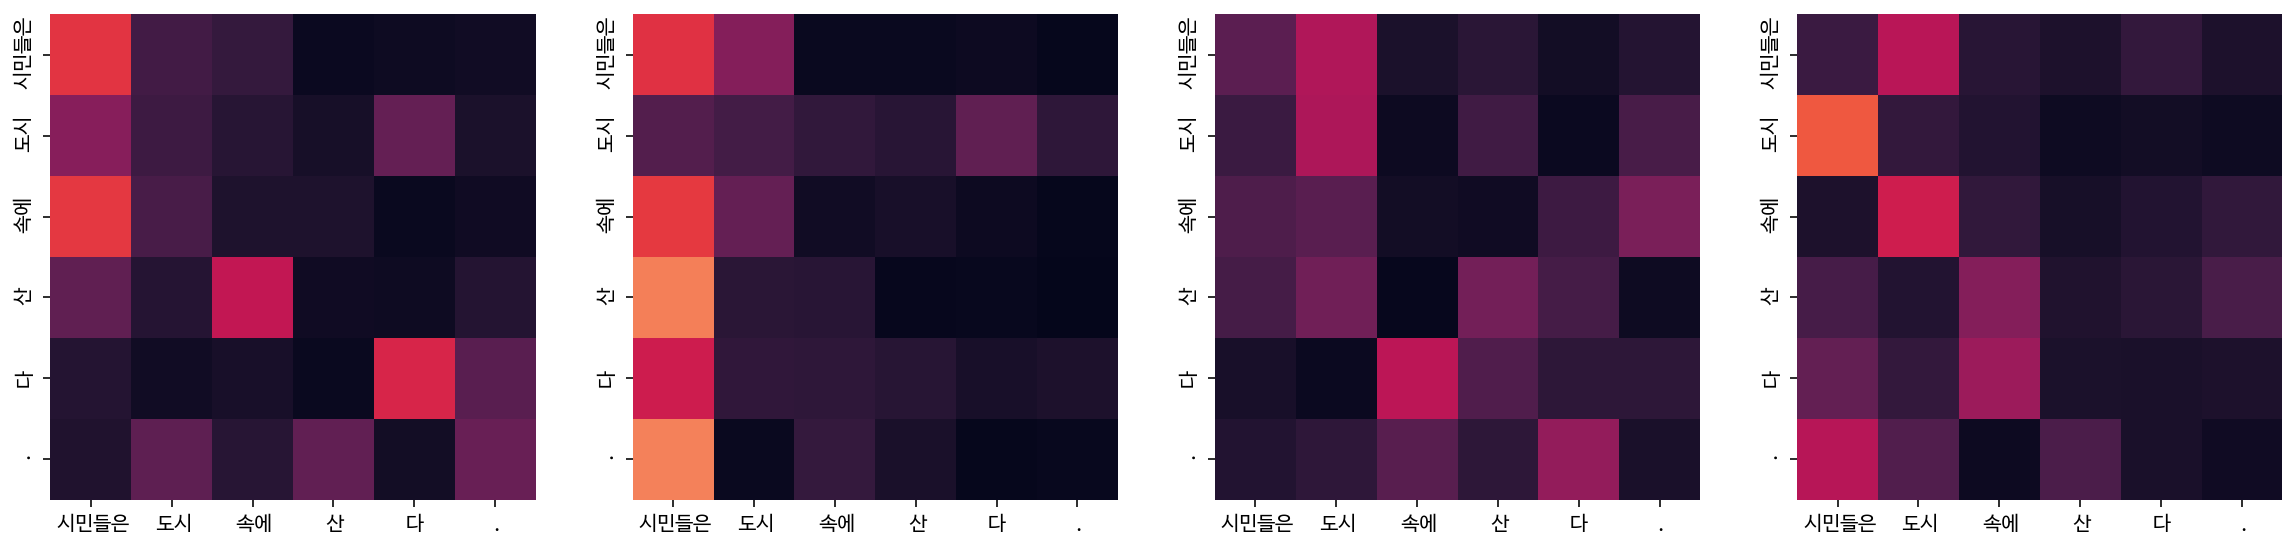

Decoder Self Layer 1


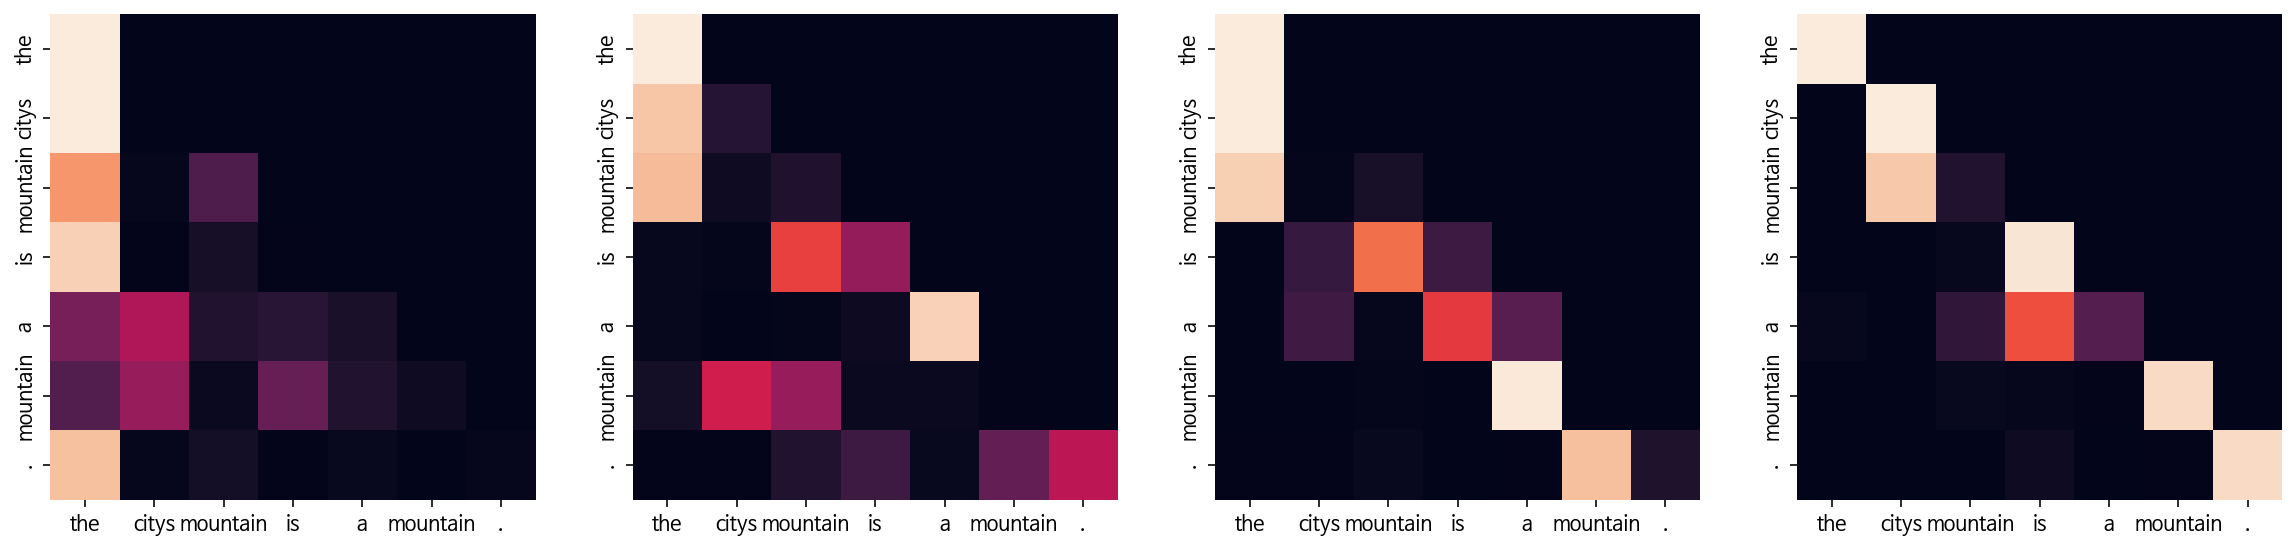

Decoder Src Layer 1


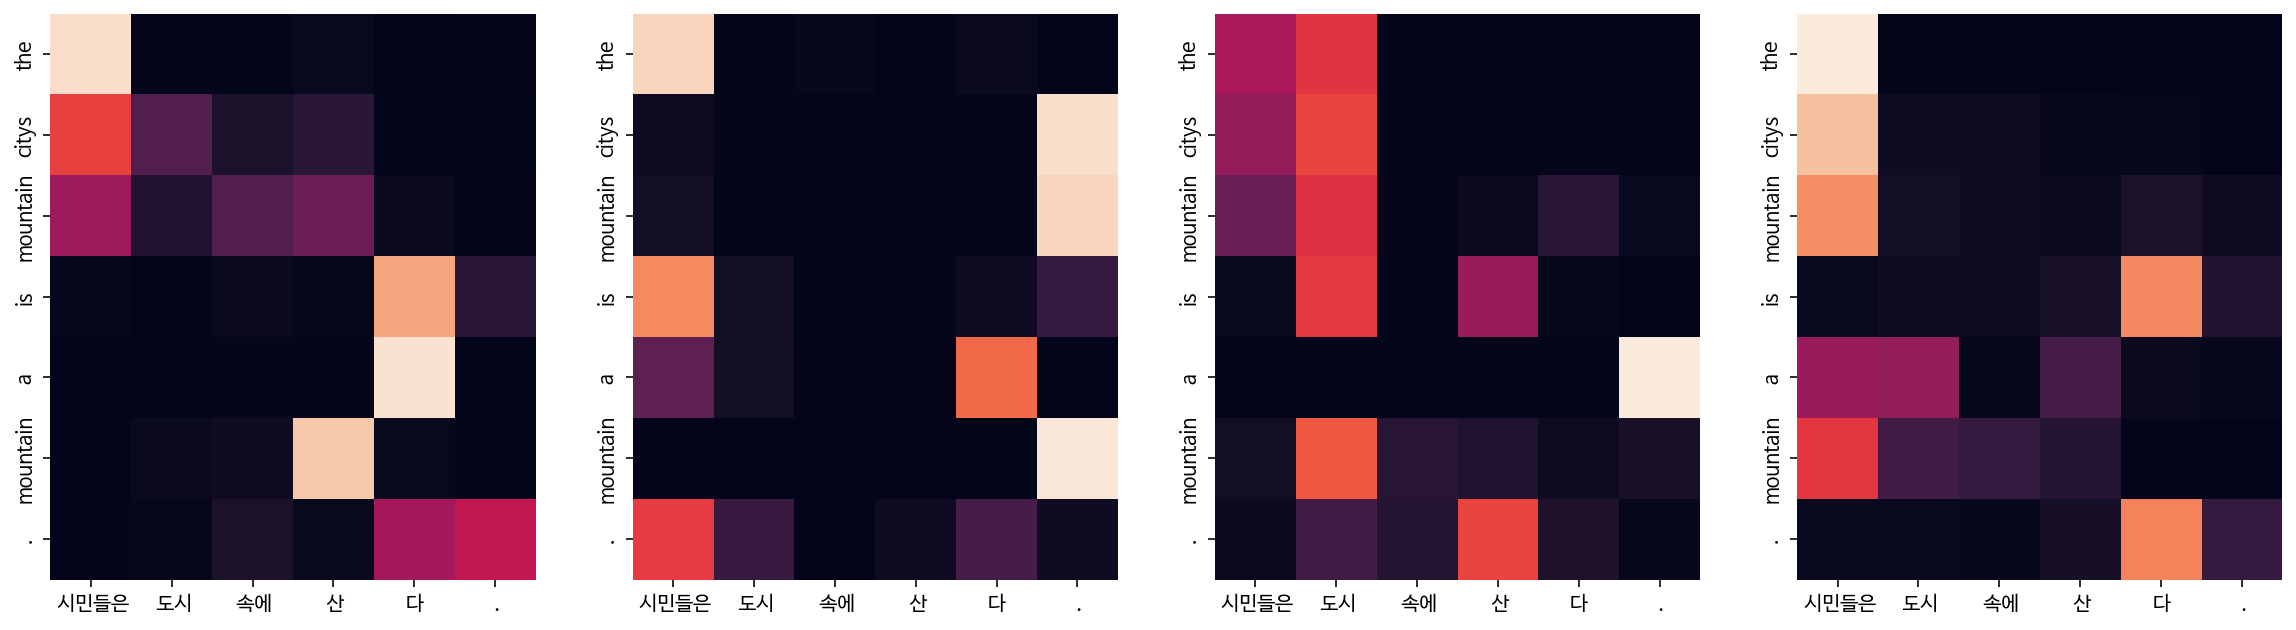

Decoder Self Layer 2


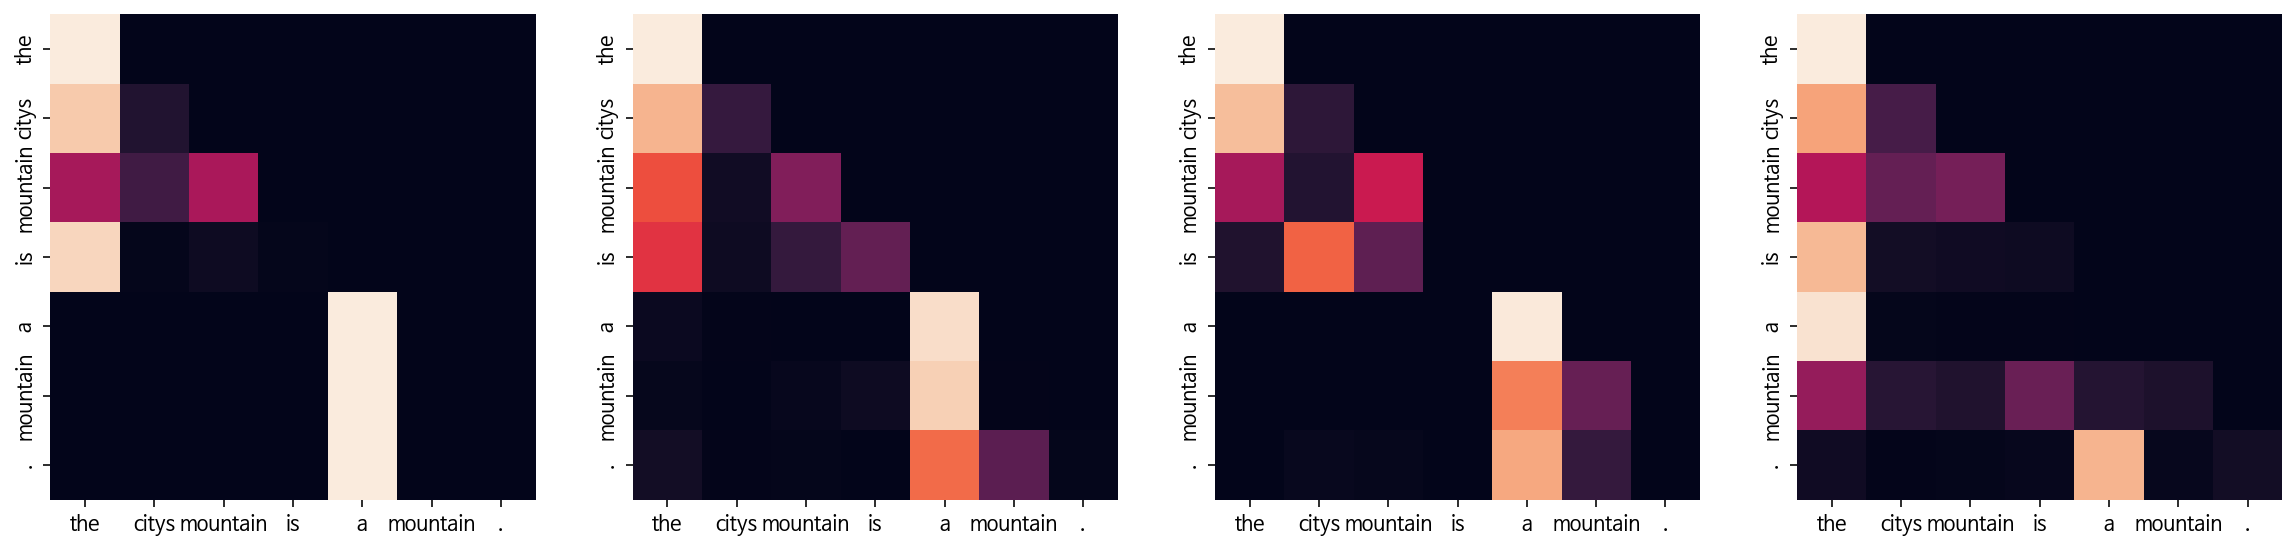

Decoder Src Layer 2


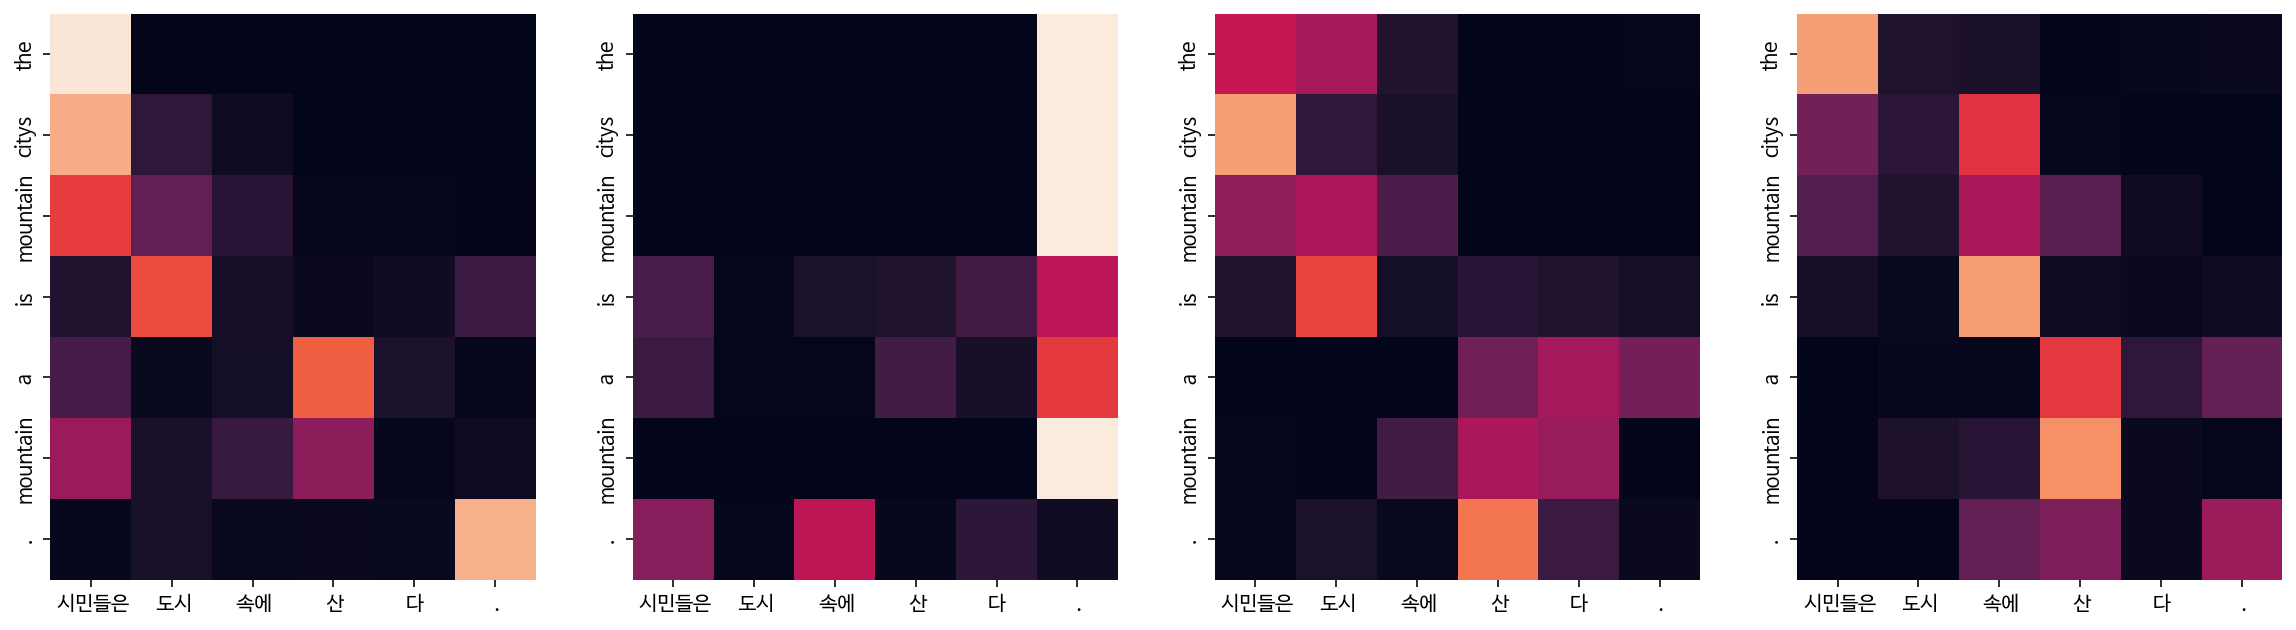

Input: 커피는 필요 없다.
Predicted translation: the coffee is not a need for a few .
Encoder Layer 1


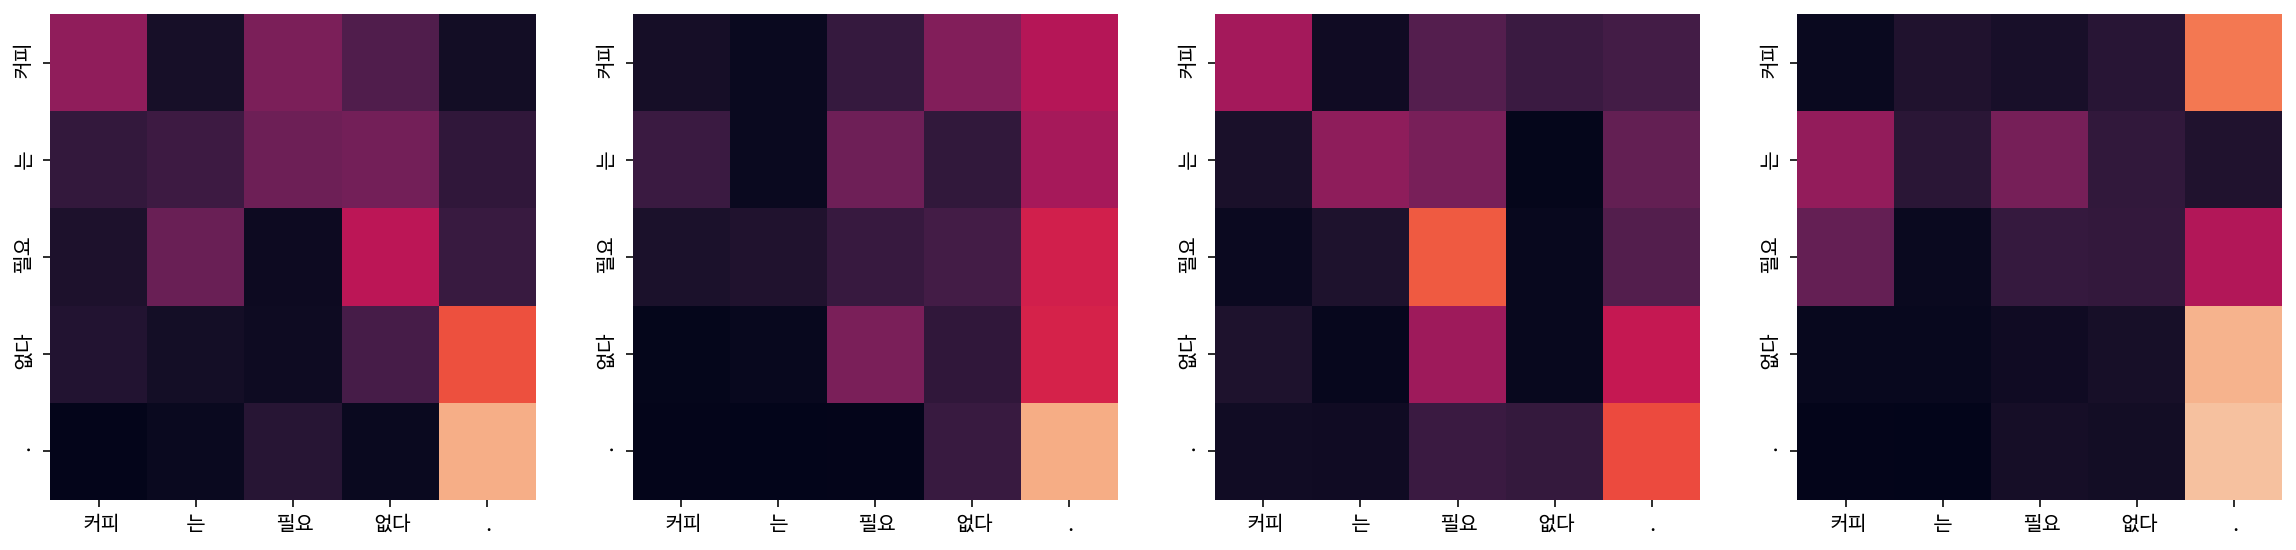

Encoder Layer 2


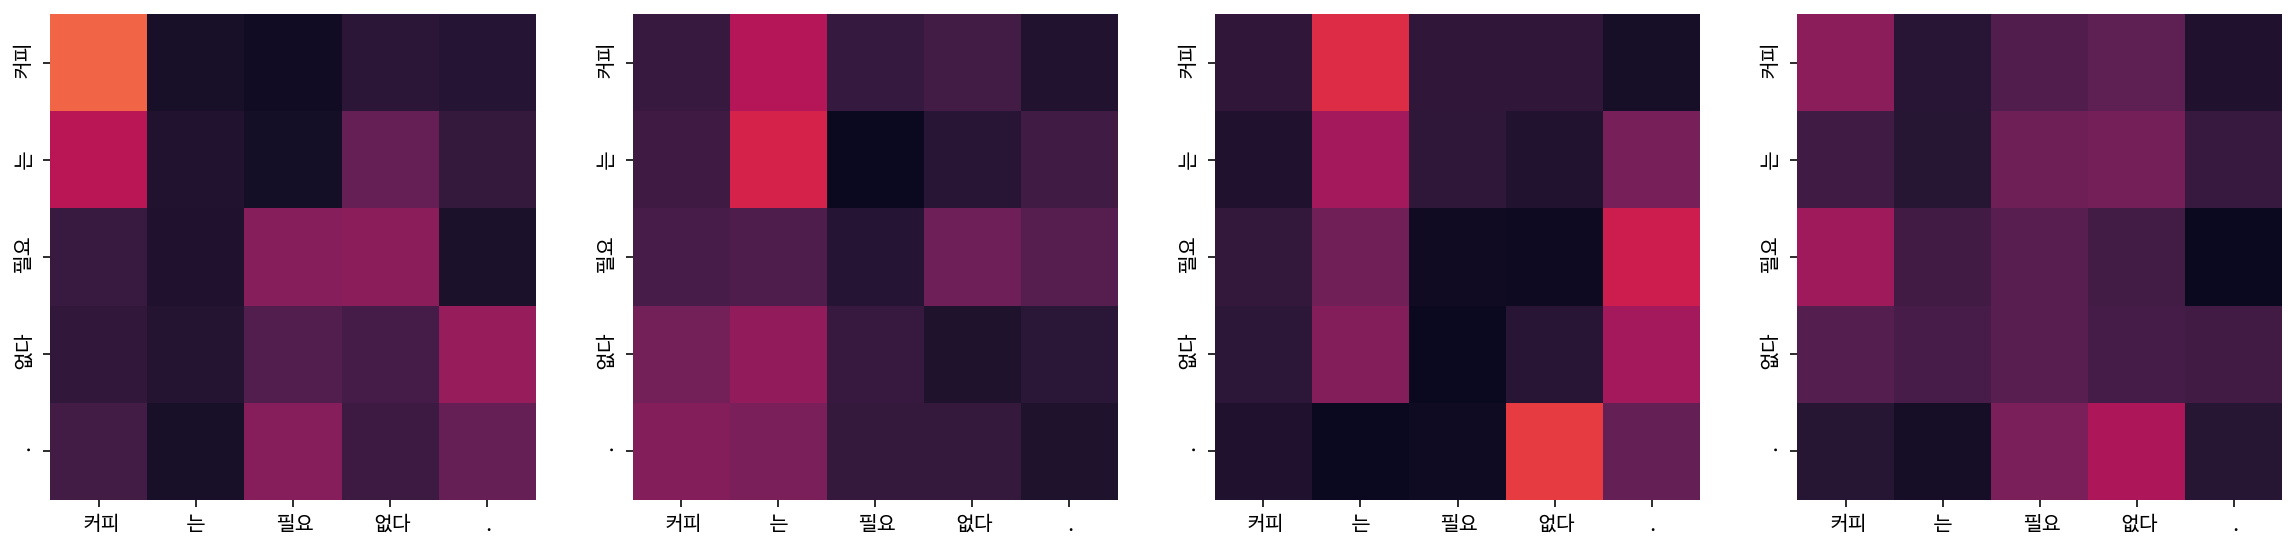

Decoder Self Layer 1


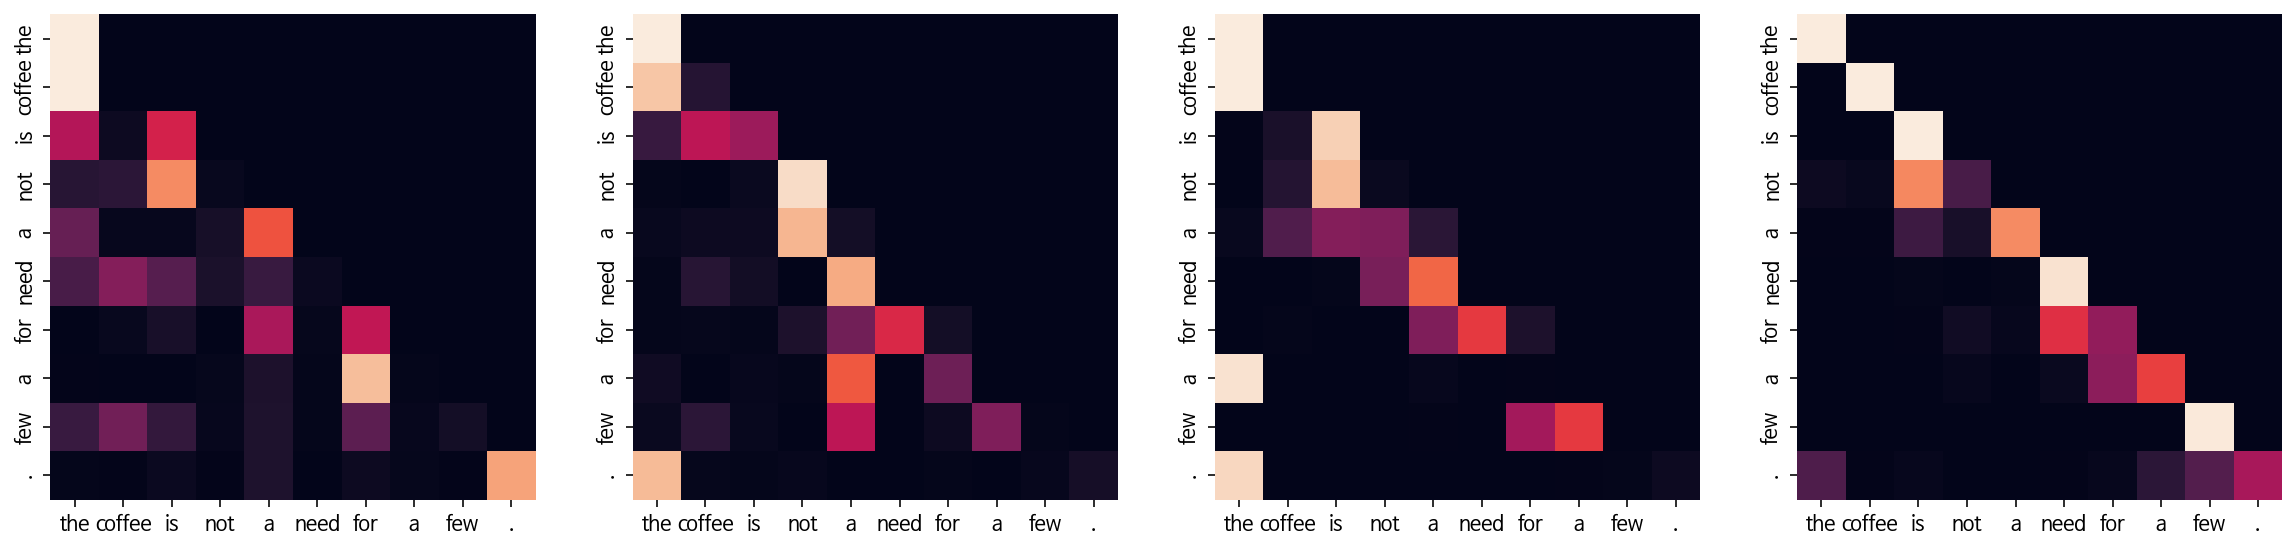

Decoder Src Layer 1


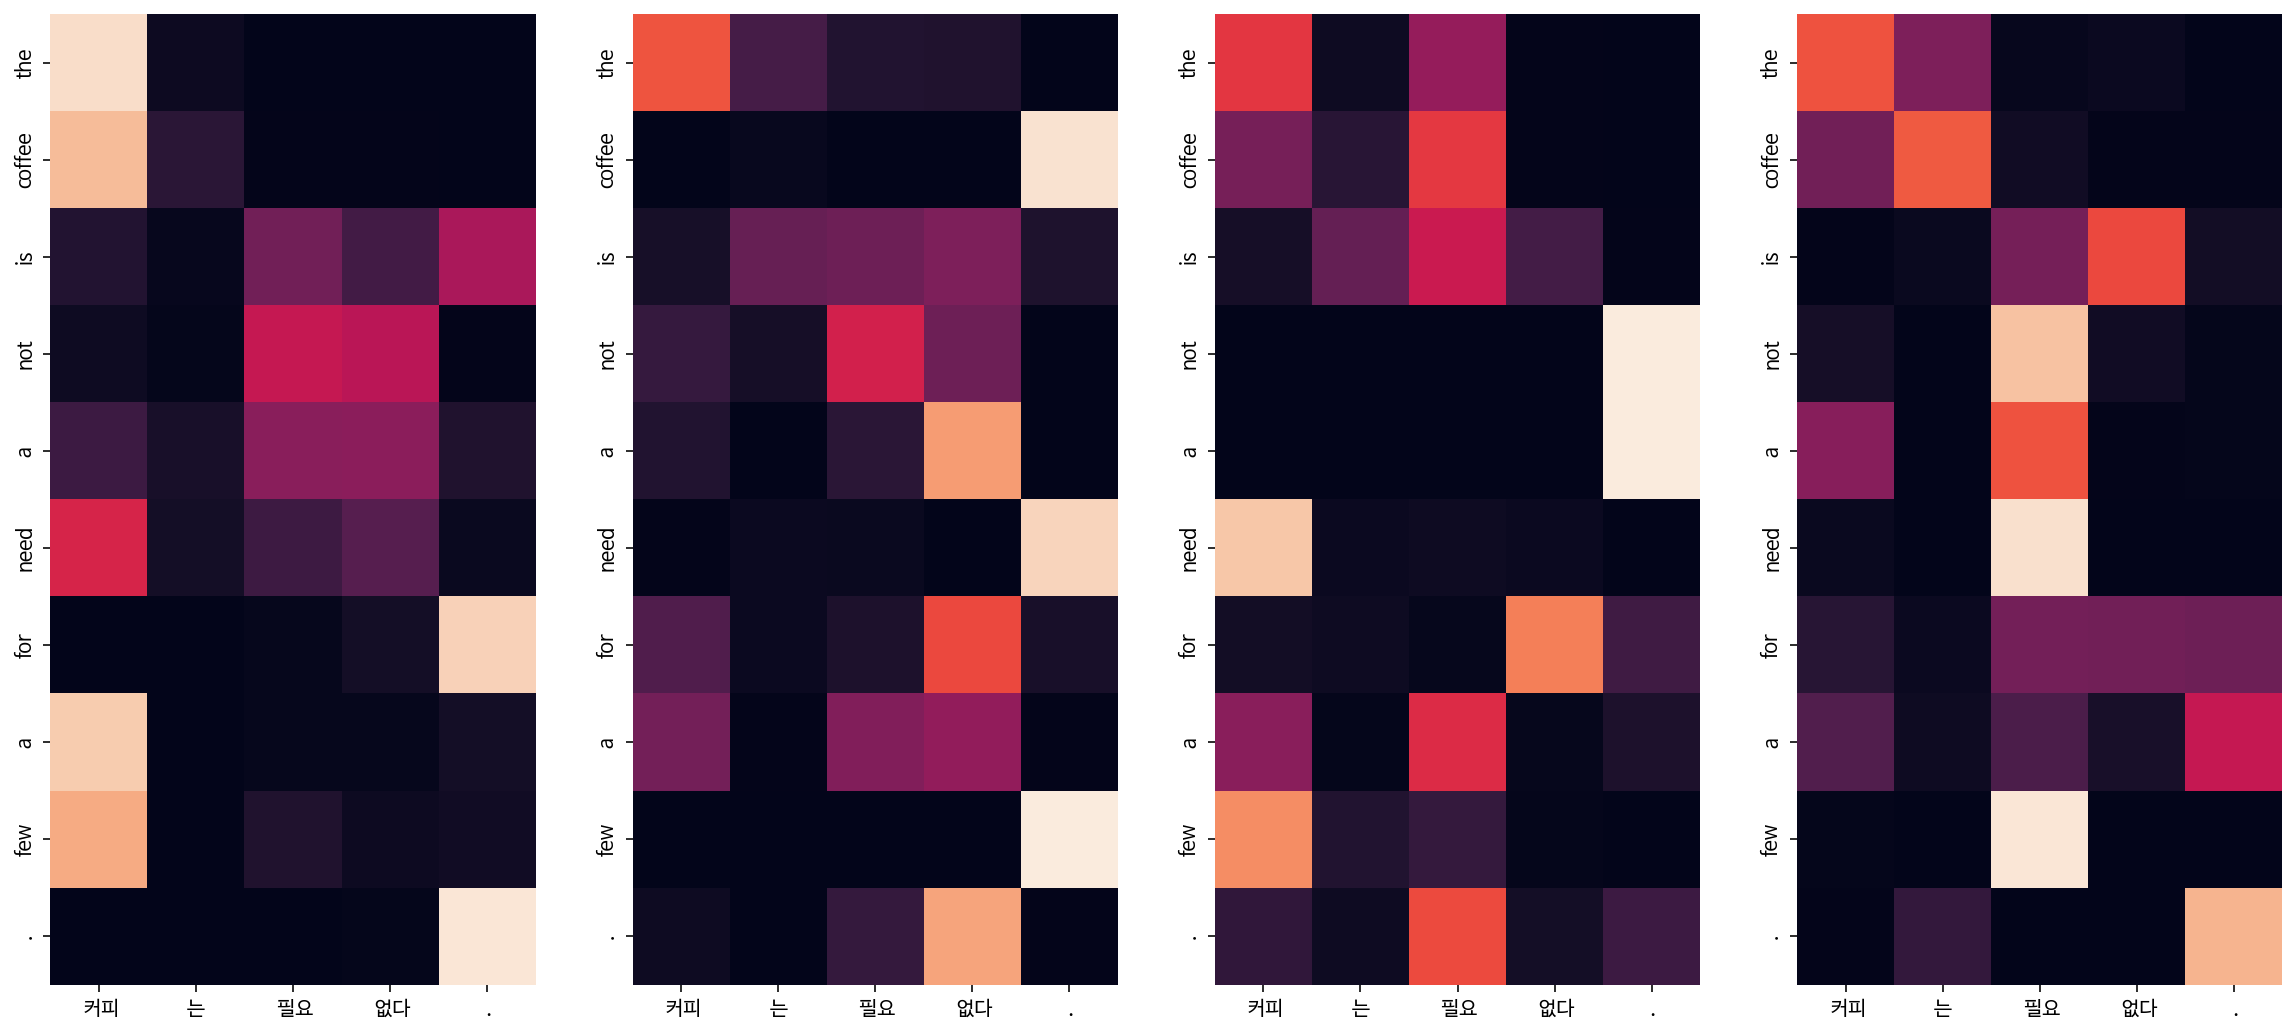

Decoder Self Layer 2


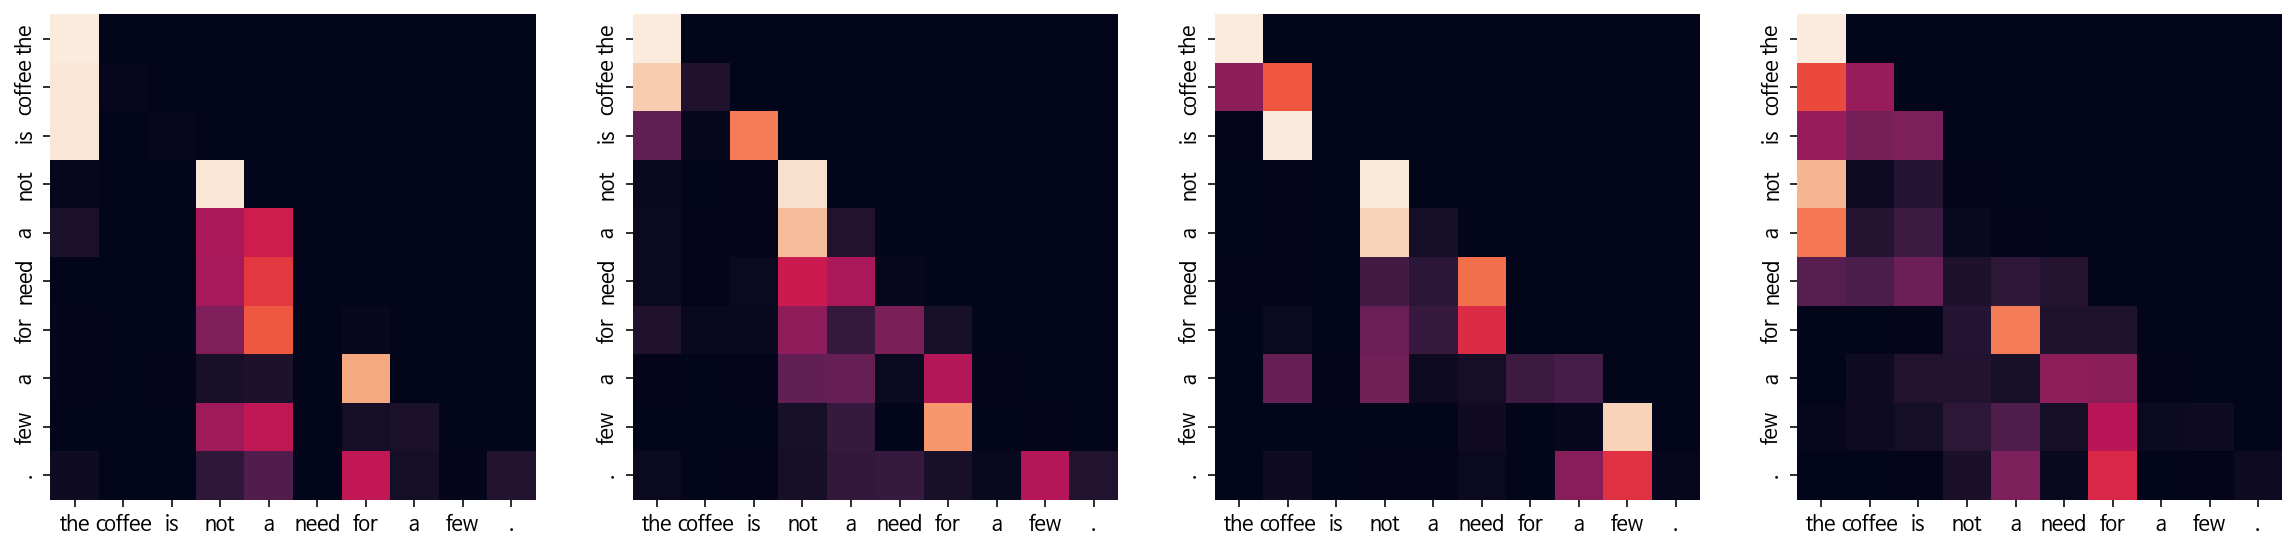

Decoder Src Layer 2


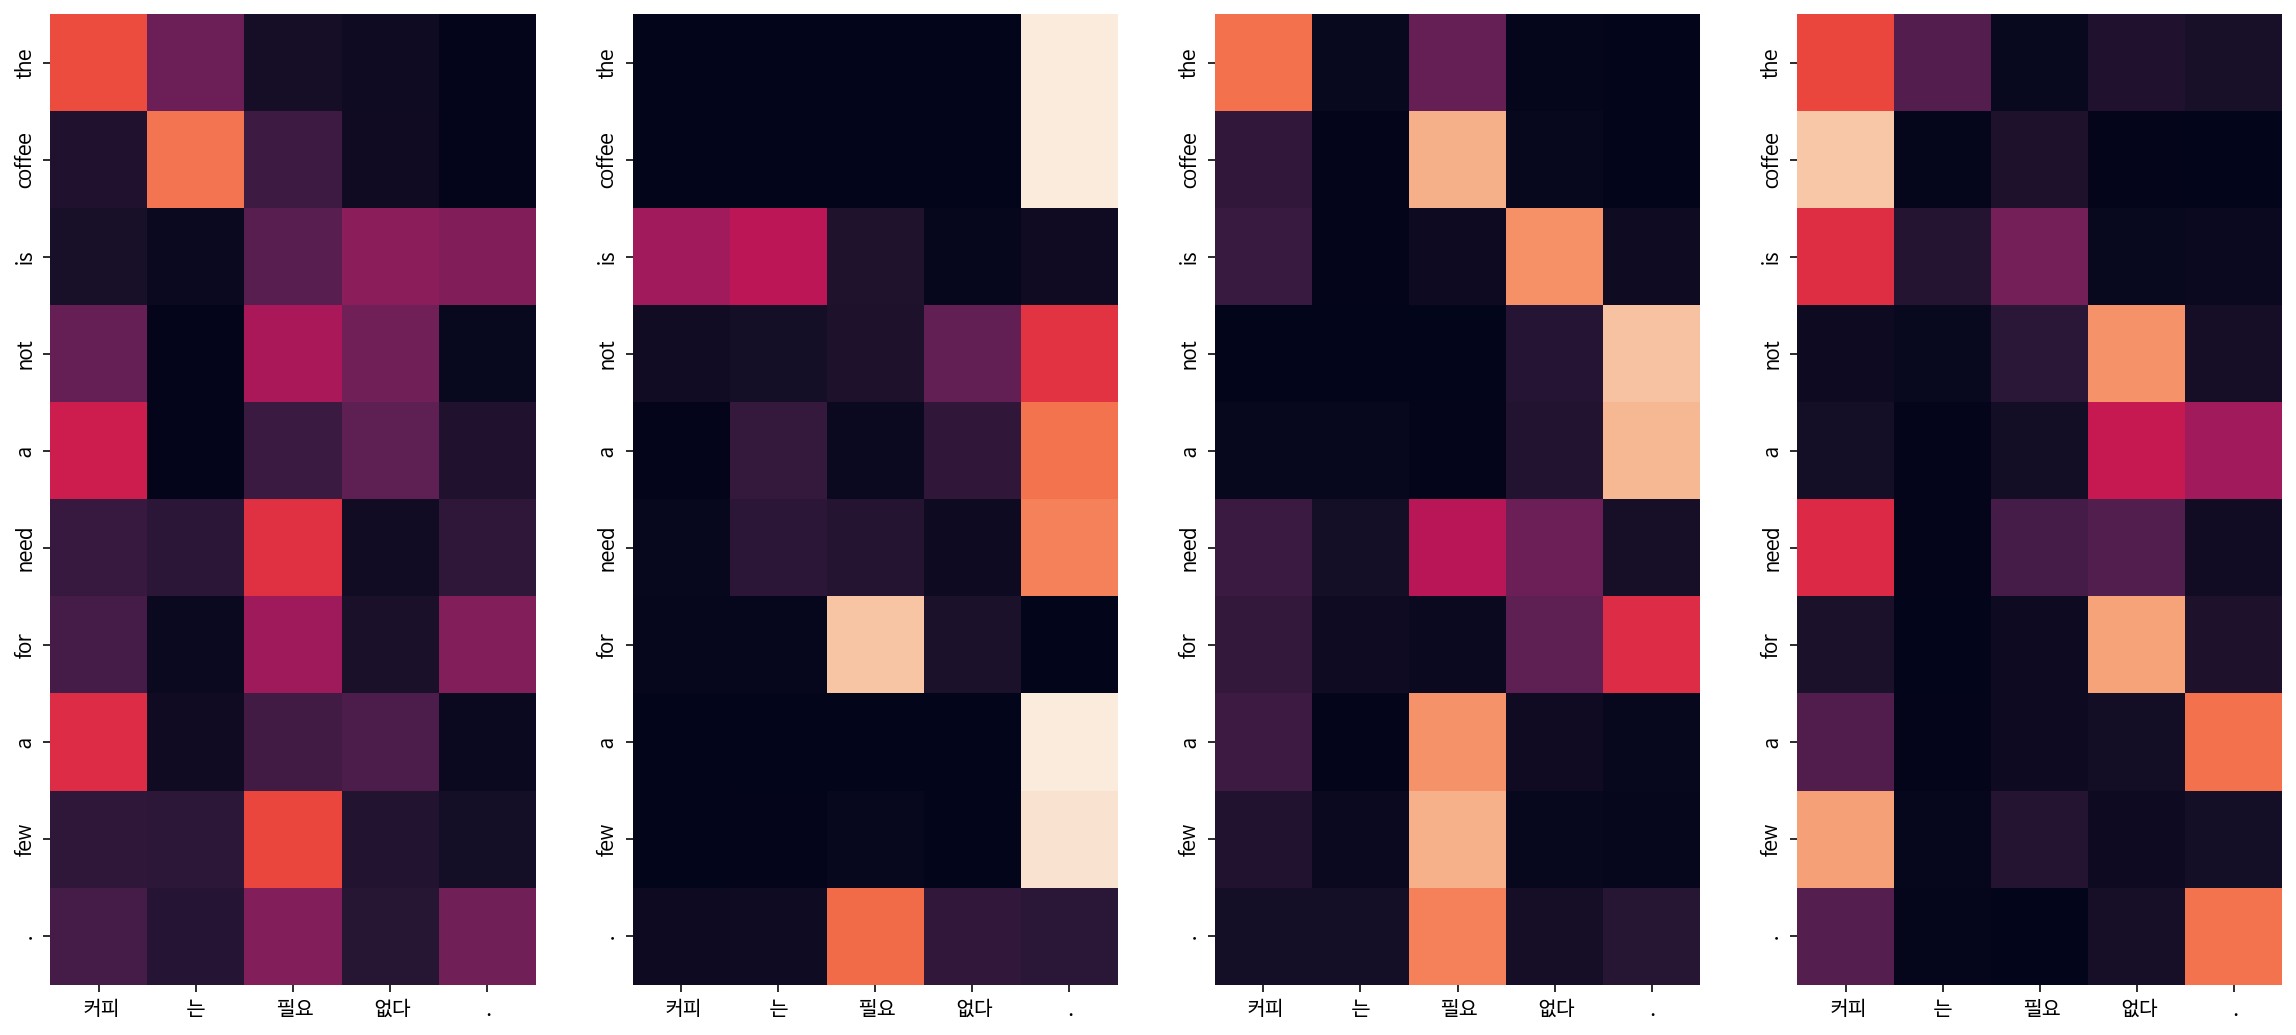

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed .
Encoder Layer 1


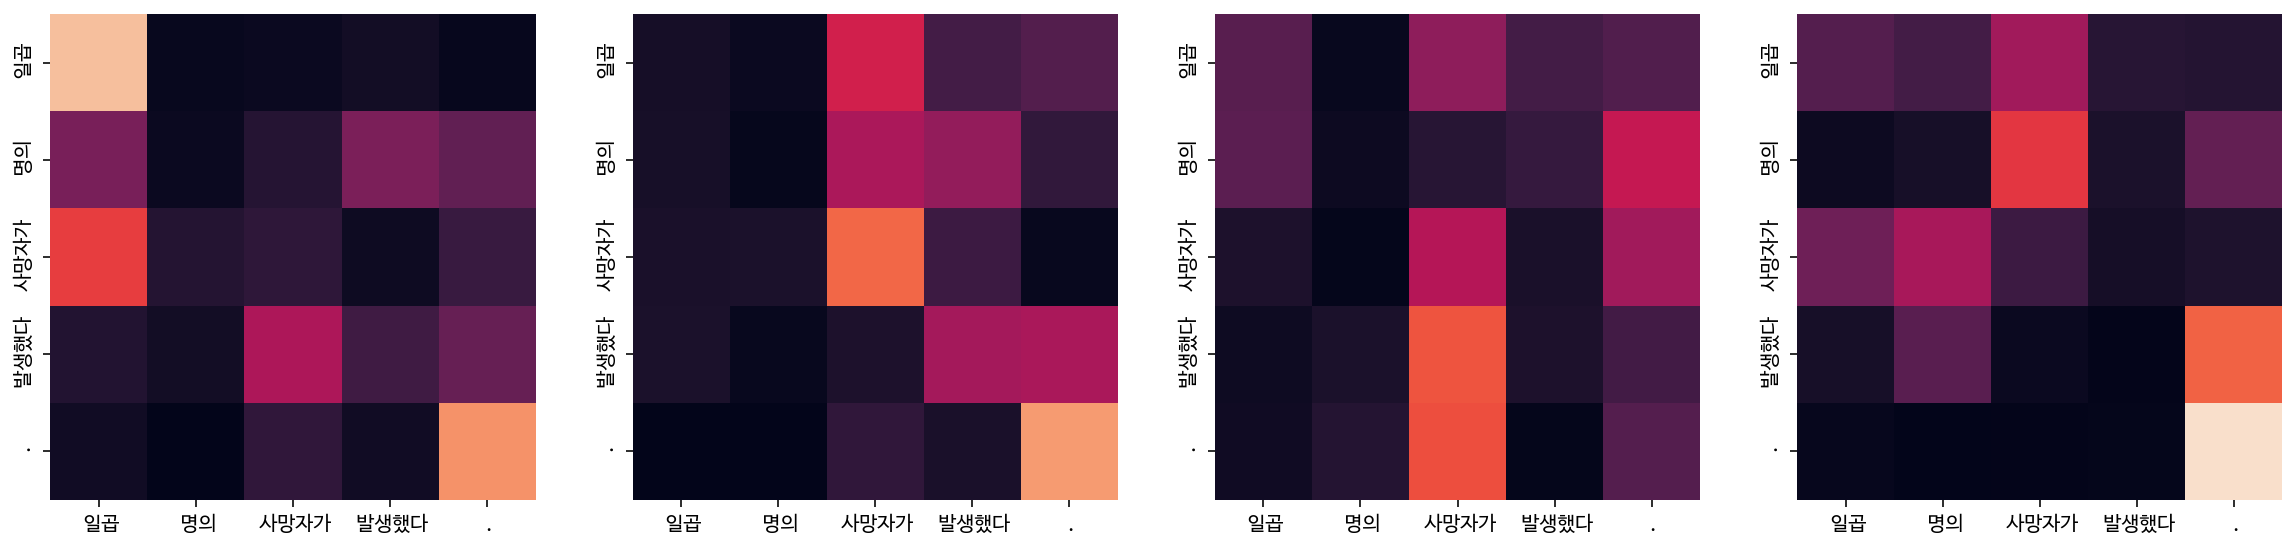

Encoder Layer 2


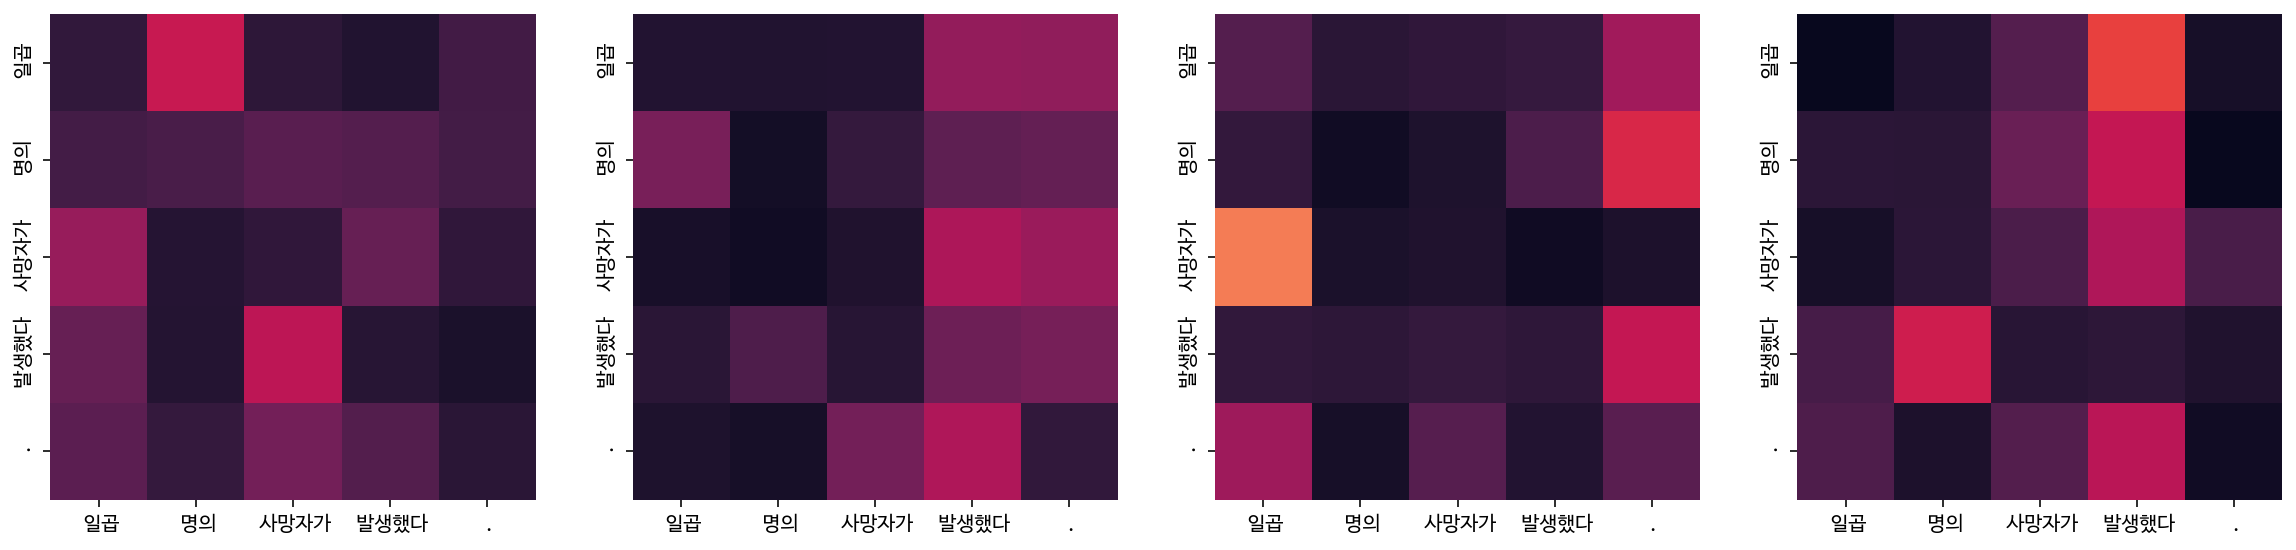

Decoder Self Layer 1


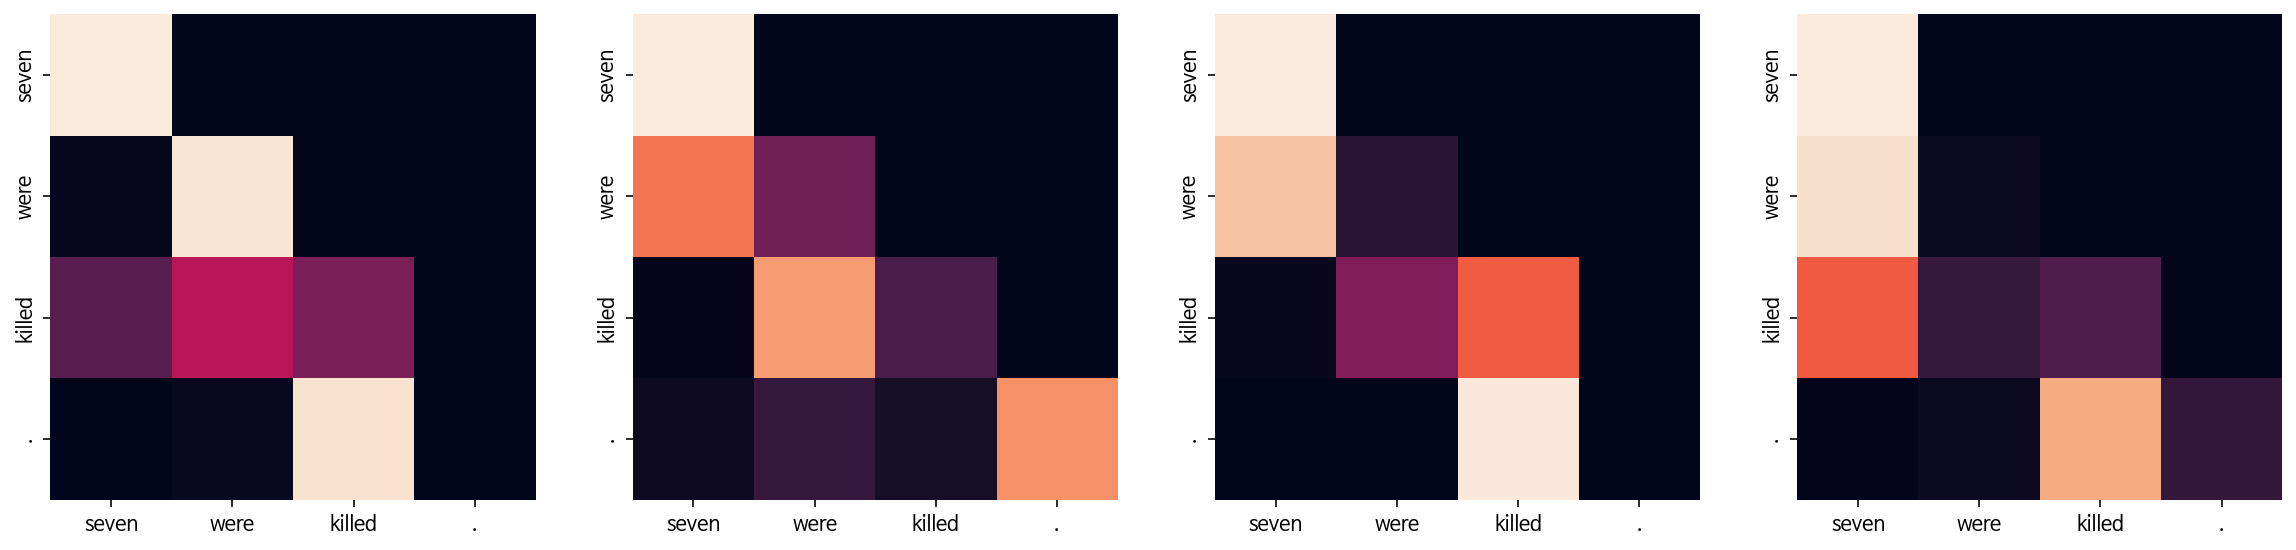

Decoder Src Layer 1


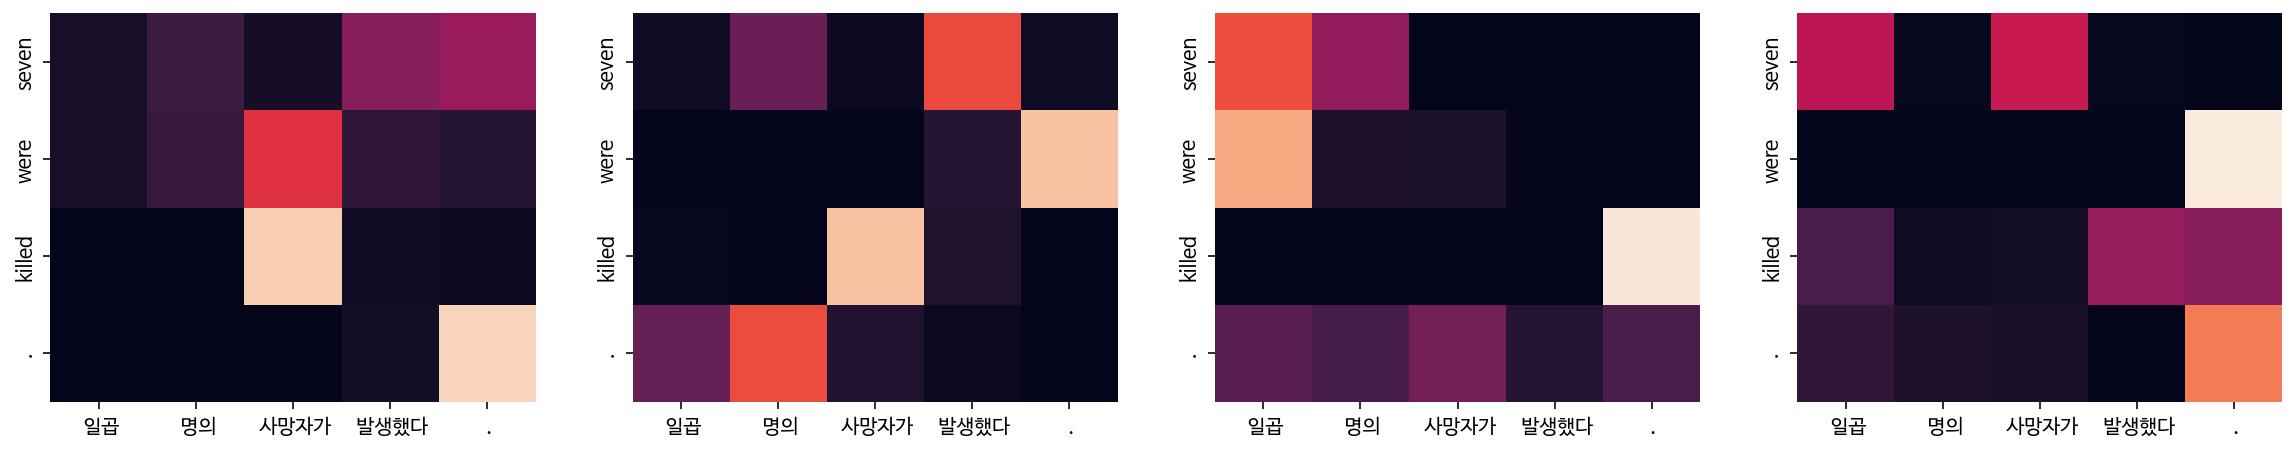

Decoder Self Layer 2


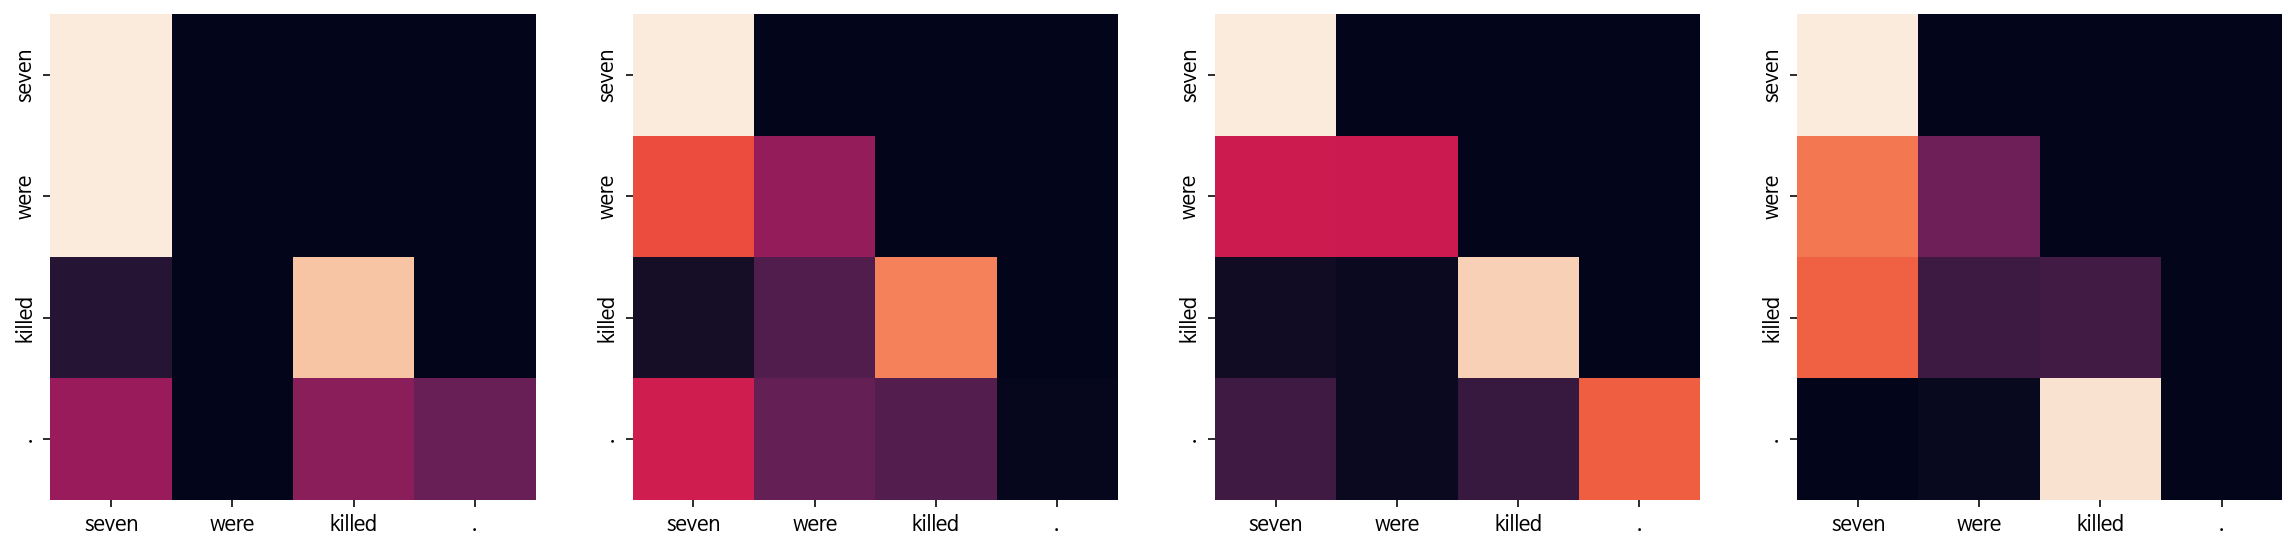

Decoder Src Layer 2


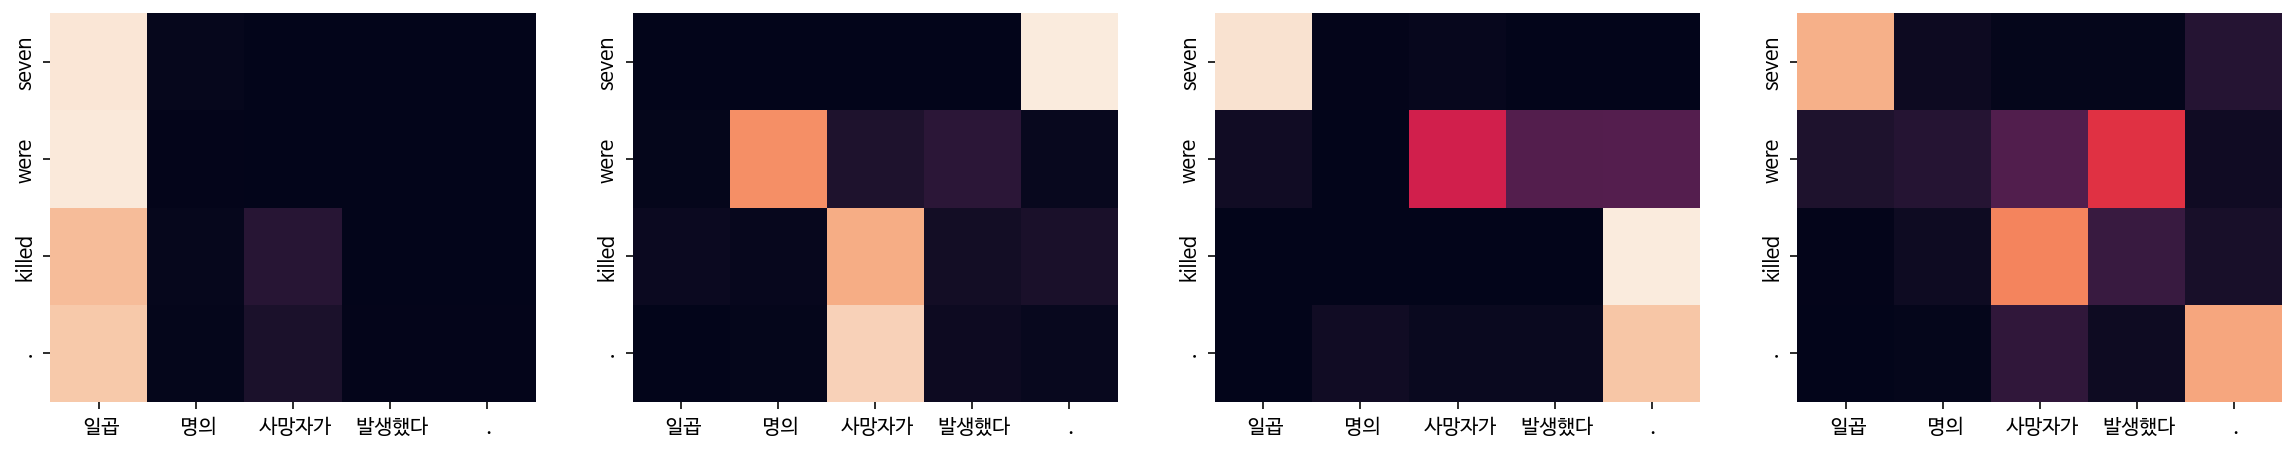

In [446]:
BATCH_SIZE = 64
EPOCHS = 3

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer, True)

In [554]:
BATCH_SIZE = 64
EPOCHS = 5

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_557/2820920197.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1174 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama has been a presidential term .
Input: 시민들은 도시 속에 산다.
Predicted translation: the storm is in the water .
Input: 커피는 필요 없다.
Predicted translation: coffee is not a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died .


  0%|          | 0/1174 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is expected to be the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city residents of cities are the city of cities .
Input: 커피는 필요 없다.
Predicted translation: coffee is not a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead death toll in the dead death toll .


  0%|          | 0/1174 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the urban city is the mountain .
Input: 커피는 필요 없다.
Predicted translation: coffee is not a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died when the death occurred .


  0%|          | 0/1174 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the urban areas are the ones .
Input: 커피는 필요 없다.
Predicted translation: dont need the need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people killed in the seven deaths .


  0%|          | 0/1174 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a political course .
Input: 시민들은 도시 속에 산다.
Predicted translation: the urban areas are the countryside .
Input: 커피는 필요 없다.
Predicted translation: dont get a walk .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


---
< 짧은 회고 > 
- 코드를 구현하는데는 여전히 어려움이 많다. Masking code에 issue가 있어서, 처리하면서 공부를 할 수 있었다, 하지만 base line code를 제대로 파악 하지 못한 부분이 있어서 코드를 뜯어보면서 더 공부할 필요가 있을것 같다.
- Paper에서 말하고 있는 Position-wise-FFN 부분에 kernel size1 짜리 conv layer 사용하는 방법도 확인해보면 재미있을것 같다.